In [1]:
import os
import time
import torch
import shutil
import random
import sklearn
import numpy as np
import torchvision
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix

In [2]:
# GPU Memory Reset
from numba import cuda
device = cuda.get_current_device()
device.reset()

# **Loading Data**

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Remove folders from dataset
try:
  shutil.rmtree('EuroSAT_RGB')
  shutil.rmtree('__MACOSX')
  shutil.rmtree('imagens_treino')
  shutil.rmtree('imagens_teste')
except Exception as e:
  print(f'Folders not found')

Folders not found


In [5]:
# Unzip dataset
!unzip /content/drive/MyDrive/Colab\ Notebooks/Cap9/EuroSAT_RGB.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_2494.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_2494.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_2480.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_2480.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_292.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_292.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_1189.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_1189.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_1837.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_1837.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_2496.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_2496.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_284.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCro

In [6]:
if not os.path.isdir('train_images'):
  os.mkdir('train_images')
if not os.path.isdir('test_images'):
  os.mkdir('test_images')

In [7]:
source_images = 'EuroSAT_RGB'
destination_train = 'train_images'
destination_test = 'test_images'

# **Separating Images**

In [8]:
image_class = 0
class_dict = {}

In [9]:
files = os.listdir(source_images)
files.sort()

In [10]:
# Iterate over all images
for file_path in files:
  # Check if the file is not a hidden file
  if file_path[0] != '.':
    # List all images in the current directory
    images = os.listdir(source_images + '/' + file_path)

    # Calculate sample size for training (80% of images)
    sample_size = int(len(images) * 0.8)

    # Initialize a list to store training image names
    train = []

    # Define the destination path for training images
    final_dest = destination_train + '/' + str(image_class)

    # Create the destination directory for training images
    os.mkdir(final_dest)

    # Copy a random sample of images to the training directory
    for file_name in random.sample(images, sample_size):
      shutil.copy2(os.path.join(source_images, file_path, file_name), final_dest)

      # Add the file name to the training list
      train.append(file_name)

    # Determine the test images by subtracting the training images from all images
    test_images = list(set(images) - set(train))

    # Define the destination path for test images
    final_dest = destination_test + '/' + str(image_class)

    # Create the destination directory for test images
    os.mkdir(final_dest)

    # Copy the test images to the test directory
    for test_image in test_images:
      shutil.copy2(os.path.join(source_images, file_path, test_image), final_dest)

    # Map the current class index to the file path in the class dictionary
    class_dict[image_class] = file_path

    # Increment the class index for the next iteration
    image_class += 1

# **PreProcessing and Creating DataLoader**

In [11]:
# Data Transformation
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [12]:
train_dataset = torchvision.datasets.ImageFolder(root = 'train_images', transform = transform)

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 2)

In [13]:
test_dataset = torchvision.datasets.ImageFolder(root = 'test_images', transform = transform)

dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = True, num_workers = 2)

# **Plotting Images**

In [14]:
def imshow(img):
  img = img / 2 + 0.5

  npimg = img.numpy()

  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [15]:
dataiter = iter(dl_train)
images, labels = next(dataiter)

In [16]:
mapping = {0: 'AnnualCrop',
           1: 'Forest',
           2: 'HerbaceousVegetation',
           3: 'Highway',
           4: 'Industrial',
           5: 'Pasture',
           6: 'PermanentCrop',
           7: 'Residential',
           8: 'River',
           9: 'SeaLake'}

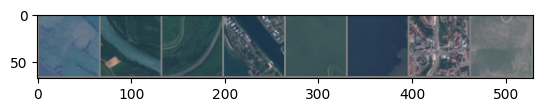

In [17]:
imshow(torchvision.utils.make_grid(images[:8]))
print('Labels:', ' '.join('%d' % labels[j] for j in range(8)))

# **Creating Model**

In [18]:
# Define a convolutional neural network (ConvNet) class
class ConvNet(nn.Module):
  # Initialization method for the class
  def __init__(self):
    # Call the initialization method of the parent class (nn.Module)
    super(ConvNet, self).__init__()

    # Define the first convolutional layer
    # This layer takes images with 3 channels (RGB), produces 64 feature maps,
    # uses filters of size 3x3, and a stride of 1
    self.conv1 = nn.Conv2d(3, 64, 3, 1)

    # Define the second convolutional layer
    # This layer takes the 64 feature maps from the previous layer and produces 128 new maps,
    # with filters of size 3x3 and a stride of 1
    self.conv2 = nn.Conv2d(64, 128, 3, 1)

    # Define the third convolutional layer
    # This layer takes the 128 feature maps from the previous layer and produces 256 new maps,
    # with filters of size 3x3 and a stride of 1
    self.conv3 = nn.Conv2d(128, 256, 3, 1)

    # Define a dropout layer with a rate of 25% for regularization
    # This helps prevent overfitting during training
    self.dropout1 = nn.Dropout(0.25)

    # Define a second dropout layer with a rate of 50%
    # Provides additional regularization in later layers
    self.dropout2 = nn.Dropout(0.5)

    # Define the first fully connected layer
    # This layer takes an input of size 215296 and outputs 2048 features
    self.fc1 = nn.Linear(215296, 2048)

    # Define the second fully connected layer
    # This layer takes the 2048 features from the previous layer and outputs 512 features
    self.fc2 = nn.Linear(2048, 512)

    # Define the third fully connected layer
    # This layer takes the 512 features from the previous layer and outputs 128 features
    self.fc3 = nn.Linear(512, 128)

    # Define the fourth fully connected layer
    # This layer takes the 128 features from the previous layer and outputs 10 features
    # Typically, this would correspond to the number of classes in a classification problem
    self.fc4 = nn.Linear(128, 10)

  def forward(self, x):
    # Apply the first convolutional layer
    x = self.conv1(x)

    # Apply ReLU activation function
    x = F.relu(x)

    # Apply the second convolutional layer
    x = self.conv2(x)

    # Apply ReLU activation function
    x = F.relu(x)

    # Apply the third convolutional layer
    x = self.conv3(x)

    # Apply ReLU activation function
    x = F.relu(x)

    # Apply max pooling with a kernel size of 2
    x = F.max_pool2d(x, 2)

    # Apply the first dropout layer
    x = self.dropout1(x)

    # Flatten the tensor while keeping the batch size (dimension 0) intact
    x = torch.flatten(x, 1)

    # Apply the first fully connected layer
    x = self.fc1(x)

    # Apply ReLU activation function
    x = F.relu(x)

    # Apply the second dropout layer
    x = self.dropout2(x)

    # Apply the second fully connected layer
    x = self.fc2(x)

    # Apply ReLU activation function
    x = F.relu(x)

    # Apply the third fully connected layer
    x = self.fc3(x)

    # Apply ReLU activation function
    x = F.relu(x)

    # Apply the fourth fully connected layer
    x = self.fc4(x)

    # Apply log softmax activation function for the output
    return F.log_softmax(x, dim=1)


Labels: 5 8 3 8 9 9 3 2


In [19]:
model = ConvNet()

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [21]:
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=215296, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

# **Selecting Loss Function**

In [22]:
loss_function = nn.CrossEntropyLoss()

# **Selecting Optmizer Function**

In [23]:
optimizer = optim.Adam(model.parameters())

# **Training the Model**

In [24]:
epochs = 30

In [25]:
testiter = iter(dl_test)

In [26]:
%%time

print('Training Started')

# Loop through each epoch
for epoch in range(epochs):
  # Initialize the running loss for the epoch
  running_loss = 0.0

  i = 0

  # Loop through the training data
  for data in (pbar := tqdm(dl_train)):
    # Update the progress bar description with the current epoch
    pbar.set_description(f'\nEpoch: {epoch}')

    inputs, labels = data

    # Move the inputs and labels to the specified device (e.g., GPU)
    inputs, labels = inputs.to(device), labels.to(device)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass: compute the model output for the inputs
    outputs = model(inputs)

    # Compute the loss
    loss = loss_function(outputs, labels)

    # Backward pass: compute the gradients
    loss.backward()

    # Update the model parameters
    optimizer.step()

    # Accumulate the loss
    running_loss += loss.item()

    total_correct = 0
    total_samples = 0

    # Perform validation/testing every 100 iterations
    if i % 100 == 0:
      # Disable gradient calculation for validation/testing
      with torch.no_grad():
        # Get a batch of test images and labels
        test_images, test_labels = next(testiter)
        test_images, test_labels = test_images.to(device), test_labels.to(device)

        test_outputs = model(test_images)

        # Get the predicted class labels
        _, predicted = torch.max(test_outputs, 1)

    i += 1

    print(f'Epoch: {epoch}, Loss: {running_loss / (i)}')

print('Training Completed')


Training Started


Epoch: 0:   0%|          | 1/338 [00:01<09:34,  1.70s/it]

Epoch: 0, Loss: 2.2988314628601074



Epoch: 0:   1%|          | 2/338 [00:01<04:48,  1.16it/s]

Epoch: 0, Loss: 2.7332651615142822



Epoch: 0:   1%|          | 3/338 [00:02<03:18,  1.69it/s]

Epoch: 0, Loss: 2.6106643676757812



Epoch: 0:   1%|          | 4/338 [00:02<02:35,  2.15it/s]

Epoch: 0, Loss: 2.5290204286575317



Epoch: 0:   1%|▏         | 5/338 [00:02<02:10,  2.55it/s]

Epoch: 0, Loss: 2.4772045612335205



Epoch: 0:   2%|▏         | 6/338 [00:03<01:56,  2.86it/s]

Epoch: 0, Loss: 2.4303073485692344



Epoch: 0:   2%|▏         | 7/338 [00:03<01:47,  3.07it/s]

Epoch: 0, Loss: 2.3841026169913158



Epoch: 0:   2%|▏         | 8/338 [00:03<01:42,  3.23it/s]

Epoch: 0, Loss: 2.337168961763382



Epoch: 0:   3%|▎         | 9/338 [00:03<01:38,  3.35it/s]

Epoch: 0, Loss: 2.300942791832818



Epoch: 0:   3%|▎         | 10/338 [00:04<01:35,  3.44it/s]

Epoch: 0, Loss: 2.268933415412903



Epoch: 0:   3%|▎         | 11/338 [00:04<01:33,  3.48it/s]

Epoch: 0, Loss: 2.2392240004106



Epoch: 0:   4%|▎         | 12/338 [00:04<01:32,  3.52it/s]

Epoch: 0, Loss: 2.2032734056313834



Epoch: 0:   4%|▍         | 13/338 [00:04<01:30,  3.58it/s]

Epoch: 0, Loss: 2.1861141369893002



Epoch: 0:   4%|▍         | 14/338 [00:05<01:29,  3.60it/s]

Epoch: 0, Loss: 2.1700660160609653



Epoch: 0:   4%|▍         | 15/338 [00:05<01:28,  3.65it/s]

Epoch: 0, Loss: 2.1513864994049072



Epoch: 0:   5%|▍         | 16/338 [00:05<01:27,  3.67it/s]

Epoch: 0, Loss: 2.1286571994423866



Epoch: 0:   5%|▌         | 17/338 [00:06<01:31,  3.53it/s]

Epoch: 0, Loss: 2.103771034409018



Epoch: 0:   5%|▌         | 18/338 [00:06<01:30,  3.55it/s]

Epoch: 0, Loss: 2.0811962617768183



Epoch: 0:   6%|▌         | 19/338 [00:06<01:31,  3.49it/s]

Epoch: 0, Loss: 2.0758850825460335



Epoch: 0:   6%|▌         | 20/338 [00:06<01:30,  3.52it/s]

Epoch: 0, Loss: 2.057897502183914



Epoch: 0:   6%|▌         | 21/338 [00:07<01:30,  3.51it/s]

Epoch: 0, Loss: 2.0432976484298706



Epoch: 0:   7%|▋         | 22/338 [00:07<01:30,  3.48it/s]

Epoch: 0, Loss: 2.0311005386439236



Epoch: 0:   7%|▋         | 23/338 [00:07<01:31,  3.44it/s]

Epoch: 0, Loss: 2.0296740946562393



Epoch: 0:   7%|▋         | 24/338 [00:08<01:31,  3.45it/s]

Epoch: 0, Loss: 2.0175150334835052



Epoch: 0:   7%|▋         | 25/338 [00:08<01:30,  3.46it/s]

Epoch: 0, Loss: 2.0022140026092528



Epoch: 0:   8%|▊         | 26/338 [00:08<01:30,  3.44it/s]

Epoch: 0, Loss: 1.9914495669878447



Epoch: 0:   8%|▊         | 27/338 [00:08<01:30,  3.44it/s]

Epoch: 0, Loss: 1.981235627774839



Epoch: 0:   8%|▊         | 28/338 [00:09<01:29,  3.48it/s]

Epoch: 0, Loss: 1.9694872413362776



Epoch: 0:   9%|▊         | 29/338 [00:09<01:28,  3.49it/s]

Epoch: 0, Loss: 1.955033018671233



Epoch: 0:   9%|▉         | 30/338 [00:09<01:30,  3.42it/s]

Epoch: 0, Loss: 1.949506664276123



Epoch: 0:   9%|▉         | 31/338 [00:10<01:29,  3.42it/s]

Epoch: 0, Loss: 1.9410089677379978



Epoch: 0:   9%|▉         | 32/338 [00:10<01:31,  3.36it/s]

Epoch: 0, Loss: 1.9429799392819405



Epoch: 0:  10%|▉         | 33/338 [00:10<01:28,  3.44it/s]

Epoch: 0, Loss: 1.931272607861143



Epoch: 0:  10%|█         | 34/338 [00:11<01:27,  3.48it/s]

Epoch: 0, Loss: 1.9280100429759306



Epoch: 0:  10%|█         | 35/338 [00:11<01:26,  3.50it/s]

Epoch: 0, Loss: 1.917475598199027



Epoch: 0:  11%|█         | 36/338 [00:11<01:25,  3.53it/s]

Epoch: 0, Loss: 1.9092786113421123



Epoch: 0:  11%|█         | 37/338 [00:11<01:24,  3.58it/s]

Epoch: 0, Loss: 1.8979570607881289



Epoch: 0:  11%|█         | 38/338 [00:12<01:22,  3.63it/s]

Epoch: 0, Loss: 1.886512373623095



Epoch: 0:  12%|█▏        | 39/338 [00:12<01:21,  3.66it/s]

Epoch: 0, Loss: 1.8726346615033271



Epoch: 0:  12%|█▏        | 40/338 [00:12<01:20,  3.69it/s]

Epoch: 0, Loss: 1.8665564864873887



Epoch: 0:  12%|█▏        | 41/338 [00:12<01:20,  3.71it/s]

Epoch: 0, Loss: 1.8615909291476738



Epoch: 0:  12%|█▏        | 42/338 [00:13<01:19,  3.72it/s]

Epoch: 0, Loss: 1.8577750154903956



Epoch: 0:  13%|█▎        | 43/338 [00:13<01:19,  3.72it/s]

Epoch: 0, Loss: 1.85224098937456



Epoch: 0:  13%|█▎        | 44/338 [00:13<01:18,  3.73it/s]

Epoch: 0, Loss: 1.8448459153825587



Epoch: 0:  13%|█▎        | 45/338 [00:13<01:18,  3.74it/s]

Epoch: 0, Loss: 1.8397591961754693



Epoch: 0:  14%|█▎        | 46/338 [00:14<01:18,  3.74it/s]

Epoch: 0, Loss: 1.832676535067351



Epoch: 0:  14%|█▍        | 47/338 [00:14<01:17,  3.74it/s]

Epoch: 0, Loss: 1.827634466455338



Epoch: 0:  14%|█▍        | 48/338 [00:14<01:17,  3.72it/s]

Epoch: 0, Loss: 1.8204339717825253



Epoch: 0:  14%|█▍        | 49/338 [00:15<01:17,  3.72it/s]

Epoch: 0, Loss: 1.812310951096671



Epoch: 0:  15%|█▍        | 50/338 [00:15<01:17,  3.70it/s]

Epoch: 0, Loss: 1.809289391040802



Epoch: 0:  15%|█▌        | 51/338 [00:15<01:17,  3.71it/s]

Epoch: 0, Loss: 1.800135949078728



Epoch: 0:  15%|█▌        | 52/338 [00:15<01:16,  3.73it/s]

Epoch: 0, Loss: 1.792826152764834



Epoch: 0:  16%|█▌        | 53/338 [00:16<01:16,  3.74it/s]

Epoch: 0, Loss: 1.7842579337785829



Epoch: 0:  16%|█▌        | 54/338 [00:16<01:15,  3.74it/s]

Epoch: 0, Loss: 1.7749353470625702



Epoch: 0:  16%|█▋        | 55/338 [00:16<01:16,  3.72it/s]

Epoch: 0, Loss: 1.7668778484517877



Epoch: 0:  17%|█▋        | 56/338 [00:16<01:15,  3.72it/s]

Epoch: 0, Loss: 1.7616246108497893



Epoch: 0:  17%|█▋        | 57/338 [00:17<01:15,  3.73it/s]

Epoch: 0, Loss: 1.7548876896239163



Epoch: 0:  17%|█▋        | 58/338 [00:17<01:15,  3.72it/s]

Epoch: 0, Loss: 1.7473860403587078



Epoch: 0:  17%|█▋        | 59/338 [00:17<01:15,  3.71it/s]

Epoch: 0, Loss: 1.7407625731775316



Epoch: 0:  18%|█▊        | 60/338 [00:18<01:14,  3.72it/s]

Epoch: 0, Loss: 1.7324776728947957



Epoch: 0:  18%|█▊        | 61/338 [00:18<01:14,  3.74it/s]

Epoch: 0, Loss: 1.7286474450689848



Epoch: 0:  18%|█▊        | 62/338 [00:18<01:13,  3.74it/s]

Epoch: 0, Loss: 1.7241781296268586



Epoch: 0:  19%|█▊        | 63/338 [00:18<01:14,  3.69it/s]

Epoch: 0, Loss: 1.718203800065177



Epoch: 0:  19%|█▉        | 64/338 [00:19<01:14,  3.70it/s]

Epoch: 0, Loss: 1.7115606646984816



Epoch: 0:  19%|█▉        | 65/338 [00:19<01:13,  3.70it/s]

Epoch: 0, Loss: 1.7040585646262536



Epoch: 0:  20%|█▉        | 66/338 [00:19<01:13,  3.69it/s]

Epoch: 0, Loss: 1.7009901025078513



Epoch: 0:  20%|█▉        | 67/338 [00:19<01:12,  3.71it/s]

Epoch: 0, Loss: 1.6972930520328122



Epoch: 0:  20%|██        | 68/338 [00:20<01:12,  3.70it/s]

Epoch: 0, Loss: 1.6915209661511814



Epoch: 0:  20%|██        | 69/338 [00:20<01:12,  3.69it/s]

Epoch: 0, Loss: 1.6826662343481313



Epoch: 0:  21%|██        | 70/338 [00:20<01:13,  3.64it/s]

Epoch: 0, Loss: 1.6802215371813094



Epoch: 0:  21%|██        | 71/338 [00:20<01:12,  3.67it/s]

Epoch: 0, Loss: 1.6746619486472976



Epoch: 0:  21%|██▏       | 72/338 [00:21<01:12,  3.65it/s]

Epoch: 0, Loss: 1.6709472470813327



Epoch: 0:  22%|██▏       | 73/338 [00:21<01:13,  3.60it/s]

Epoch: 0, Loss: 1.6657203011316797



Epoch: 0:  22%|██▏       | 74/338 [00:21<01:13,  3.59it/s]

Epoch: 0, Loss: 1.6648765351321246



Epoch: 0:  22%|██▏       | 75/338 [00:22<01:13,  3.59it/s]

Epoch: 0, Loss: 1.6585840861002603



Epoch: 0:  22%|██▏       | 76/338 [00:22<01:12,  3.61it/s]

Epoch: 0, Loss: 1.6546320899536735



Epoch: 0:  23%|██▎       | 77/338 [00:22<01:12,  3.62it/s]

Epoch: 0, Loss: 1.6497164809858644



Epoch: 0:  23%|██▎       | 78/338 [00:22<01:11,  3.62it/s]

Epoch: 0, Loss: 1.6460992342386491



Epoch: 0:  23%|██▎       | 79/338 [00:23<01:11,  3.60it/s]

Epoch: 0, Loss: 1.6442073266717452



Epoch: 0:  24%|██▎       | 80/338 [00:23<01:10,  3.64it/s]

Epoch: 0, Loss: 1.6418280944228172



Epoch: 0:  24%|██▍       | 81/338 [00:23<01:11,  3.61it/s]

Epoch: 0, Loss: 1.6396590029751812



Epoch: 0:  24%|██▍       | 82/338 [00:24<01:10,  3.64it/s]

Epoch: 0, Loss: 1.6371102681974086



Epoch: 0:  25%|██▍       | 83/338 [00:24<01:10,  3.61it/s]

Epoch: 0, Loss: 1.6338028893413314



Epoch: 0:  25%|██▍       | 84/338 [00:24<01:10,  3.61it/s]

Epoch: 0, Loss: 1.6323902252174558



Epoch: 0:  25%|██▌       | 85/338 [00:24<01:10,  3.61it/s]

Epoch: 0, Loss: 1.6295563249027027



Epoch: 0:  25%|██▌       | 86/338 [00:25<01:09,  3.64it/s]

Epoch: 0, Loss: 1.625014449274817



Epoch: 0:  26%|██▌       | 87/338 [00:25<01:09,  3.63it/s]

Epoch: 0, Loss: 1.6225198918375476



Epoch: 0:  26%|██▌       | 88/338 [00:25<01:08,  3.64it/s]

Epoch: 0, Loss: 1.6192055358128115



Epoch: 0:  26%|██▋       | 89/338 [00:25<01:08,  3.62it/s]

Epoch: 0, Loss: 1.6188375360510323



Epoch: 0:  27%|██▋       | 90/338 [00:26<01:08,  3.63it/s]

Epoch: 0, Loss: 1.6148326264487372



Epoch: 0:  27%|██▋       | 91/338 [00:26<01:07,  3.66it/s]

Epoch: 0, Loss: 1.6106858790575802



Epoch: 0:  27%|██▋       | 92/338 [00:26<01:07,  3.63it/s]

Epoch: 0, Loss: 1.6063790217689846



Epoch: 0:  28%|██▊       | 93/338 [00:27<01:07,  3.61it/s]

Epoch: 0, Loss: 1.6030525558738298



Epoch: 0:  28%|██▊       | 94/338 [00:27<01:07,  3.60it/s]

Epoch: 0, Loss: 1.5995818782359996



Epoch: 0:  28%|██▊       | 95/338 [00:27<01:06,  3.64it/s]

Epoch: 0, Loss: 1.5974453637474462



Epoch: 0:  28%|██▊       | 96/338 [00:27<01:06,  3.66it/s]

Epoch: 0, Loss: 1.5960052000979583



Epoch: 0:  29%|██▊       | 97/338 [00:28<01:05,  3.65it/s]

Epoch: 0, Loss: 1.5950280452511973



Epoch: 0:  29%|██▉       | 98/338 [00:28<01:05,  3.67it/s]

Epoch: 0, Loss: 1.5908772653462935



Epoch: 0:  29%|██▉       | 99/338 [00:28<01:05,  3.67it/s]

Epoch: 0, Loss: 1.5868803419248023



Epoch: 0:  30%|██▉       | 100/338 [00:28<01:04,  3.67it/s]

Epoch: 0, Loss: 1.5863855159282685



Epoch: 0:  30%|██▉       | 101/338 [00:29<01:04,  3.67it/s]

Epoch: 0, Loss: 1.5840885249694976



Epoch: 0:  30%|███       | 102/338 [00:29<01:04,  3.66it/s]

Epoch: 0, Loss: 1.5805933323560977



Epoch: 0:  30%|███       | 103/338 [00:29<01:04,  3.66it/s]

Epoch: 0, Loss: 1.576289555401478



Epoch: 0:  31%|███       | 104/338 [00:30<01:03,  3.68it/s]

Epoch: 0, Loss: 1.5720780732539983



Epoch: 0:  31%|███       | 105/338 [00:30<01:04,  3.62it/s]

Epoch: 0, Loss: 1.5699535574231829



Epoch: 0:  31%|███▏      | 106/338 [00:30<01:04,  3.57it/s]

Epoch: 0, Loss: 1.5651599618623842



Epoch: 0:  32%|███▏      | 107/338 [00:30<01:03,  3.62it/s]

Epoch: 0, Loss: 1.5631473064422607



Epoch: 0:  32%|███▏      | 108/338 [00:31<01:02,  3.65it/s]

Epoch: 0, Loss: 1.558292188026287



Epoch: 0:  32%|███▏      | 109/338 [00:31<01:02,  3.64it/s]

Epoch: 0, Loss: 1.5566951670777907



Epoch: 0:  33%|███▎      | 110/338 [00:31<01:02,  3.68it/s]

Epoch: 0, Loss: 1.5519630854780024



Epoch: 0:  33%|███▎      | 111/338 [00:31<01:01,  3.69it/s]

Epoch: 0, Loss: 1.5506857622851122



Epoch: 0:  33%|███▎      | 112/338 [00:32<01:01,  3.68it/s]

Epoch: 0, Loss: 1.5465565515416009



Epoch: 0:  33%|███▎      | 113/338 [00:32<01:00,  3.69it/s]

Epoch: 0, Loss: 1.5454220476403702



Epoch: 0:  34%|███▎      | 114/338 [00:32<01:00,  3.71it/s]

Epoch: 0, Loss: 1.5426032114447208



Epoch: 0:  34%|███▍      | 115/338 [00:33<01:00,  3.72it/s]

Epoch: 0, Loss: 1.5410738903543224



Epoch: 0:  34%|███▍      | 116/338 [00:33<00:59,  3.71it/s]

Epoch: 0, Loss: 1.5406724605067024



Epoch: 0:  35%|███▍      | 117/338 [00:33<00:59,  3.71it/s]

Epoch: 0, Loss: 1.5390267504586115



Epoch: 0:  35%|███▍      | 118/338 [00:33<00:59,  3.72it/s]

Epoch: 0, Loss: 1.5355045714620816



Epoch: 0:  35%|███▌      | 119/338 [00:34<00:58,  3.72it/s]

Epoch: 0, Loss: 1.5318654815689856



Epoch: 0:  36%|███▌      | 120/338 [00:34<00:58,  3.70it/s]

Epoch: 0, Loss: 1.5282723824183146



Epoch: 0:  36%|███▌      | 121/338 [00:34<00:58,  3.70it/s]

Epoch: 0, Loss: 1.5243585631867085



Epoch: 0:  36%|███▌      | 122/338 [00:34<00:58,  3.68it/s]

Epoch: 0, Loss: 1.5226502584629371



Epoch: 0:  36%|███▋      | 123/338 [00:35<00:58,  3.69it/s]

Epoch: 0, Loss: 1.5197441287157012



Epoch: 0:  37%|███▋      | 124/338 [00:35<00:57,  3.70it/s]

Epoch: 0, Loss: 1.517062138165197



Epoch: 0:  37%|███▋      | 125/338 [00:35<00:57,  3.69it/s]

Epoch: 0, Loss: 1.5140041074752808



Epoch: 0:  37%|███▋      | 126/338 [00:36<00:57,  3.69it/s]

Epoch: 0, Loss: 1.5131220155292087



Epoch: 0:  38%|███▊      | 127/338 [00:36<00:57,  3.69it/s]

Epoch: 0, Loss: 1.509994445823309



Epoch: 0:  38%|███▊      | 128/338 [00:36<00:57,  3.68it/s]

Epoch: 0, Loss: 1.5073220431804657



Epoch: 0:  38%|███▊      | 129/338 [00:36<00:56,  3.70it/s]

Epoch: 0, Loss: 1.5032204361849053



Epoch: 0:  38%|███▊      | 130/338 [00:37<00:56,  3.70it/s]

Epoch: 0, Loss: 1.500749892454881



Epoch: 0:  39%|███▉      | 131/338 [00:37<00:56,  3.67it/s]

Epoch: 0, Loss: 1.4963789345653913



Epoch: 0:  39%|███▉      | 132/338 [00:37<00:56,  3.67it/s]

Epoch: 0, Loss: 1.4949791571407607



Epoch: 0:  39%|███▉      | 133/338 [00:37<00:55,  3.67it/s]

Epoch: 0, Loss: 1.492113210653004



Epoch: 0:  40%|███▉      | 134/338 [00:38<00:55,  3.67it/s]

Epoch: 0, Loss: 1.4902870490479825



Epoch: 0:  40%|███▉      | 135/338 [00:38<00:55,  3.65it/s]

Epoch: 0, Loss: 1.4873793933126662



Epoch: 0:  40%|████      | 136/338 [00:38<00:55,  3.63it/s]

Epoch: 0, Loss: 1.4824879116871779



Epoch: 0:  41%|████      | 137/338 [00:39<00:55,  3.61it/s]

Epoch: 0, Loss: 1.4797508081380468



Epoch: 0:  41%|████      | 138/338 [00:39<00:55,  3.58it/s]

Epoch: 0, Loss: 1.4788998339487158



Epoch: 0:  41%|████      | 139/338 [00:39<00:55,  3.56it/s]

Epoch: 0, Loss: 1.4753826479260013



Epoch: 0:  41%|████▏     | 140/338 [00:39<00:55,  3.56it/s]

Epoch: 0, Loss: 1.4736031770706177



Epoch: 0:  42%|████▏     | 141/338 [00:40<00:55,  3.56it/s]

Epoch: 0, Loss: 1.4714781426368875



Epoch: 0:  42%|████▏     | 142/338 [00:40<00:54,  3.58it/s]

Epoch: 0, Loss: 1.4703682283280601



Epoch: 0:  42%|████▏     | 143/338 [00:40<00:54,  3.57it/s]

Epoch: 0, Loss: 1.469001807532944



Epoch: 0:  43%|████▎     | 144/338 [00:41<00:54,  3.56it/s]

Epoch: 0, Loss: 1.466347775525517



Epoch: 0:  43%|████▎     | 145/338 [00:41<00:54,  3.55it/s]

Epoch: 0, Loss: 1.463778702966098



Epoch: 0:  43%|████▎     | 146/338 [00:41<00:54,  3.54it/s]

Epoch: 0, Loss: 1.4617661205056596



Epoch: 0:  43%|████▎     | 147/338 [00:41<00:53,  3.56it/s]

Epoch: 0, Loss: 1.4583205803721941



Epoch: 0:  44%|████▍     | 148/338 [00:42<00:52,  3.59it/s]

Epoch: 0, Loss: 1.4544783399717227



Epoch: 0:  44%|████▍     | 149/338 [00:42<00:52,  3.58it/s]

Epoch: 0, Loss: 1.4525059921629477



Epoch: 0:  44%|████▍     | 150/338 [00:42<00:52,  3.58it/s]

Epoch: 0, Loss: 1.450049371321996



Epoch: 0:  45%|████▍     | 151/338 [00:42<00:51,  3.61it/s]

Epoch: 0, Loss: 1.4466834893289782



Epoch: 0:  45%|████▍     | 152/338 [00:43<00:51,  3.58it/s]

Epoch: 0, Loss: 1.4436157208524252



Epoch: 0:  45%|████▌     | 153/338 [00:43<00:51,  3.60it/s]

Epoch: 0, Loss: 1.4407677763427784



Epoch: 0:  46%|████▌     | 154/338 [00:43<00:51,  3.57it/s]

Epoch: 0, Loss: 1.4388048915894



Epoch: 0:  46%|████▌     | 155/338 [00:44<00:51,  3.57it/s]

Epoch: 0, Loss: 1.4357844852632091



Epoch: 0:  46%|████▌     | 156/338 [00:44<00:50,  3.58it/s]

Epoch: 0, Loss: 1.4334584382864146



Epoch: 0:  46%|████▋     | 157/338 [00:44<00:50,  3.58it/s]

Epoch: 0, Loss: 1.4324256462656009



Epoch: 0:  47%|████▋     | 158/338 [00:44<00:50,  3.59it/s]

Epoch: 0, Loss: 1.4304895363276517



Epoch: 0:  47%|████▋     | 159/338 [00:45<00:49,  3.60it/s]

Epoch: 0, Loss: 1.4279975891113281



Epoch: 0:  47%|████▋     | 160/338 [00:45<00:48,  3.64it/s]

Epoch: 0, Loss: 1.4249407425522804



Epoch: 0:  48%|████▊     | 161/338 [00:45<00:48,  3.66it/s]

Epoch: 0, Loss: 1.4224864177822327



Epoch: 0:  48%|████▊     | 162/338 [00:46<00:48,  3.65it/s]

Epoch: 0, Loss: 1.420798969121627



Epoch: 0:  48%|████▊     | 163/338 [00:46<00:47,  3.66it/s]

Epoch: 0, Loss: 1.419511435953386



Epoch: 0:  49%|████▊     | 164/338 [00:46<00:47,  3.65it/s]

Epoch: 0, Loss: 1.4174504003873685



Epoch: 0:  49%|████▉     | 165/338 [00:46<00:47,  3.66it/s]

Epoch: 0, Loss: 1.4148303841099594



Epoch: 0:  49%|████▉     | 166/338 [00:47<00:47,  3.66it/s]

Epoch: 0, Loss: 1.4145553162299007



Epoch: 0:  49%|████▉     | 167/338 [00:47<00:46,  3.68it/s]

Epoch: 0, Loss: 1.4128756915737768



Epoch: 0:  50%|████▉     | 168/338 [00:47<00:46,  3.69it/s]

Epoch: 0, Loss: 1.411354816385678



Epoch: 0:  50%|█████     | 169/338 [00:47<00:46,  3.67it/s]

Epoch: 0, Loss: 1.408495978843531



Epoch: 0:  50%|█████     | 170/338 [00:48<00:45,  3.68it/s]

Epoch: 0, Loss: 1.4063960927374222



Epoch: 0:  51%|█████     | 171/338 [00:48<00:45,  3.68it/s]

Epoch: 0, Loss: 1.4048485752434758



Epoch: 0:  51%|█████     | 172/338 [00:48<00:45,  3.66it/s]

Epoch: 0, Loss: 1.4035582642915636



Epoch: 0:  51%|█████     | 173/338 [00:49<00:45,  3.65it/s]

Epoch: 0, Loss: 1.401617268261882



Epoch: 0:  51%|█████▏    | 174/338 [00:49<00:45,  3.63it/s]

Epoch: 0, Loss: 1.4005804585999455



Epoch: 0:  52%|█████▏    | 175/338 [00:49<00:44,  3.64it/s]

Epoch: 0, Loss: 1.3997050506728037



Epoch: 0:  52%|█████▏    | 176/338 [00:49<00:44,  3.67it/s]

Epoch: 0, Loss: 1.3976707922464067



Epoch: 0:  52%|█████▏    | 177/338 [00:50<00:44,  3.63it/s]

Epoch: 0, Loss: 1.3952696646674205



Epoch: 0:  53%|█████▎    | 178/338 [00:50<00:43,  3.64it/s]

Epoch: 0, Loss: 1.3936114451858435



Epoch: 0:  53%|█████▎    | 179/338 [00:50<00:43,  3.65it/s]

Epoch: 0, Loss: 1.391566481004214



Epoch: 0:  53%|█████▎    | 180/338 [00:50<00:43,  3.67it/s]

Epoch: 0, Loss: 1.3898209121492173



Epoch: 0:  54%|█████▎    | 181/338 [00:51<00:42,  3.67it/s]

Epoch: 0, Loss: 1.3868441927498876



Epoch: 0:  54%|█████▍    | 182/338 [00:51<00:42,  3.67it/s]

Epoch: 0, Loss: 1.3839822961733892



Epoch: 0:  54%|█████▍    | 183/338 [00:51<00:42,  3.67it/s]

Epoch: 0, Loss: 1.3827548417888704



Epoch: 0:  54%|█████▍    | 184/338 [00:52<00:42,  3.67it/s]

Epoch: 0, Loss: 1.3812726723111195



Epoch: 0:  55%|█████▍    | 185/338 [00:52<00:41,  3.64it/s]

Epoch: 0, Loss: 1.3796229568687646



Epoch: 0:  55%|█████▌    | 186/338 [00:52<00:41,  3.67it/s]

Epoch: 0, Loss: 1.3778666738540895



Epoch: 0:  55%|█████▌    | 187/338 [00:52<00:41,  3.68it/s]

Epoch: 0, Loss: 1.3759666477295167



Epoch: 0:  56%|█████▌    | 188/338 [00:53<00:40,  3.66it/s]

Epoch: 0, Loss: 1.3743213377100356



Epoch: 0:  56%|█████▌    | 189/338 [00:53<00:40,  3.66it/s]

Epoch: 0, Loss: 1.3706745300343428



Epoch: 0:  56%|█████▌    | 190/338 [00:53<00:40,  3.66it/s]

Epoch: 0, Loss: 1.370260381071191



Epoch: 0:  57%|█████▋    | 191/338 [00:53<00:40,  3.66it/s]

Epoch: 0, Loss: 1.3690594384807566



Epoch: 0:  57%|█████▋    | 192/338 [00:54<00:40,  3.63it/s]

Epoch: 0, Loss: 1.3673585082093875



Epoch: 0:  57%|█████▋    | 193/338 [00:54<00:39,  3.64it/s]

Epoch: 0, Loss: 1.3654271296268918



Epoch: 0:  57%|█████▋    | 194/338 [00:54<00:39,  3.65it/s]

Epoch: 0, Loss: 1.3629558246160292



Epoch: 0:  58%|█████▊    | 195/338 [00:55<00:39,  3.66it/s]

Epoch: 0, Loss: 1.3617527173115658



Epoch: 0:  58%|█████▊    | 196/338 [00:55<00:38,  3.65it/s]

Epoch: 0, Loss: 1.3600338314260756



Epoch: 0:  58%|█████▊    | 197/338 [00:55<00:38,  3.62it/s]

Epoch: 0, Loss: 1.3587698016674992



Epoch: 0:  59%|█████▊    | 198/338 [00:55<00:38,  3.61it/s]

Epoch: 0, Loss: 1.3555849062071905



Epoch: 0:  59%|█████▉    | 199/338 [00:56<00:38,  3.58it/s]

Epoch: 0, Loss: 1.3533193490014004



Epoch: 0:  59%|█████▉    | 200/338 [00:56<00:38,  3.56it/s]

Epoch: 0, Loss: 1.3511303037405014



Epoch: 0:  59%|█████▉    | 201/338 [00:56<00:38,  3.54it/s]

Epoch: 0, Loss: 1.3494032235880988



Epoch: 0:  60%|█████▉    | 202/338 [00:57<00:38,  3.52it/s]

Epoch: 0, Loss: 1.3483819005512956



Epoch: 0:  60%|██████    | 203/338 [00:57<00:38,  3.54it/s]

Epoch: 0, Loss: 1.3455780941277302



Epoch: 0:  60%|██████    | 204/338 [00:57<00:37,  3.54it/s]

Epoch: 0, Loss: 1.3440842245723688



Epoch: 0:  61%|██████    | 205/338 [00:57<00:37,  3.59it/s]

Epoch: 0, Loss: 1.3415696696537296



Epoch: 0:  61%|██████    | 206/338 [00:58<00:36,  3.58it/s]

Epoch: 0, Loss: 1.3397359419794916



Epoch: 0:  61%|██████    | 207/338 [00:58<00:36,  3.59it/s]

Epoch: 0, Loss: 1.3386279189068337



Epoch: 0:  62%|██████▏   | 208/338 [00:58<00:36,  3.58it/s]

Epoch: 0, Loss: 1.336413852010782



Epoch: 0:  62%|██████▏   | 209/338 [00:58<00:36,  3.57it/s]

Epoch: 0, Loss: 1.3351455559000445



Epoch: 0:  62%|██████▏   | 210/338 [00:59<00:35,  3.57it/s]

Epoch: 0, Loss: 1.332056034178961



Epoch: 0:  62%|██████▏   | 211/338 [00:59<00:35,  3.57it/s]

Epoch: 0, Loss: 1.330006133323597



Epoch: 0:  63%|██████▎   | 212/338 [00:59<00:35,  3.55it/s]

Epoch: 0, Loss: 1.3287407665882471



Epoch: 0:  63%|██████▎   | 213/338 [01:00<00:35,  3.54it/s]

Epoch: 0, Loss: 1.3259457948622009



Epoch: 0:  63%|██████▎   | 214/338 [01:00<00:35,  3.54it/s]

Epoch: 0, Loss: 1.3242615634035841



Epoch: 0:  64%|██████▎   | 215/338 [01:00<00:34,  3.52it/s]

Epoch: 0, Loss: 1.322616935053537



Epoch: 0:  64%|██████▍   | 216/338 [01:00<00:34,  3.52it/s]

Epoch: 0, Loss: 1.3203112162925579



Epoch: 0:  64%|██████▍   | 217/338 [01:01<00:34,  3.54it/s]

Epoch: 0, Loss: 1.3183523998831823



Epoch: 0:  64%|██████▍   | 218/338 [01:01<00:33,  3.53it/s]

Epoch: 0, Loss: 1.3162036357669655



Epoch: 0:  65%|██████▍   | 219/338 [01:01<00:33,  3.53it/s]

Epoch: 0, Loss: 1.313914938060116



Epoch: 0:  65%|██████▌   | 220/338 [01:02<00:33,  3.56it/s]

Epoch: 0, Loss: 1.3122650138356469



Epoch: 0:  65%|██████▌   | 221/338 [01:02<00:32,  3.59it/s]

Epoch: 0, Loss: 1.310319416663226



Epoch: 0:  66%|██████▌   | 222/338 [01:02<00:32,  3.56it/s]

Epoch: 0, Loss: 1.307563595406644



Epoch: 0:  66%|██████▌   | 223/338 [01:02<00:32,  3.55it/s]

Epoch: 0, Loss: 1.306123919551148



Epoch: 0:  66%|██████▋   | 224/338 [01:03<00:32,  3.56it/s]

Epoch: 0, Loss: 1.3045052289962769



Epoch: 0:  67%|██████▋   | 225/338 [01:03<00:31,  3.61it/s]

Epoch: 0, Loss: 1.302160510751936



Epoch: 0:  67%|██████▋   | 226/338 [01:03<00:30,  3.63it/s]

Epoch: 0, Loss: 1.3012518104726234



Epoch: 0:  67%|██████▋   | 227/338 [01:04<00:30,  3.63it/s]

Epoch: 0, Loss: 1.3000081155268632



Epoch: 0:  67%|██████▋   | 228/338 [01:04<00:30,  3.63it/s]

Epoch: 0, Loss: 1.2981424224481248



Epoch: 0:  68%|██████▊   | 229/338 [01:04<00:29,  3.64it/s]

Epoch: 0, Loss: 1.2959956045234047



Epoch: 0:  68%|██████▊   | 230/338 [01:04<00:29,  3.64it/s]

Epoch: 0, Loss: 1.2937705400197401



Epoch: 0:  68%|██████▊   | 231/338 [01:05<00:29,  3.64it/s]

Epoch: 0, Loss: 1.2933728284650035



Epoch: 0:  69%|██████▊   | 232/338 [01:05<00:29,  3.61it/s]

Epoch: 0, Loss: 1.291703177937146



Epoch: 0:  69%|██████▉   | 233/338 [01:05<00:29,  3.61it/s]

Epoch: 0, Loss: 1.2899145990482215



Epoch: 0:  69%|██████▉   | 234/338 [01:05<00:28,  3.63it/s]

Epoch: 0, Loss: 1.288241701757806



Epoch: 0:  70%|██████▉   | 235/338 [01:06<00:28,  3.65it/s]

Epoch: 0, Loss: 1.287419448507593



Epoch: 0:  70%|██████▉   | 236/338 [01:06<00:28,  3.62it/s]

Epoch: 0, Loss: 1.2857114468085564



Epoch: 0:  70%|███████   | 237/338 [01:06<00:27,  3.61it/s]

Epoch: 0, Loss: 1.2840615576329613



Epoch: 0:  70%|███████   | 238/338 [01:07<00:27,  3.64it/s]

Epoch: 0, Loss: 1.2828614862025285



Epoch: 0:  71%|███████   | 239/338 [01:07<00:27,  3.62it/s]

Epoch: 0, Loss: 1.2806689856441449



Epoch: 0:  71%|███████   | 240/338 [01:07<00:26,  3.64it/s]

Epoch: 0, Loss: 1.279283167173465



Epoch: 0:  71%|███████▏  | 241/338 [01:07<00:26,  3.65it/s]

Epoch: 0, Loss: 1.2784102366178363



Epoch: 0:  72%|███████▏  | 242/338 [01:08<00:26,  3.65it/s]

Epoch: 0, Loss: 1.2769295147135238



Epoch: 0:  72%|███████▏  | 243/338 [01:08<00:25,  3.66it/s]

Epoch: 0, Loss: 1.2760112518636288



Epoch: 0:  72%|███████▏  | 244/338 [01:08<00:25,  3.63it/s]

Epoch: 0, Loss: 1.274266265210558



Epoch: 0:  72%|███████▏  | 245/338 [01:08<00:25,  3.62it/s]

Epoch: 0, Loss: 1.2725290870179935



Epoch: 0:  73%|███████▎  | 246/338 [01:09<00:25,  3.61it/s]

Epoch: 0, Loss: 1.271281509864621



Epoch: 0:  73%|███████▎  | 247/338 [01:09<00:25,  3.61it/s]

Epoch: 0, Loss: 1.270195672386571



Epoch: 0:  73%|███████▎  | 248/338 [01:09<00:24,  3.61it/s]

Epoch: 0, Loss: 1.2690096978218324



Epoch: 0:  74%|███████▎  | 249/338 [01:10<00:24,  3.59it/s]

Epoch: 0, Loss: 1.2671583682657726



Epoch: 0:  74%|███████▍  | 250/338 [01:10<00:24,  3.62it/s]

Epoch: 0, Loss: 1.2654724295139312



Epoch: 0:  74%|███████▍  | 251/338 [01:10<00:24,  3.60it/s]

Epoch: 0, Loss: 1.2637228526442175



Epoch: 0:  75%|███████▍  | 252/338 [01:10<00:23,  3.62it/s]

Epoch: 0, Loss: 1.262839951922023



Epoch: 0:  75%|███████▍  | 253/338 [01:11<00:23,  3.63it/s]

Epoch: 0, Loss: 1.2608152953061191



Epoch: 0:  75%|███████▌  | 254/338 [01:11<00:23,  3.60it/s]

Epoch: 0, Loss: 1.258944136420573



Epoch: 0:  75%|███████▌  | 255/338 [01:11<00:22,  3.63it/s]

Epoch: 0, Loss: 1.2577340937128254



Epoch: 0:  76%|███████▌  | 256/338 [01:12<00:22,  3.63it/s]

Epoch: 0, Loss: 1.256244660820812



Epoch: 0:  76%|███████▌  | 257/338 [01:12<00:22,  3.61it/s]

Epoch: 0, Loss: 1.2556695219143819



Epoch: 0:  76%|███████▋  | 258/338 [01:12<00:22,  3.62it/s]

Epoch: 0, Loss: 1.2542760212754094



Epoch: 0:  77%|███████▋  | 259/338 [01:12<00:21,  3.64it/s]

Epoch: 0, Loss: 1.252834975719452



Epoch: 0:  77%|███████▋  | 260/338 [01:13<00:21,  3.61it/s]

Epoch: 0, Loss: 1.2522354100759212



Epoch: 0:  77%|███████▋  | 261/338 [01:13<00:21,  3.60it/s]

Epoch: 0, Loss: 1.2504970547796666



Epoch: 0:  78%|███████▊  | 262/338 [01:13<00:21,  3.59it/s]

Epoch: 0, Loss: 1.2493363197978216



Epoch: 0:  78%|███████▊  | 263/338 [01:13<00:21,  3.57it/s]

Epoch: 0, Loss: 1.2474002582038763



Epoch: 0:  78%|███████▊  | 264/338 [01:14<00:20,  3.56it/s]

Epoch: 0, Loss: 1.2466401193629613



Epoch: 0:  78%|███████▊  | 265/338 [01:14<00:20,  3.56it/s]

Epoch: 0, Loss: 1.2448548784795797



Epoch: 0:  79%|███████▊  | 266/338 [01:14<00:20,  3.57it/s]

Epoch: 0, Loss: 1.243853880050487



Epoch: 0:  79%|███████▉  | 267/338 [01:15<00:19,  3.56it/s]

Epoch: 0, Loss: 1.2424664771958682



Epoch: 0:  79%|███████▉  | 268/338 [01:15<00:19,  3.55it/s]

Epoch: 0, Loss: 1.2414250336031416



Epoch: 0:  80%|███████▉  | 269/338 [01:15<00:19,  3.54it/s]

Epoch: 0, Loss: 1.2400734843374628



Epoch: 0:  80%|███████▉  | 270/338 [01:15<00:19,  3.55it/s]

Epoch: 0, Loss: 1.238689598109987



Epoch: 0:  80%|████████  | 271/338 [01:16<00:18,  3.59it/s]

Epoch: 0, Loss: 1.237226719565937



Epoch: 0:  80%|████████  | 272/338 [01:16<00:18,  3.58it/s]

Epoch: 0, Loss: 1.2362056291278671



Epoch: 0:  81%|████████  | 273/338 [01:16<00:18,  3.57it/s]

Epoch: 0, Loss: 1.235586669418838



Epoch: 0:  81%|████████  | 274/338 [01:17<00:17,  3.56it/s]

Epoch: 0, Loss: 1.2342933216234193



Epoch: 0:  81%|████████▏ | 275/338 [01:17<00:17,  3.55it/s]

Epoch: 0, Loss: 1.233158680308949



Epoch: 0:  82%|████████▏ | 276/338 [01:17<00:17,  3.55it/s]

Epoch: 0, Loss: 1.2309632204149081



Epoch: 0:  82%|████████▏ | 277/338 [01:17<00:17,  3.54it/s]

Epoch: 0, Loss: 1.229744119334307



Epoch: 0:  82%|████████▏ | 278/338 [01:18<00:16,  3.54it/s]

Epoch: 0, Loss: 1.2278754119392778



Epoch: 0:  83%|████████▎ | 279/338 [01:18<00:16,  3.53it/s]

Epoch: 0, Loss: 1.2270047491596592



Epoch: 0:  83%|████████▎ | 280/338 [01:18<00:16,  3.52it/s]

Epoch: 0, Loss: 1.2253360488585063



Epoch: 0:  83%|████████▎ | 281/338 [01:19<00:16,  3.51it/s]

Epoch: 0, Loss: 1.22444465385213



Epoch: 0:  83%|████████▎ | 282/338 [01:19<00:16,  3.49it/s]

Epoch: 0, Loss: 1.2225965253004791



Epoch: 0:  84%|████████▎ | 283/338 [01:19<00:15,  3.49it/s]

Epoch: 0, Loss: 1.2215660681994138



Epoch: 0:  84%|████████▍ | 284/338 [01:19<00:15,  3.42it/s]

Epoch: 0, Loss: 1.2196882820465196



Epoch: 0:  84%|████████▍ | 285/338 [01:20<00:15,  3.36it/s]

Epoch: 0, Loss: 1.2187648647709897



Epoch: 0:  85%|████████▍ | 286/338 [01:20<00:15,  3.30it/s]

Epoch: 0, Loss: 1.2174743730705102



Epoch: 0:  85%|████████▍ | 287/338 [01:20<00:15,  3.30it/s]

Epoch: 0, Loss: 1.2153549069726923



Epoch: 0:  85%|████████▌ | 288/338 [01:21<00:14,  3.35it/s]

Epoch: 0, Loss: 1.2140798941254616



Epoch: 0:  86%|████████▌ | 289/338 [01:21<00:14,  3.41it/s]

Epoch: 0, Loss: 1.2119328955053046



Epoch: 0:  86%|████████▌ | 290/338 [01:21<00:14,  3.37it/s]

Epoch: 0, Loss: 1.2104292139924806



Epoch: 0:  86%|████████▌ | 291/338 [01:22<00:13,  3.39it/s]

Epoch: 0, Loss: 1.2091805144273948



Epoch: 0:  86%|████████▋ | 292/338 [01:22<00:13,  3.41it/s]

Epoch: 0, Loss: 1.2080443830114522



Epoch: 0:  87%|████████▋ | 293/338 [01:22<00:12,  3.48it/s]

Epoch: 0, Loss: 1.2064956436791925



Epoch: 0:  87%|████████▋ | 294/338 [01:22<00:12,  3.53it/s]

Epoch: 0, Loss: 1.2052972929007342



Epoch: 0:  87%|████████▋ | 295/338 [01:23<00:12,  3.53it/s]

Epoch: 0, Loss: 1.2043871028948638



Epoch: 0:  88%|████████▊ | 296/338 [01:23<00:11,  3.56it/s]

Epoch: 0, Loss: 1.20333880931139



Epoch: 0:  88%|████████▊ | 297/338 [01:23<00:11,  3.59it/s]

Epoch: 0, Loss: 1.2011228356297168



Epoch: 0:  88%|████████▊ | 298/338 [01:23<00:11,  3.59it/s]

Epoch: 0, Loss: 1.20000361636181



Epoch: 0:  88%|████████▊ | 299/338 [01:24<00:10,  3.58it/s]

Epoch: 0, Loss: 1.1988826266499268



Epoch: 0:  89%|████████▉ | 300/338 [01:24<00:10,  3.57it/s]

Epoch: 0, Loss: 1.197430163224538



Epoch: 0:  89%|████████▉ | 301/338 [01:24<00:10,  3.60it/s]

Epoch: 0, Loss: 1.195752656142973



Epoch: 0:  89%|████████▉ | 302/338 [01:25<00:10,  3.59it/s]

Epoch: 0, Loss: 1.1940086918161406



Epoch: 0:  90%|████████▉ | 303/338 [01:25<00:09,  3.59it/s]

Epoch: 0, Loss: 1.1924341118375066



Epoch: 0:  90%|████████▉ | 304/338 [01:25<00:09,  3.59it/s]

Epoch: 0, Loss: 1.1910616061405133



Epoch: 0:  90%|█████████ | 305/338 [01:25<00:09,  3.60it/s]

Epoch: 0, Loss: 1.1898229382077201



Epoch: 0:  91%|█████████ | 306/338 [01:26<00:08,  3.58it/s]

Epoch: 0, Loss: 1.1886048922741335



Epoch: 0:  91%|█████████ | 307/338 [01:26<00:08,  3.61it/s]

Epoch: 0, Loss: 1.1875170826523622



Epoch: 0:  91%|█████████ | 308/338 [01:26<00:08,  3.60it/s]

Epoch: 0, Loss: 1.1860237270593643



Epoch: 0:  91%|█████████▏| 309/338 [01:27<00:08,  3.59it/s]

Epoch: 0, Loss: 1.185054112985296



Epoch: 0:  92%|█████████▏| 310/338 [01:27<00:07,  3.58it/s]

Epoch: 0, Loss: 1.1845050598344495



Epoch: 0:  92%|█████████▏| 311/338 [01:27<00:07,  3.56it/s]

Epoch: 0, Loss: 1.18312601012049



Epoch: 0:  92%|█████████▏| 312/338 [01:27<00:07,  3.60it/s]

Epoch: 0, Loss: 1.181907586944409



Epoch: 0:  93%|█████████▎| 313/338 [01:28<00:06,  3.59it/s]

Epoch: 0, Loss: 1.1803071018986808



Epoch: 0:  93%|█████████▎| 314/338 [01:28<00:06,  3.57it/s]

Epoch: 0, Loss: 1.1791612870374304



Epoch: 0:  93%|█████████▎| 315/338 [01:28<00:06,  3.61it/s]

Epoch: 0, Loss: 1.1777763786770048



Epoch: 0:  93%|█████████▎| 316/338 [01:28<00:06,  3.61it/s]

Epoch: 0, Loss: 1.1776339460777332



Epoch: 0:  94%|█████████▍| 317/338 [01:29<00:05,  3.60it/s]

Epoch: 0, Loss: 1.1756759325412545



Epoch: 0:  94%|█████████▍| 318/338 [01:29<00:05,  3.62it/s]

Epoch: 0, Loss: 1.1741337322588987



Epoch: 0:  94%|█████████▍| 319/338 [01:29<00:05,  3.64it/s]

Epoch: 0, Loss: 1.172766765456962



Epoch: 0:  95%|█████████▍| 320/338 [01:30<00:04,  3.62it/s]

Epoch: 0, Loss: 1.1714524189010262



Epoch: 0:  95%|█████████▍| 321/338 [01:30<00:04,  3.61it/s]

Epoch: 0, Loss: 1.1699767467388855



Epoch: 0:  95%|█████████▌| 322/338 [01:30<00:04,  3.63it/s]

Epoch: 0, Loss: 1.168273993900844



Epoch: 0:  96%|█████████▌| 323/338 [01:30<00:04,  3.61it/s]

Epoch: 0, Loss: 1.1670567904463494



Epoch: 0:  96%|█████████▌| 324/338 [01:31<00:03,  3.60it/s]

Epoch: 0, Loss: 1.1653831792466434



Epoch: 0:  96%|█████████▌| 325/338 [01:31<00:03,  3.58it/s]

Epoch: 0, Loss: 1.1642293148774367



Epoch: 0:  96%|█████████▋| 326/338 [01:31<00:03,  3.57it/s]

Epoch: 0, Loss: 1.1630303002208289



Epoch: 0:  97%|█████████▋| 327/338 [01:32<00:03,  3.57it/s]

Epoch: 0, Loss: 1.1618711146375091



Epoch: 0:  97%|█████████▋| 328/338 [01:32<00:02,  3.53it/s]

Epoch: 0, Loss: 1.1607533504323262



Epoch: 0:  97%|█████████▋| 329/338 [01:32<00:02,  3.51it/s]

Epoch: 0, Loss: 1.1600093808942291



Epoch: 0:  98%|█████████▊| 330/338 [01:32<00:02,  3.43it/s]

Epoch: 0, Loss: 1.15901496554866



Epoch: 0:  98%|█████████▊| 331/338 [01:33<00:02,  3.35it/s]

Epoch: 0, Loss: 1.1583265716215636



Epoch: 0:  98%|█████████▊| 332/338 [01:33<00:01,  3.30it/s]

Epoch: 0, Loss: 1.157192995749324



Epoch: 0:  99%|█████████▊| 333/338 [01:33<00:01,  3.31it/s]

Epoch: 0, Loss: 1.1564439715923849



Epoch: 0:  99%|█████████▉| 334/338 [01:34<00:01,  3.37it/s]

Epoch: 0, Loss: 1.1553486030615732



Epoch: 0:  99%|█████████▉| 335/338 [01:34<00:00,  3.40it/s]

Epoch: 0, Loss: 1.1548321535338217



Epoch: 0:  99%|█████████▉| 336/338 [01:34<00:00,  3.36it/s]

Epoch: 0, Loss: 1.1542112257863795



Epoch: 0: 100%|█████████▉| 337/338 [01:35<00:00,  3.41it/s]

Epoch: 0, Loss: 1.1529860685770166



Epoch: 0: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


Epoch: 0, Loss: 1.152098971887453


Epoch: 1:   0%|          | 1/338 [00:00<02:48,  2.00it/s]

Epoch: 1, Loss: 0.9748107194900513



Epoch: 1:   1%|          | 2/338 [00:00<02:03,  2.72it/s]

Epoch: 1, Loss: 0.8502339720726013



Epoch: 1:   1%|          | 3/338 [00:01<01:50,  3.03it/s]

Epoch: 1, Loss: 0.80344690879186



Epoch: 1:   1%|          | 4/338 [00:01<01:44,  3.20it/s]

Epoch: 1, Loss: 0.7755275666713715



Epoch: 1:   1%|▏         | 5/338 [00:01<01:40,  3.30it/s]

Epoch: 1, Loss: 0.7738893151283264



Epoch: 1:   2%|▏         | 6/338 [00:01<01:38,  3.38it/s]

Epoch: 1, Loss: 0.8012956579526266



Epoch: 1:   2%|▏         | 7/338 [00:02<01:36,  3.43it/s]

Epoch: 1, Loss: 0.7607515709740775



Epoch: 1:   2%|▏         | 8/338 [00:02<01:35,  3.45it/s]

Epoch: 1, Loss: 0.782739594578743



Epoch: 1:   3%|▎         | 9/338 [00:02<01:35,  3.46it/s]

Epoch: 1, Loss: 0.827455825275845



Epoch: 1:   3%|▎         | 10/338 [00:03<01:34,  3.47it/s]

Epoch: 1, Loss: 0.8302926182746887



Epoch: 1:   3%|▎         | 11/338 [00:03<01:35,  3.44it/s]

Epoch: 1, Loss: 0.8306194110350176



Epoch: 1:   4%|▎         | 12/338 [00:03<01:33,  3.48it/s]

Epoch: 1, Loss: 0.8332169204950333



Epoch: 1:   4%|▍         | 13/338 [00:03<01:33,  3.49it/s]

Epoch: 1, Loss: 0.8192990605647748



Epoch: 1:   4%|▍         | 14/338 [00:04<01:33,  3.48it/s]

Epoch: 1, Loss: 0.8273778472627912



Epoch: 1:   4%|▍         | 15/338 [00:04<01:33,  3.47it/s]

Epoch: 1, Loss: 0.837422502040863



Epoch: 1:   5%|▍         | 16/338 [00:04<01:31,  3.51it/s]

Epoch: 1, Loss: 0.8163400553166866



Epoch: 1:   5%|▌         | 17/338 [00:05<01:31,  3.51it/s]

Epoch: 1, Loss: 0.8154303045833812



Epoch: 1:   5%|▌         | 18/338 [00:05<01:31,  3.51it/s]

Epoch: 1, Loss: 0.8075665268633101



Epoch: 1:   6%|▌         | 19/338 [00:05<01:29,  3.55it/s]

Epoch: 1, Loss: 0.8086956833538256



Epoch: 1:   6%|▌         | 20/338 [00:05<01:29,  3.57it/s]

Epoch: 1, Loss: 0.8107807785272598



Epoch: 1:   6%|▌         | 21/338 [00:06<01:29,  3.53it/s]

Epoch: 1, Loss: 0.8238158935592288



Epoch: 1:   7%|▋         | 22/338 [00:06<01:29,  3.55it/s]

Epoch: 1, Loss: 0.8178923780267889



Epoch: 1:   7%|▋         | 23/338 [00:06<01:28,  3.57it/s]

Epoch: 1, Loss: 0.8190371782883353



Epoch: 1:   7%|▋         | 24/338 [00:07<01:28,  3.55it/s]

Epoch: 1, Loss: 0.8223115727305412



Epoch: 1:   7%|▋         | 25/338 [00:07<01:27,  3.57it/s]

Epoch: 1, Loss: 0.8181619000434875



Epoch: 1:   8%|▊         | 26/338 [00:07<01:26,  3.59it/s]

Epoch: 1, Loss: 0.8117778484637921



Epoch: 1:   8%|▊         | 27/338 [00:07<01:26,  3.59it/s]

Epoch: 1, Loss: 0.8146132782653526



Epoch: 1:   8%|▊         | 28/338 [00:08<01:26,  3.59it/s]

Epoch: 1, Loss: 0.8075038301093238



Epoch: 1:   9%|▊         | 29/338 [00:08<01:25,  3.61it/s]

Epoch: 1, Loss: 0.8062327791904581



Epoch: 1:   9%|▉         | 30/338 [00:08<01:25,  3.59it/s]

Epoch: 1, Loss: 0.8133852660655976



Epoch: 1:   9%|▉         | 31/338 [00:08<01:25,  3.59it/s]

Epoch: 1, Loss: 0.8138199525494729



Epoch: 1:   9%|▉         | 32/338 [00:09<01:25,  3.57it/s]

Epoch: 1, Loss: 0.8065210096538067



Epoch: 1:  10%|▉         | 33/338 [00:09<01:25,  3.56it/s]

Epoch: 1, Loss: 0.8091752619454355



Epoch: 1:  10%|█         | 34/338 [00:09<01:24,  3.60it/s]

Epoch: 1, Loss: 0.8168550642097697



Epoch: 1:  10%|█         | 35/338 [00:10<01:24,  3.58it/s]

Epoch: 1, Loss: 0.8117810027939932



Epoch: 1:  11%|█         | 36/338 [00:10<01:24,  3.56it/s]

Epoch: 1, Loss: 0.8078498343626658



Epoch: 1:  11%|█         | 37/338 [00:10<01:24,  3.58it/s]

Epoch: 1, Loss: 0.8026165140641702



Epoch: 1:  11%|█         | 38/338 [00:10<01:23,  3.58it/s]

Epoch: 1, Loss: 0.7997397184371948



Epoch: 1:  12%|█▏        | 39/338 [00:11<01:23,  3.58it/s]

Epoch: 1, Loss: 0.8029307891161014



Epoch: 1:  12%|█▏        | 40/338 [00:11<01:23,  3.57it/s]

Epoch: 1, Loss: 0.8014032006263733



Epoch: 1:  12%|█▏        | 41/338 [00:11<01:23,  3.56it/s]

Epoch: 1, Loss: 0.7994866269390758



Epoch: 1:  12%|█▏        | 42/338 [00:12<01:23,  3.55it/s]

Epoch: 1, Loss: 0.800138981569381



Epoch: 1:  13%|█▎        | 43/338 [00:12<01:22,  3.56it/s]

Epoch: 1, Loss: 0.7997899499050406



Epoch: 1:  13%|█▎        | 44/338 [00:12<01:22,  3.56it/s]

Epoch: 1, Loss: 0.7969994341785257



Epoch: 1:  13%|█▎        | 45/338 [00:12<01:22,  3.57it/s]

Epoch: 1, Loss: 0.8005262692769368



Epoch: 1:  14%|█▎        | 46/338 [00:13<01:22,  3.56it/s]

Epoch: 1, Loss: 0.799653515867565



Epoch: 1:  14%|█▍        | 47/338 [00:13<01:21,  3.56it/s]

Epoch: 1, Loss: 0.7964345977661458



Epoch: 1:  14%|█▍        | 48/338 [00:13<01:21,  3.56it/s]

Epoch: 1, Loss: 0.7960259020328522



Epoch: 1:  14%|█▍        | 49/338 [00:14<01:21,  3.56it/s]

Epoch: 1, Loss: 0.7926495330674308



Epoch: 1:  15%|█▍        | 50/338 [00:14<01:21,  3.54it/s]

Epoch: 1, Loss: 0.7886002337932587



Epoch: 1:  15%|█▌        | 51/338 [00:14<01:21,  3.53it/s]

Epoch: 1, Loss: 0.7900228430243099



Epoch: 1:  15%|█▌        | 52/338 [00:14<01:20,  3.53it/s]

Epoch: 1, Loss: 0.7847956304366772



Epoch: 1:  16%|█▌        | 53/338 [00:15<01:19,  3.56it/s]

Epoch: 1, Loss: 0.7866733287865261



Epoch: 1:  16%|█▌        | 54/338 [00:15<01:20,  3.51it/s]

Epoch: 1, Loss: 0.7858351932631599



Epoch: 1:  16%|█▋        | 55/338 [00:15<01:20,  3.52it/s]

Epoch: 1, Loss: 0.7851383740251715



Epoch: 1:  17%|█▋        | 56/338 [00:16<01:19,  3.53it/s]

Epoch: 1, Loss: 0.7879512757062912



Epoch: 1:  17%|█▋        | 57/338 [00:16<01:18,  3.56it/s]

Epoch: 1, Loss: 0.7860157824399179



Epoch: 1:  17%|█▋        | 58/338 [00:16<01:18,  3.56it/s]

Epoch: 1, Loss: 0.7864547156054398



Epoch: 1:  17%|█▋        | 59/338 [00:16<01:18,  3.55it/s]

Epoch: 1, Loss: 0.7846467080762831



Epoch: 1:  18%|█▊        | 60/338 [00:17<01:18,  3.54it/s]

Epoch: 1, Loss: 0.783462808529536



Epoch: 1:  18%|█▊        | 61/338 [00:17<01:17,  3.55it/s]

Epoch: 1, Loss: 0.781835428026856



Epoch: 1:  18%|█▊        | 62/338 [00:17<01:17,  3.54it/s]

Epoch: 1, Loss: 0.7827773296063946



Epoch: 1:  19%|█▊        | 63/338 [00:17<01:18,  3.52it/s]

Epoch: 1, Loss: 0.7819513120348491



Epoch: 1:  19%|█▉        | 64/338 [00:18<01:18,  3.51it/s]

Epoch: 1, Loss: 0.7791426340118051



Epoch: 1:  19%|█▉        | 65/338 [00:18<01:17,  3.52it/s]

Epoch: 1, Loss: 0.7777733518527105



Epoch: 1:  20%|█▉        | 66/338 [00:18<01:17,  3.51it/s]

Epoch: 1, Loss: 0.7761214384526918



Epoch: 1:  20%|█▉        | 67/338 [00:19<01:17,  3.51it/s]

Epoch: 1, Loss: 0.7782438014870259



Epoch: 1:  20%|██        | 68/338 [00:19<01:16,  3.51it/s]

Epoch: 1, Loss: 0.7769520799903309



Epoch: 1:  20%|██        | 69/338 [00:19<01:17,  3.48it/s]

Epoch: 1, Loss: 0.7744693954785665



Epoch: 1:  21%|██        | 70/338 [00:20<01:16,  3.49it/s]

Epoch: 1, Loss: 0.7740094559533256



Epoch: 1:  21%|██        | 71/338 [00:20<01:16,  3.49it/s]

Epoch: 1, Loss: 0.7731211277800547



Epoch: 1:  21%|██▏       | 72/338 [00:20<01:15,  3.50it/s]

Epoch: 1, Loss: 0.7704777403010262



Epoch: 1:  22%|██▏       | 73/338 [00:20<01:16,  3.49it/s]

Epoch: 1, Loss: 0.7718794892912042



Epoch: 1:  22%|██▏       | 74/338 [00:21<01:15,  3.50it/s]

Epoch: 1, Loss: 0.7701604551560169



Epoch: 1:  22%|██▏       | 75/338 [00:21<01:14,  3.52it/s]

Epoch: 1, Loss: 0.7706995320320129



Epoch: 1:  22%|██▏       | 76/338 [00:21<01:14,  3.51it/s]

Epoch: 1, Loss: 0.7665682176226064



Epoch: 1:  23%|██▎       | 77/338 [00:22<01:14,  3.49it/s]

Epoch: 1, Loss: 0.7683004017000075



Epoch: 1:  23%|██▎       | 78/338 [00:22<01:15,  3.46it/s]

Epoch: 1, Loss: 0.767949104309082



Epoch: 1:  23%|██▎       | 79/338 [00:22<01:14,  3.46it/s]

Epoch: 1, Loss: 0.766724450678765



Epoch: 1:  24%|██▎       | 80/338 [00:22<01:14,  3.46it/s]

Epoch: 1, Loss: 0.7647754676640034



Epoch: 1:  24%|██▍       | 81/338 [00:23<01:13,  3.50it/s]

Epoch: 1, Loss: 0.7654240705348827



Epoch: 1:  24%|██▍       | 82/338 [00:23<01:13,  3.50it/s]

Epoch: 1, Loss: 0.7675671613797909



Epoch: 1:  25%|██▍       | 83/338 [00:23<01:12,  3.52it/s]

Epoch: 1, Loss: 0.7644832227603499



Epoch: 1:  25%|██▍       | 84/338 [00:23<01:12,  3.53it/s]

Epoch: 1, Loss: 0.7631742975541523



Epoch: 1:  25%|██▌       | 85/338 [00:24<01:11,  3.54it/s]

Epoch: 1, Loss: 0.7630403974476982



Epoch: 1:  25%|██▌       | 86/338 [00:24<01:10,  3.57it/s]

Epoch: 1, Loss: 0.7626780999261279



Epoch: 1:  26%|██▌       | 87/338 [00:24<01:10,  3.56it/s]

Epoch: 1, Loss: 0.7638484691751415



Epoch: 1:  26%|██▌       | 88/338 [00:25<01:10,  3.55it/s]

Epoch: 1, Loss: 0.7631341537291353



Epoch: 1:  26%|██▋       | 89/338 [00:25<01:10,  3.55it/s]

Epoch: 1, Loss: 0.7624457438340347



Epoch: 1:  27%|██▋       | 90/338 [00:25<01:09,  3.55it/s]

Epoch: 1, Loss: 0.7610507210095724



Epoch: 1:  27%|██▋       | 91/338 [00:25<01:08,  3.58it/s]

Epoch: 1, Loss: 0.761051683635502



Epoch: 1:  27%|██▋       | 92/338 [00:26<01:08,  3.57it/s]

Epoch: 1, Loss: 0.7588308900594711



Epoch: 1:  28%|██▊       | 93/338 [00:26<01:08,  3.56it/s]

Epoch: 1, Loss: 0.7577060659726461



Epoch: 1:  28%|██▊       | 94/338 [00:26<01:08,  3.55it/s]

Epoch: 1, Loss: 0.7571978733894673



Epoch: 1:  28%|██▊       | 95/338 [00:27<01:08,  3.53it/s]

Epoch: 1, Loss: 0.7582087868138363



Epoch: 1:  28%|██▊       | 96/338 [00:27<01:08,  3.51it/s]

Epoch: 1, Loss: 0.7583540050933758



Epoch: 1:  29%|██▊       | 97/338 [00:27<01:07,  3.55it/s]

Epoch: 1, Loss: 0.7583465803529799



Epoch: 1:  29%|██▉       | 98/338 [00:27<01:08,  3.51it/s]

Epoch: 1, Loss: 0.7554119168495645



Epoch: 1:  29%|██▉       | 99/338 [00:28<01:07,  3.52it/s]

Epoch: 1, Loss: 0.7546906555541838



Epoch: 1:  30%|██▉       | 100/338 [00:28<01:07,  3.53it/s]

Epoch: 1, Loss: 0.755014077425003



Epoch: 1:  30%|██▉       | 101/338 [00:28<01:06,  3.54it/s]

Epoch: 1, Loss: 0.7535107572480003



Epoch: 1:  30%|███       | 102/338 [00:29<01:06,  3.55it/s]

Epoch: 1, Loss: 0.7514799657989951



Epoch: 1:  30%|███       | 103/338 [00:29<01:06,  3.54it/s]

Epoch: 1, Loss: 0.7489349217090792



Epoch: 1:  31%|███       | 104/338 [00:29<01:05,  3.56it/s]

Epoch: 1, Loss: 0.7483534125181345



Epoch: 1:  31%|███       | 105/338 [00:29<01:05,  3.57it/s]

Epoch: 1, Loss: 0.7490427777880714



Epoch: 1:  31%|███▏      | 106/338 [00:30<01:05,  3.56it/s]

Epoch: 1, Loss: 0.746539536793277



Epoch: 1:  32%|███▏      | 107/338 [00:30<01:04,  3.58it/s]

Epoch: 1, Loss: 0.7480120555819753



Epoch: 1:  32%|███▏      | 108/338 [00:30<01:03,  3.60it/s]

Epoch: 1, Loss: 0.7495823692944314



Epoch: 1:  32%|███▏      | 109/338 [00:31<01:03,  3.58it/s]

Epoch: 1, Loss: 0.7489524912943534



Epoch: 1:  33%|███▎      | 110/338 [00:31<01:04,  3.56it/s]

Epoch: 1, Loss: 0.7518945366144181



Epoch: 1:  33%|███▎      | 111/338 [00:31<01:03,  3.57it/s]

Epoch: 1, Loss: 0.7508440181478724



Epoch: 1:  33%|███▎      | 112/338 [00:31<01:02,  3.59it/s]

Epoch: 1, Loss: 0.7508254362536328



Epoch: 1:  33%|███▎      | 113/338 [00:32<01:02,  3.58it/s]

Epoch: 1, Loss: 0.7506218935008597



Epoch: 1:  34%|███▎      | 114/338 [00:32<01:02,  3.57it/s]

Epoch: 1, Loss: 0.7509082276047322



Epoch: 1:  34%|███▍      | 115/338 [00:32<01:02,  3.56it/s]

Epoch: 1, Loss: 0.7506100294382676



Epoch: 1:  34%|███▍      | 116/338 [00:32<01:02,  3.55it/s]

Epoch: 1, Loss: 0.750542848017709



Epoch: 1:  35%|███▍      | 117/338 [00:33<01:02,  3.56it/s]

Epoch: 1, Loss: 0.75127603737717



Epoch: 1:  35%|███▍      | 118/338 [00:33<01:01,  3.55it/s]

Epoch: 1, Loss: 0.7518243883120812



Epoch: 1:  35%|███▌      | 119/338 [00:33<01:02,  3.53it/s]

Epoch: 1, Loss: 0.7540583452757668



Epoch: 1:  36%|███▌      | 120/338 [00:34<01:02,  3.51it/s]

Epoch: 1, Loss: 0.7539179521302383



Epoch: 1:  36%|███▌      | 121/338 [00:34<01:01,  3.51it/s]

Epoch: 1, Loss: 0.7532921386651756



Epoch: 1:  36%|███▌      | 122/338 [00:34<01:01,  3.52it/s]

Epoch: 1, Loss: 0.7529085955170335



Epoch: 1:  36%|███▋      | 123/338 [00:34<01:01,  3.52it/s]

Epoch: 1, Loss: 0.7523778592183338



Epoch: 1:  37%|███▋      | 124/338 [00:35<01:00,  3.52it/s]

Epoch: 1, Loss: 0.7508624030217048



Epoch: 1:  37%|███▋      | 125/338 [00:35<01:00,  3.51it/s]

Epoch: 1, Loss: 0.7501321079730987



Epoch: 1:  37%|███▋      | 126/338 [00:35<01:00,  3.51it/s]

Epoch: 1, Loss: 0.7518583410789096



Epoch: 1:  38%|███▊      | 127/338 [00:36<01:00,  3.50it/s]

Epoch: 1, Loss: 0.7528961814763978



Epoch: 1:  38%|███▊      | 128/338 [00:36<01:00,  3.48it/s]

Epoch: 1, Loss: 0.7517676285933703



Epoch: 1:  38%|███▊      | 129/338 [00:36<00:59,  3.49it/s]

Epoch: 1, Loss: 0.7505728590858075



Epoch: 1:  38%|███▊      | 130/338 [00:36<00:59,  3.48it/s]

Epoch: 1, Loss: 0.7490241864552865



Epoch: 1:  39%|███▉      | 131/338 [00:37<00:59,  3.51it/s]

Epoch: 1, Loss: 0.7483638267935687



Epoch: 1:  39%|███▉      | 132/338 [00:37<00:58,  3.50it/s]

Epoch: 1, Loss: 0.7485669374917493



Epoch: 1:  39%|███▉      | 133/338 [00:37<00:58,  3.50it/s]

Epoch: 1, Loss: 0.747984915971756



Epoch: 1:  40%|███▉      | 134/338 [00:38<00:58,  3.49it/s]

Epoch: 1, Loss: 0.7490017429661395



Epoch: 1:  40%|███▉      | 135/338 [00:38<00:58,  3.50it/s]

Epoch: 1, Loss: 0.7472940738554354



Epoch: 1:  40%|████      | 136/338 [00:38<00:57,  3.49it/s]

Epoch: 1, Loss: 0.7470233056913403



Epoch: 1:  41%|████      | 137/338 [00:38<00:57,  3.50it/s]

Epoch: 1, Loss: 0.7451369016274919



Epoch: 1:  41%|████      | 138/338 [00:39<00:57,  3.51it/s]

Epoch: 1, Loss: 0.7443070357692414



Epoch: 1:  41%|████      | 139/338 [00:39<00:56,  3.51it/s]

Epoch: 1, Loss: 0.7429123741688488



Epoch: 1:  41%|████▏     | 140/338 [00:39<00:56,  3.51it/s]

Epoch: 1, Loss: 0.7416896541203771



Epoch: 1:  42%|████▏     | 141/338 [00:40<00:56,  3.49it/s]

Epoch: 1, Loss: 0.7408045574705652



Epoch: 1:  42%|████▏     | 142/338 [00:40<00:56,  3.48it/s]

Epoch: 1, Loss: 0.7405015589065955



Epoch: 1:  42%|████▏     | 143/338 [00:40<00:55,  3.51it/s]

Epoch: 1, Loss: 0.7401328263999699



Epoch: 1:  43%|████▎     | 144/338 [00:40<00:55,  3.53it/s]

Epoch: 1, Loss: 0.7410193311257495



Epoch: 1:  43%|████▎     | 145/338 [00:41<00:54,  3.53it/s]

Epoch: 1, Loss: 0.7395888129184987



Epoch: 1:  43%|████▎     | 146/338 [00:41<00:54,  3.53it/s]

Epoch: 1, Loss: 0.7385243159042646



Epoch: 1:  43%|████▎     | 147/338 [00:41<00:53,  3.54it/s]

Epoch: 1, Loss: 0.7381012685039416



Epoch: 1:  44%|████▍     | 148/338 [00:42<00:53,  3.52it/s]

Epoch: 1, Loss: 0.736980111816445



Epoch: 1:  44%|████▍     | 149/338 [00:42<00:53,  3.53it/s]

Epoch: 1, Loss: 0.7364084490593648



Epoch: 1:  44%|████▍     | 150/338 [00:42<00:53,  3.52it/s]

Epoch: 1, Loss: 0.734545658826828



Epoch: 1:  45%|████▍     | 151/338 [00:42<00:52,  3.54it/s]

Epoch: 1, Loss: 0.734949368514762



Epoch: 1:  45%|████▍     | 152/338 [00:43<00:52,  3.52it/s]

Epoch: 1, Loss: 0.735128459569655



Epoch: 1:  45%|████▌     | 153/338 [00:43<00:52,  3.53it/s]

Epoch: 1, Loss: 0.735398996110056



Epoch: 1:  46%|████▌     | 154/338 [00:43<00:51,  3.56it/s]

Epoch: 1, Loss: 0.7343874004754153



Epoch: 1:  46%|████▌     | 155/338 [00:44<00:51,  3.55it/s]

Epoch: 1, Loss: 0.7337177615011892



Epoch: 1:  46%|████▌     | 156/338 [00:44<00:51,  3.54it/s]

Epoch: 1, Loss: 0.7333495567242304



Epoch: 1:  46%|████▋     | 157/338 [00:44<00:51,  3.54it/s]

Epoch: 1, Loss: 0.7313603166561977



Epoch: 1:  47%|████▋     | 158/338 [00:44<00:50,  3.55it/s]

Epoch: 1, Loss: 0.7308047523226919



Epoch: 1:  47%|████▋     | 159/338 [00:45<00:50,  3.54it/s]

Epoch: 1, Loss: 0.7301174046108557



Epoch: 1:  47%|████▋     | 160/338 [00:45<00:50,  3.53it/s]

Epoch: 1, Loss: 0.7298060964792967



Epoch: 1:  48%|████▊     | 161/338 [00:45<00:50,  3.53it/s]

Epoch: 1, Loss: 0.7292537926146703



Epoch: 1:  48%|████▊     | 162/338 [00:46<00:49,  3.53it/s]

Epoch: 1, Loss: 0.7289716332782934



Epoch: 1:  48%|████▊     | 163/338 [00:46<00:49,  3.52it/s]

Epoch: 1, Loss: 0.7272423699589595



Epoch: 1:  49%|████▊     | 164/338 [00:46<00:49,  3.53it/s]

Epoch: 1, Loss: 0.7258765581177502



Epoch: 1:  49%|████▉     | 165/338 [00:46<00:48,  3.54it/s]

Epoch: 1, Loss: 0.7258332866610903



Epoch: 1:  49%|████▉     | 166/338 [00:47<00:48,  3.57it/s]

Epoch: 1, Loss: 0.7261568394051977



Epoch: 1:  49%|████▉     | 167/338 [00:47<00:48,  3.55it/s]

Epoch: 1, Loss: 0.7257093216130833



Epoch: 1:  50%|████▉     | 168/338 [00:47<00:48,  3.53it/s]

Epoch: 1, Loss: 0.7253778342689786



Epoch: 1:  50%|█████     | 169/338 [00:48<00:47,  3.55it/s]

Epoch: 1, Loss: 0.7246207961669335



Epoch: 1:  50%|█████     | 170/338 [00:48<00:47,  3.55it/s]

Epoch: 1, Loss: 0.7253618093097911



Epoch: 1:  51%|█████     | 171/338 [00:48<00:47,  3.53it/s]

Epoch: 1, Loss: 0.7254623913625527



Epoch: 1:  51%|█████     | 172/338 [00:48<00:47,  3.53it/s]

Epoch: 1, Loss: 0.7261312316323436



Epoch: 1:  51%|█████     | 173/338 [00:49<00:46,  3.54it/s]

Epoch: 1, Loss: 0.7258280739618864



Epoch: 1:  51%|█████▏    | 174/338 [00:49<00:46,  3.53it/s]

Epoch: 1, Loss: 0.7273158458457596



Epoch: 1:  52%|█████▏    | 175/338 [00:49<00:46,  3.51it/s]

Epoch: 1, Loss: 0.727997146333967



Epoch: 1:  52%|█████▏    | 176/338 [00:50<00:45,  3.53it/s]

Epoch: 1, Loss: 0.7270023348656568



Epoch: 1:  52%|█████▏    | 177/338 [00:50<00:45,  3.53it/s]

Epoch: 1, Loss: 0.7263928692219621



Epoch: 1:  53%|█████▎    | 178/338 [00:50<00:45,  3.53it/s]

Epoch: 1, Loss: 0.728023861901144



Epoch: 1:  53%|█████▎    | 179/338 [00:50<00:45,  3.52it/s]

Epoch: 1, Loss: 0.7287149988739184



Epoch: 1:  53%|█████▎    | 180/338 [00:51<00:44,  3.53it/s]

Epoch: 1, Loss: 0.7289861066473855



Epoch: 1:  54%|█████▎    | 181/338 [00:51<00:44,  3.53it/s]

Epoch: 1, Loss: 0.7282403565902078



Epoch: 1:  54%|█████▍    | 182/338 [00:51<00:44,  3.49it/s]

Epoch: 1, Loss: 0.7281282187163175



Epoch: 1:  54%|█████▍    | 183/338 [00:52<00:44,  3.50it/s]

Epoch: 1, Loss: 0.7270563476072635



Epoch: 1:  54%|█████▍    | 184/338 [00:52<00:44,  3.45it/s]

Epoch: 1, Loss: 0.7258755979330643



Epoch: 1:  55%|█████▍    | 185/338 [00:52<00:44,  3.46it/s]

Epoch: 1, Loss: 0.7238329528151332



Epoch: 1:  55%|█████▌    | 186/338 [00:52<00:43,  3.47it/s]

Epoch: 1, Loss: 0.7241977198470023



Epoch: 1:  55%|█████▌    | 187/338 [00:53<00:43,  3.48it/s]

Epoch: 1, Loss: 0.7234738646025326



Epoch: 1:  56%|█████▌    | 188/338 [00:53<00:42,  3.49it/s]

Epoch: 1, Loss: 0.7229569457629894



Epoch: 1:  56%|█████▌    | 189/338 [00:53<00:43,  3.44it/s]

Epoch: 1, Loss: 0.7234601976064147



Epoch: 1:  56%|█████▌    | 190/338 [00:54<00:42,  3.45it/s]

Epoch: 1, Loss: 0.7230461793510538



Epoch: 1:  57%|█████▋    | 191/338 [00:54<00:42,  3.48it/s]

Epoch: 1, Loss: 0.7217203645493971



Epoch: 1:  57%|█████▋    | 192/338 [00:54<00:41,  3.49it/s]

Epoch: 1, Loss: 0.7214457667432725



Epoch: 1:  57%|█████▋    | 193/338 [00:54<00:41,  3.49it/s]

Epoch: 1, Loss: 0.7207314216102343



Epoch: 1:  57%|█████▋    | 194/338 [00:55<00:41,  3.50it/s]

Epoch: 1, Loss: 0.7209247207825946



Epoch: 1:  58%|█████▊    | 195/338 [00:55<00:40,  3.52it/s]

Epoch: 1, Loss: 0.7205377616943457



Epoch: 1:  58%|█████▊    | 196/338 [00:55<00:40,  3.51it/s]

Epoch: 1, Loss: 0.7204935372788079



Epoch: 1:  58%|█████▊    | 197/338 [00:56<00:40,  3.51it/s]

Epoch: 1, Loss: 0.7201934361518337



Epoch: 1:  59%|█████▊    | 198/338 [00:56<00:39,  3.51it/s]

Epoch: 1, Loss: 0.7202104918583475



Epoch: 1:  59%|█████▉    | 199/338 [00:56<00:39,  3.51it/s]

Epoch: 1, Loss: 0.721259328438409



Epoch: 1:  59%|█████▉    | 200/338 [00:56<00:39,  3.51it/s]

Epoch: 1, Loss: 0.7211931259930133



Epoch: 1:  59%|█████▉    | 201/338 [00:57<00:39,  3.48it/s]

Epoch: 1, Loss: 0.7209931204271554



Epoch: 1:  60%|█████▉    | 202/338 [00:57<00:39,  3.44it/s]

Epoch: 1, Loss: 0.7205267547085734



Epoch: 1:  60%|██████    | 203/338 [00:57<00:38,  3.47it/s]

Epoch: 1, Loss: 0.7195880150266469



Epoch: 1:  60%|██████    | 204/338 [00:58<00:38,  3.49it/s]

Epoch: 1, Loss: 0.7191582431688028



Epoch: 1:  61%|██████    | 205/338 [00:58<00:38,  3.46it/s]

Epoch: 1, Loss: 0.7186834499603365



Epoch: 1:  61%|██████    | 206/338 [00:58<00:37,  3.50it/s]

Epoch: 1, Loss: 0.7180136391549434



Epoch: 1:  61%|██████    | 207/338 [00:58<00:37,  3.51it/s]

Epoch: 1, Loss: 0.7184025220536955



Epoch: 1:  62%|██████▏   | 208/338 [00:59<00:37,  3.51it/s]

Epoch: 1, Loss: 0.7179267559773647



Epoch: 1:  62%|██████▏   | 209/338 [00:59<00:36,  3.53it/s]

Epoch: 1, Loss: 0.7172118130197935



Epoch: 1:  62%|██████▏   | 210/338 [00:59<00:36,  3.53it/s]

Epoch: 1, Loss: 0.7171330447707858



Epoch: 1:  62%|██████▏   | 211/338 [01:00<00:35,  3.56it/s]

Epoch: 1, Loss: 0.7164538176421306



Epoch: 1:  63%|██████▎   | 212/338 [01:00<00:35,  3.55it/s]

Epoch: 1, Loss: 0.7159283204742197



Epoch: 1:  63%|██████▎   | 213/338 [01:00<00:35,  3.55it/s]

Epoch: 1, Loss: 0.7154807662460166



Epoch: 1:  63%|██████▎   | 214/338 [01:00<00:34,  3.55it/s]

Epoch: 1, Loss: 0.7149452523928936



Epoch: 1:  64%|██████▎   | 215/338 [01:01<00:34,  3.55it/s]

Epoch: 1, Loss: 0.7148108799790227



Epoch: 1:  64%|██████▍   | 216/338 [01:01<00:34,  3.54it/s]

Epoch: 1, Loss: 0.7142898645941858



Epoch: 1:  64%|██████▍   | 217/338 [01:01<00:34,  3.55it/s]

Epoch: 1, Loss: 0.7145679619180442



Epoch: 1:  64%|██████▍   | 218/338 [01:01<00:33,  3.55it/s]

Epoch: 1, Loss: 0.7139347642660141



Epoch: 1:  65%|██████▍   | 219/338 [01:02<00:33,  3.55it/s]

Epoch: 1, Loss: 0.7130848331266342



Epoch: 1:  65%|██████▌   | 220/338 [01:02<00:33,  3.53it/s]

Epoch: 1, Loss: 0.7121257861906832



Epoch: 1:  65%|██████▌   | 221/338 [01:02<00:33,  3.53it/s]

Epoch: 1, Loss: 0.7115617269034838



Epoch: 1:  66%|██████▌   | 222/338 [01:03<00:32,  3.56it/s]

Epoch: 1, Loss: 0.7110717880564768



Epoch: 1:  66%|██████▌   | 223/338 [01:03<00:32,  3.55it/s]

Epoch: 1, Loss: 0.7099458027313643



Epoch: 1:  66%|██████▋   | 224/338 [01:03<00:32,  3.54it/s]

Epoch: 1, Loss: 0.7090218085795641



Epoch: 1:  67%|██████▋   | 225/338 [01:03<00:31,  3.55it/s]

Epoch: 1, Loss: 0.7092749743991428



Epoch: 1:  67%|██████▋   | 226/338 [01:04<00:31,  3.55it/s]

Epoch: 1, Loss: 0.7092971996923464



Epoch: 1:  67%|██████▋   | 227/338 [01:04<00:31,  3.55it/s]

Epoch: 1, Loss: 0.7093602143195232



Epoch: 1:  67%|██████▋   | 228/338 [01:04<00:31,  3.53it/s]

Epoch: 1, Loss: 0.7081868608008351



Epoch: 1:  68%|██████▊   | 229/338 [01:05<00:30,  3.54it/s]

Epoch: 1, Loss: 0.7082689132492616



Epoch: 1:  68%|██████▊   | 230/338 [01:05<00:30,  3.53it/s]

Epoch: 1, Loss: 0.7084666670664497



Epoch: 1:  68%|██████▊   | 231/338 [01:05<00:30,  3.53it/s]

Epoch: 1, Loss: 0.7084844585879024



Epoch: 1:  69%|██████▊   | 232/338 [01:05<00:29,  3.56it/s]

Epoch: 1, Loss: 0.7087386305732973



Epoch: 1:  69%|██████▉   | 233/338 [01:06<00:29,  3.55it/s]

Epoch: 1, Loss: 0.7088973572069995



Epoch: 1:  69%|██████▉   | 234/338 [01:06<00:29,  3.57it/s]

Epoch: 1, Loss: 0.7084836688561317



Epoch: 1:  70%|██████▉   | 235/338 [01:06<00:29,  3.55it/s]

Epoch: 1, Loss: 0.7080289499556764



Epoch: 1:  70%|██████▉   | 236/338 [01:07<00:28,  3.55it/s]

Epoch: 1, Loss: 0.7072071229754868



Epoch: 1:  70%|███████   | 237/338 [01:07<00:28,  3.54it/s]

Epoch: 1, Loss: 0.7063903887815113



Epoch: 1:  70%|███████   | 238/338 [01:07<00:28,  3.55it/s]

Epoch: 1, Loss: 0.7065154425486797



Epoch: 1:  71%|███████   | 239/338 [01:07<00:27,  3.57it/s]

Epoch: 1, Loss: 0.7064281344164366



Epoch: 1:  71%|███████   | 240/338 [01:08<00:27,  3.52it/s]

Epoch: 1, Loss: 0.7064213572690884



Epoch: 1:  71%|███████▏  | 241/338 [01:08<00:27,  3.56it/s]

Epoch: 1, Loss: 0.7050679868929614



Epoch: 1:  72%|███████▏  | 242/338 [01:08<00:27,  3.54it/s]

Epoch: 1, Loss: 0.7041016744434341



Epoch: 1:  72%|███████▏  | 243/338 [01:09<00:26,  3.54it/s]

Epoch: 1, Loss: 0.7036785479680991



Epoch: 1:  72%|███████▏  | 244/338 [01:09<00:26,  3.54it/s]

Epoch: 1, Loss: 0.7035771922254171



Epoch: 1:  72%|███████▏  | 245/338 [01:09<00:26,  3.49it/s]

Epoch: 1, Loss: 0.7033901544249788



Epoch: 1:  73%|███████▎  | 246/338 [01:09<00:26,  3.48it/s]

Epoch: 1, Loss: 0.7026531414045551



Epoch: 1:  73%|███████▎  | 247/338 [01:10<00:26,  3.46it/s]

Epoch: 1, Loss: 0.7019639984074875



Epoch: 1:  73%|███████▎  | 248/338 [01:10<00:26,  3.45it/s]

Epoch: 1, Loss: 0.7033213034512535



Epoch: 1:  74%|███████▎  | 249/338 [01:10<00:25,  3.46it/s]

Epoch: 1, Loss: 0.7033361595079123



Epoch: 1:  74%|███████▍  | 250/338 [01:11<00:25,  3.49it/s]

Epoch: 1, Loss: 0.7032118731737137



Epoch: 1:  74%|███████▍  | 251/338 [01:11<00:24,  3.49it/s]

Epoch: 1, Loss: 0.7030988685875775



Epoch: 1:  75%|███████▍  | 252/338 [01:11<00:24,  3.50it/s]

Epoch: 1, Loss: 0.7017052019872363



Epoch: 1:  75%|███████▍  | 253/338 [01:11<00:24,  3.50it/s]

Epoch: 1, Loss: 0.7017056459023547



Epoch: 1:  75%|███████▌  | 254/338 [01:12<00:23,  3.52it/s]

Epoch: 1, Loss: 0.7009498261091277



Epoch: 1:  75%|███████▌  | 255/338 [01:12<00:23,  3.52it/s]

Epoch: 1, Loss: 0.7002337754941454



Epoch: 1:  76%|███████▌  | 256/338 [01:12<00:23,  3.50it/s]

Epoch: 1, Loss: 0.7014478649944067



Epoch: 1:  76%|███████▌  | 257/338 [01:13<00:22,  3.52it/s]

Epoch: 1, Loss: 0.7012258960579156



Epoch: 1:  76%|███████▋  | 258/338 [01:13<00:22,  3.52it/s]

Epoch: 1, Loss: 0.7014438006304955



Epoch: 1:  77%|███████▋  | 259/338 [01:13<00:22,  3.52it/s]

Epoch: 1, Loss: 0.7011303717565353



Epoch: 1:  77%|███████▋  | 260/338 [01:13<00:22,  3.48it/s]

Epoch: 1, Loss: 0.7012512429402424



Epoch: 1:  77%|███████▋  | 261/338 [01:14<00:22,  3.47it/s]

Epoch: 1, Loss: 0.7009129236484396



Epoch: 1:  78%|███████▊  | 262/338 [01:14<00:21,  3.48it/s]

Epoch: 1, Loss: 0.7008078150621807



Epoch: 1:  78%|███████▊  | 263/338 [01:14<00:21,  3.49it/s]

Epoch: 1, Loss: 0.6998569487165589



Epoch: 1:  78%|███████▊  | 264/338 [01:15<00:21,  3.48it/s]

Epoch: 1, Loss: 0.6992479817885341



Epoch: 1:  78%|███████▊  | 265/338 [01:15<00:20,  3.50it/s]

Epoch: 1, Loss: 0.6983868188453171



Epoch: 1:  79%|███████▊  | 266/338 [01:15<00:20,  3.49it/s]

Epoch: 1, Loss: 0.6976364801700851



Epoch: 1:  79%|███████▉  | 267/338 [01:15<00:20,  3.50it/s]

Epoch: 1, Loss: 0.6961281856570798



Epoch: 1:  79%|███████▉  | 268/338 [01:16<00:19,  3.50it/s]

Epoch: 1, Loss: 0.6958011345409635



Epoch: 1:  80%|███████▉  | 269/338 [01:16<00:19,  3.51it/s]

Epoch: 1, Loss: 0.6958290235482184



Epoch: 1:  80%|███████▉  | 270/338 [01:16<00:19,  3.54it/s]

Epoch: 1, Loss: 0.6955520260113257



Epoch: 1:  80%|████████  | 271/338 [01:17<00:18,  3.54it/s]

Epoch: 1, Loss: 0.6943816840648651



Epoch: 1:  80%|████████  | 272/338 [01:17<00:18,  3.55it/s]

Epoch: 1, Loss: 0.694463631576475



Epoch: 1:  81%|████████  | 273/338 [01:17<00:18,  3.52it/s]

Epoch: 1, Loss: 0.6932634286609761



Epoch: 1:  81%|████████  | 274/338 [01:17<00:18,  3.55it/s]

Epoch: 1, Loss: 0.6927512182588995



Epoch: 1:  81%|████████▏ | 275/338 [01:18<00:17,  3.56it/s]

Epoch: 1, Loss: 0.6919840220971542



Epoch: 1:  82%|████████▏ | 276/338 [01:18<00:17,  3.55it/s]

Epoch: 1, Loss: 0.6909361750535343



Epoch: 1:  82%|████████▏ | 277/338 [01:18<00:17,  3.56it/s]

Epoch: 1, Loss: 0.6902295542537951



Epoch: 1:  82%|████████▏ | 278/338 [01:19<00:16,  3.56it/s]

Epoch: 1, Loss: 0.6886804141372228



Epoch: 1:  83%|████████▎ | 279/338 [01:19<00:16,  3.58it/s]

Epoch: 1, Loss: 0.688003305359126



Epoch: 1:  83%|████████▎ | 280/338 [01:19<00:16,  3.57it/s]

Epoch: 1, Loss: 0.6875276160027299



Epoch: 1:  83%|████████▎ | 281/338 [01:19<00:15,  3.57it/s]

Epoch: 1, Loss: 0.6873035465907372



Epoch: 1:  83%|████████▎ | 282/338 [01:20<00:15,  3.54it/s]

Epoch: 1, Loss: 0.686480129969881



Epoch: 1:  84%|████████▎ | 283/338 [01:20<00:15,  3.55it/s]

Epoch: 1, Loss: 0.6858473103164363



Epoch: 1:  84%|████████▍ | 284/338 [01:20<00:15,  3.56it/s]

Epoch: 1, Loss: 0.6852191162990852



Epoch: 1:  84%|████████▍ | 285/338 [01:21<00:14,  3.54it/s]

Epoch: 1, Loss: 0.6851059086490096



Epoch: 1:  85%|████████▍ | 286/338 [01:21<00:14,  3.53it/s]

Epoch: 1, Loss: 0.6846470337856067



Epoch: 1:  85%|████████▍ | 287/338 [01:21<00:14,  3.55it/s]

Epoch: 1, Loss: 0.6845108475211605



Epoch: 1:  85%|████████▌ | 288/338 [01:21<00:13,  3.58it/s]

Epoch: 1, Loss: 0.6861162741358081



Epoch: 1:  86%|████████▌ | 289/338 [01:22<00:13,  3.56it/s]

Epoch: 1, Loss: 0.6858928761473989



Epoch: 1:  86%|████████▌ | 290/338 [01:22<00:13,  3.55it/s]

Epoch: 1, Loss: 0.6856445979455422



Epoch: 1:  86%|████████▌ | 291/338 [01:22<00:13,  3.52it/s]

Epoch: 1, Loss: 0.6851182603549302



Epoch: 1:  86%|████████▋ | 292/338 [01:22<00:13,  3.53it/s]

Epoch: 1, Loss: 0.6851104092720437



Epoch: 1:  87%|████████▋ | 293/338 [01:23<00:12,  3.55it/s]

Epoch: 1, Loss: 0.6849088970915043



Epoch: 1:  87%|████████▋ | 294/338 [01:23<00:12,  3.55it/s]

Epoch: 1, Loss: 0.6843611765272763



Epoch: 1:  87%|████████▋ | 295/338 [01:23<00:12,  3.55it/s]

Epoch: 1, Loss: 0.6847697794437408



Epoch: 1:  88%|████████▊ | 296/338 [01:24<00:11,  3.56it/s]

Epoch: 1, Loss: 0.6852098211041979



Epoch: 1:  88%|████████▊ | 297/338 [01:24<00:11,  3.57it/s]

Epoch: 1, Loss: 0.6850996889449932



Epoch: 1:  88%|████████▊ | 298/338 [01:24<00:11,  3.54it/s]

Epoch: 1, Loss: 0.6842763760945941



Epoch: 1:  88%|████████▊ | 299/338 [01:24<00:10,  3.57it/s]

Epoch: 1, Loss: 0.6840990410002578



Epoch: 1:  89%|████████▉ | 300/338 [01:25<00:10,  3.56it/s]

Epoch: 1, Loss: 0.6839707204699517



Epoch: 1:  89%|████████▉ | 301/338 [01:25<00:10,  3.53it/s]

Epoch: 1, Loss: 0.6837779856797469



Epoch: 1:  89%|████████▉ | 302/338 [01:25<00:10,  3.54it/s]

Epoch: 1, Loss: 0.6832873865665979



Epoch: 1:  90%|████████▉ | 303/338 [01:26<00:09,  3.51it/s]

Epoch: 1, Loss: 0.6831140664741151



Epoch: 1:  90%|████████▉ | 304/338 [01:26<00:09,  3.54it/s]

Epoch: 1, Loss: 0.6831190757649509



Epoch: 1:  90%|█████████ | 305/338 [01:26<00:09,  3.56it/s]

Epoch: 1, Loss: 0.6829048304284205



Epoch: 1:  91%|█████████ | 306/338 [01:26<00:09,  3.54it/s]

Epoch: 1, Loss: 0.6824547345536986



Epoch: 1:  91%|█████████ | 307/338 [01:27<00:08,  3.55it/s]

Epoch: 1, Loss: 0.6826979400474784



Epoch: 1:  91%|█████████ | 308/338 [01:27<00:08,  3.52it/s]

Epoch: 1, Loss: 0.6830169516917947



Epoch: 1:  91%|█████████▏| 309/338 [01:27<00:08,  3.54it/s]

Epoch: 1, Loss: 0.6824205596855929



Epoch: 1:  92%|█████████▏| 310/338 [01:28<00:07,  3.53it/s]

Epoch: 1, Loss: 0.6824224754687278



Epoch: 1:  92%|█████████▏| 311/338 [01:28<00:07,  3.52it/s]

Epoch: 1, Loss: 0.6823816102034026



Epoch: 1:  92%|█████████▏| 312/338 [01:28<00:07,  3.51it/s]

Epoch: 1, Loss: 0.6821020211164768



Epoch: 1:  93%|█████████▎| 313/338 [01:28<00:07,  3.53it/s]

Epoch: 1, Loss: 0.681315709893315



Epoch: 1:  93%|█████████▎| 314/338 [01:29<00:06,  3.52it/s]

Epoch: 1, Loss: 0.6807561322192478



Epoch: 1:  93%|█████████▎| 315/338 [01:29<00:06,  3.51it/s]

Epoch: 1, Loss: 0.6805556339876992



Epoch: 1:  93%|█████████▎| 316/338 [01:29<00:06,  3.48it/s]

Epoch: 1, Loss: 0.6796992927601065



Epoch: 1:  94%|█████████▍| 317/338 [01:30<00:06,  3.46it/s]

Epoch: 1, Loss: 0.6794678987200704



Epoch: 1:  94%|█████████▍| 318/338 [01:30<00:05,  3.46it/s]

Epoch: 1, Loss: 0.6784245600490451



Epoch: 1:  94%|█████████▍| 319/338 [01:30<00:05,  3.46it/s]

Epoch: 1, Loss: 0.6775631597236406



Epoch: 1:  95%|█████████▍| 320/338 [01:30<00:05,  3.47it/s]

Epoch: 1, Loss: 0.6772861818782985



Epoch: 1:  95%|█████████▍| 321/338 [01:31<00:04,  3.48it/s]

Epoch: 1, Loss: 0.6765274181729908



Epoch: 1:  95%|█████████▌| 322/338 [01:31<00:04,  3.48it/s]

Epoch: 1, Loss: 0.6775138638219478



Epoch: 1:  96%|█████████▌| 323/338 [01:31<00:04,  3.48it/s]

Epoch: 1, Loss: 0.6768979720840513



Epoch: 1:  96%|█████████▌| 324/338 [01:32<00:04,  3.48it/s]

Epoch: 1, Loss: 0.6762969151691154



Epoch: 1:  96%|█████████▌| 325/338 [01:32<00:03,  3.45it/s]

Epoch: 1, Loss: 0.6769559236673208



Epoch: 1:  96%|█████████▋| 326/338 [01:32<00:03,  3.46it/s]

Epoch: 1, Loss: 0.6769070129818712



Epoch: 1:  97%|█████████▋| 327/338 [01:32<00:03,  3.49it/s]

Epoch: 1, Loss: 0.6764546999143898



Epoch: 1:  97%|█████████▋| 328/338 [01:33<00:02,  3.50it/s]

Epoch: 1, Loss: 0.6766956953740701



Epoch: 1:  97%|█████████▋| 329/338 [01:33<00:02,  3.48it/s]

Epoch: 1, Loss: 0.6770971200024103



Epoch: 1:  98%|█████████▊| 330/338 [01:33<00:02,  3.49it/s]

Epoch: 1, Loss: 0.6766425615007227



Epoch: 1:  98%|█████████▊| 331/338 [01:34<00:02,  3.49it/s]

Epoch: 1, Loss: 0.676829481412997



Epoch: 1:  98%|█████████▊| 332/338 [01:34<00:01,  3.51it/s]

Epoch: 1, Loss: 0.6767615670540247



Epoch: 1:  99%|█████████▊| 333/338 [01:34<00:01,  3.51it/s]

Epoch: 1, Loss: 0.6763197265945755



Epoch: 1:  99%|█████████▉| 334/338 [01:34<00:01,  3.52it/s]

Epoch: 1, Loss: 0.6756452220285724



Epoch: 1:  99%|█████████▉| 335/338 [01:35<00:00,  3.54it/s]

Epoch: 1, Loss: 0.6755169626492173



Epoch: 1:  99%|█████████▉| 336/338 [01:35<00:00,  3.56it/s]

Epoch: 1, Loss: 0.675317604626928



Epoch: 1: 100%|█████████▉| 337/338 [01:35<00:00,  3.57it/s]

Epoch: 1, Loss: 0.6747001475856282



Epoch: 1: 100%|██████████| 338/338 [01:36<00:00,  3.52it/s]


Epoch: 1, Loss: 0.674170909019617


Epoch: 2:   0%|          | 1/338 [00:00<02:17,  2.45it/s]

Epoch: 2, Loss: 0.47857576608657837



Epoch: 2:   1%|          | 2/338 [00:00<01:51,  3.01it/s]

Epoch: 2, Loss: 0.5604369640350342



Epoch: 2:   1%|          | 3/338 [00:00<01:43,  3.25it/s]

Epoch: 2, Loss: 0.595704992612203



Epoch: 2:   1%|          | 4/338 [00:01<01:41,  3.31it/s]

Epoch: 2, Loss: 0.605898529291153



Epoch: 2:   1%|▏         | 5/338 [00:01<01:37,  3.40it/s]

Epoch: 2, Loss: 0.5909767031669617



Epoch: 2:   2%|▏         | 6/338 [00:01<01:35,  3.48it/s]

Epoch: 2, Loss: 0.574481725692749



Epoch: 2:   2%|▏         | 7/338 [00:02<01:34,  3.50it/s]

Epoch: 2, Loss: 0.5626056364604405



Epoch: 2:   2%|▏         | 8/338 [00:02<01:34,  3.48it/s]

Epoch: 2, Loss: 0.5420152842998505



Epoch: 2:   3%|▎         | 9/338 [00:02<01:33,  3.53it/s]

Epoch: 2, Loss: 0.5393875903553433



Epoch: 2:   3%|▎         | 10/338 [00:02<01:33,  3.51it/s]

Epoch: 2, Loss: 0.5211567848920822



Epoch: 2:   3%|▎         | 11/338 [00:03<01:33,  3.49it/s]

Epoch: 2, Loss: 0.5183673473921689



Epoch: 2:   4%|▎         | 12/338 [00:03<01:32,  3.54it/s]

Epoch: 2, Loss: 0.5132004246115685



Epoch: 2:   4%|▍         | 13/338 [00:03<01:31,  3.54it/s]

Epoch: 2, Loss: 0.5020936658749213



Epoch: 2:   4%|▍         | 14/338 [00:04<01:31,  3.54it/s]

Epoch: 2, Loss: 0.502369835972786



Epoch: 2:   4%|▍         | 15/338 [00:04<01:31,  3.54it/s]

Epoch: 2, Loss: 0.4990959147612254



Epoch: 2:   5%|▍         | 16/338 [00:04<01:30,  3.55it/s]

Epoch: 2, Loss: 0.4918543007224798



Epoch: 2:   5%|▌         | 17/338 [00:04<01:29,  3.58it/s]

Epoch: 2, Loss: 0.48494432603611665



Epoch: 2:   5%|▌         | 18/338 [00:05<01:29,  3.57it/s]

Epoch: 2, Loss: 0.4823378407292896



Epoch: 2:   6%|▌         | 19/338 [00:05<01:29,  3.57it/s]

Epoch: 2, Loss: 0.47860847805675705



Epoch: 2:   6%|▌         | 20/338 [00:05<01:29,  3.57it/s]

Epoch: 2, Loss: 0.4727120831608772



Epoch: 2:   6%|▌         | 21/338 [00:06<01:29,  3.55it/s]

Epoch: 2, Loss: 0.4708250065644582



Epoch: 2:   7%|▋         | 22/338 [00:06<01:29,  3.54it/s]

Epoch: 2, Loss: 0.4707425548271699



Epoch: 2:   7%|▋         | 23/338 [00:06<01:29,  3.54it/s]

Epoch: 2, Loss: 0.4796918151171311



Epoch: 2:   7%|▋         | 24/338 [00:06<01:28,  3.53it/s]

Epoch: 2, Loss: 0.4811667862037818



Epoch: 2:   7%|▋         | 25/338 [00:07<01:28,  3.53it/s]

Epoch: 2, Loss: 0.4766162610054016



Epoch: 2:   8%|▊         | 26/338 [00:07<01:27,  3.55it/s]

Epoch: 2, Loss: 0.47547837174855745



Epoch: 2:   8%|▊         | 27/338 [00:07<01:28,  3.52it/s]

Epoch: 2, Loss: 0.4849345948961046



Epoch: 2:   8%|▊         | 28/338 [00:08<01:28,  3.51it/s]

Epoch: 2, Loss: 0.48135492844241007



Epoch: 2:   9%|▊         | 29/338 [00:08<01:27,  3.54it/s]

Epoch: 2, Loss: 0.4850076560316415



Epoch: 2:   9%|▉         | 30/338 [00:08<01:27,  3.51it/s]

Epoch: 2, Loss: 0.4891972740491231



Epoch: 2:   9%|▉         | 31/338 [00:08<01:27,  3.49it/s]

Epoch: 2, Loss: 0.49270714098407375



Epoch: 2:   9%|▉         | 32/338 [00:09<01:26,  3.52it/s]

Epoch: 2, Loss: 0.4961004741489887



Epoch: 2:  10%|▉         | 33/338 [00:09<01:26,  3.51it/s]

Epoch: 2, Loss: 0.500503836256085



Epoch: 2:  10%|█         | 34/338 [00:09<01:26,  3.51it/s]

Epoch: 2, Loss: 0.5013274480314815



Epoch: 2:  10%|█         | 35/338 [00:10<01:26,  3.50it/s]

Epoch: 2, Loss: 0.5029117618288312



Epoch: 2:  11%|█         | 36/338 [00:10<01:26,  3.51it/s]

Epoch: 2, Loss: 0.5103888660669327



Epoch: 2:  11%|█         | 37/338 [00:10<01:25,  3.51it/s]

Epoch: 2, Loss: 0.5133128343401728



Epoch: 2:  11%|█         | 38/338 [00:10<01:26,  3.48it/s]

Epoch: 2, Loss: 0.513576931075046



Epoch: 2:  12%|█▏        | 39/338 [00:11<01:25,  3.52it/s]

Epoch: 2, Loss: 0.5183211824832819



Epoch: 2:  12%|█▏        | 40/338 [00:11<01:24,  3.53it/s]

Epoch: 2, Loss: 0.5186618223786355



Epoch: 2:  12%|█▏        | 41/338 [00:11<01:23,  3.54it/s]

Epoch: 2, Loss: 0.520847135927619



Epoch: 2:  12%|█▏        | 42/338 [00:12<01:24,  3.52it/s]

Epoch: 2, Loss: 0.5185595679850805



Epoch: 2:  13%|█▎        | 43/338 [00:12<01:23,  3.54it/s]

Epoch: 2, Loss: 0.5171164717785147



Epoch: 2:  13%|█▎        | 44/338 [00:12<01:23,  3.53it/s]

Epoch: 2, Loss: 0.5202989808537744



Epoch: 2:  13%|█▎        | 45/338 [00:12<01:23,  3.52it/s]

Epoch: 2, Loss: 0.5176565408706665



Epoch: 2:  14%|█▎        | 46/338 [00:13<01:22,  3.53it/s]

Epoch: 2, Loss: 0.516841902681019



Epoch: 2:  14%|█▍        | 47/338 [00:13<01:22,  3.54it/s]

Epoch: 2, Loss: 0.5152429570543006



Epoch: 2:  14%|█▍        | 48/338 [00:13<01:22,  3.53it/s]

Epoch: 2, Loss: 0.5131481240193049



Epoch: 2:  14%|█▍        | 49/338 [00:13<01:21,  3.54it/s]

Epoch: 2, Loss: 0.512368768453598



Epoch: 2:  15%|█▍        | 50/338 [00:14<01:20,  3.56it/s]

Epoch: 2, Loss: 0.5095495146512985



Epoch: 2:  15%|█▌        | 51/338 [00:14<01:20,  3.55it/s]

Epoch: 2, Loss: 0.5106794524426553



Epoch: 2:  15%|█▌        | 52/338 [00:14<01:20,  3.54it/s]

Epoch: 2, Loss: 0.5099660977721214



Epoch: 2:  16%|█▌        | 53/338 [00:15<01:20,  3.55it/s]

Epoch: 2, Loss: 0.509925161330205



Epoch: 2:  16%|█▌        | 54/338 [00:15<01:20,  3.53it/s]

Epoch: 2, Loss: 0.5087338100980829



Epoch: 2:  16%|█▋        | 55/338 [00:15<01:20,  3.52it/s]

Epoch: 2, Loss: 0.5050463546406139



Epoch: 2:  17%|█▋        | 56/338 [00:15<01:20,  3.52it/s]

Epoch: 2, Loss: 0.5035482197999954



Epoch: 2:  17%|█▋        | 57/338 [00:16<01:19,  3.53it/s]

Epoch: 2, Loss: 0.5056130624654



Epoch: 2:  17%|█▋        | 58/338 [00:16<01:19,  3.51it/s]

Epoch: 2, Loss: 0.5077953297516395



Epoch: 2:  17%|█▋        | 59/338 [00:16<01:19,  3.52it/s]

Epoch: 2, Loss: 0.5086570361913261



Epoch: 2:  18%|█▊        | 60/338 [00:17<01:18,  3.53it/s]

Epoch: 2, Loss: 0.5062459290027619



Epoch: 2:  18%|█▊        | 61/338 [00:17<01:18,  3.53it/s]

Epoch: 2, Loss: 0.50529004511286



Epoch: 2:  18%|█▊        | 62/338 [00:17<01:18,  3.54it/s]

Epoch: 2, Loss: 0.5076568838088743



Epoch: 2:  19%|█▊        | 63/338 [00:17<01:17,  3.56it/s]

Epoch: 2, Loss: 0.5090997001481434



Epoch: 2:  19%|█▉        | 64/338 [00:18<01:16,  3.57it/s]

Epoch: 2, Loss: 0.5084760934114456



Epoch: 2:  19%|█▉        | 65/338 [00:18<01:16,  3.55it/s]

Epoch: 2, Loss: 0.5101741735751812



Epoch: 2:  20%|█▉        | 66/338 [00:18<01:16,  3.55it/s]

Epoch: 2, Loss: 0.5097444951534271



Epoch: 2:  20%|█▉        | 67/338 [00:19<01:15,  3.58it/s]

Epoch: 2, Loss: 0.5112757718385156



Epoch: 2:  20%|██        | 68/338 [00:19<01:16,  3.52it/s]

Epoch: 2, Loss: 0.5124606420012081



Epoch: 2:  20%|██        | 69/338 [00:19<01:16,  3.51it/s]

Epoch: 2, Loss: 0.5161405603090922



Epoch: 2:  21%|██        | 70/338 [00:19<01:15,  3.54it/s]

Epoch: 2, Loss: 0.5154328065259116



Epoch: 2:  21%|██        | 71/338 [00:20<01:15,  3.55it/s]

Epoch: 2, Loss: 0.5141086087260448



Epoch: 2:  21%|██▏       | 72/338 [00:20<01:14,  3.56it/s]

Epoch: 2, Loss: 0.5110978417926364



Epoch: 2:  22%|██▏       | 73/338 [00:20<01:14,  3.56it/s]

Epoch: 2, Loss: 0.5114428409158367



Epoch: 2:  22%|██▏       | 74/338 [00:21<01:14,  3.55it/s]

Epoch: 2, Loss: 0.5116665363311768



Epoch: 2:  22%|██▏       | 75/338 [00:21<01:14,  3.54it/s]

Epoch: 2, Loss: 0.5097693824768066



Epoch: 2:  22%|██▏       | 76/338 [00:21<01:14,  3.53it/s]

Epoch: 2, Loss: 0.507377264923171



Epoch: 2:  23%|██▎       | 77/338 [00:21<01:13,  3.54it/s]

Epoch: 2, Loss: 0.5097753726816797



Epoch: 2:  23%|██▎       | 78/338 [00:22<01:13,  3.56it/s]

Epoch: 2, Loss: 0.5077549704374411



Epoch: 2:  23%|██▎       | 79/338 [00:22<01:12,  3.56it/s]

Epoch: 2, Loss: 0.5052935548975498



Epoch: 2:  24%|██▎       | 80/338 [00:22<01:12,  3.54it/s]

Epoch: 2, Loss: 0.5037630371749401



Epoch: 2:  24%|██▍       | 81/338 [00:23<01:12,  3.54it/s]

Epoch: 2, Loss: 0.5020390292744578



Epoch: 2:  24%|██▍       | 82/338 [00:23<01:12,  3.54it/s]

Epoch: 2, Loss: 0.5003500889714171



Epoch: 2:  25%|██▍       | 83/338 [00:23<01:12,  3.53it/s]

Epoch: 2, Loss: 0.4986352371164115



Epoch: 2:  25%|██▍       | 84/338 [00:23<01:11,  3.54it/s]

Epoch: 2, Loss: 0.498142937819163



Epoch: 2:  25%|██▌       | 85/338 [00:24<01:11,  3.56it/s]

Epoch: 2, Loss: 0.4957981554900899



Epoch: 2:  25%|██▌       | 86/338 [00:24<01:11,  3.54it/s]

Epoch: 2, Loss: 0.49380964872448946



Epoch: 2:  26%|██▌       | 87/338 [00:24<01:10,  3.57it/s]

Epoch: 2, Loss: 0.49366776045711563



Epoch: 2:  26%|██▌       | 88/338 [00:25<01:10,  3.56it/s]

Epoch: 2, Loss: 0.49256700107997115



Epoch: 2:  26%|██▋       | 89/338 [00:25<01:10,  3.56it/s]

Epoch: 2, Loss: 0.4914992009655813



Epoch: 2:  27%|██▋       | 90/338 [00:25<01:09,  3.56it/s]

Epoch: 2, Loss: 0.4901773065328598



Epoch: 2:  27%|██▋       | 91/338 [00:25<01:08,  3.59it/s]

Epoch: 2, Loss: 0.4878256546927022



Epoch: 2:  27%|██▋       | 92/338 [00:26<01:08,  3.57it/s]

Epoch: 2, Loss: 0.4875150358547335



Epoch: 2:  28%|██▊       | 93/338 [00:26<01:09,  3.55it/s]

Epoch: 2, Loss: 0.48925875111292766



Epoch: 2:  28%|██▊       | 94/338 [00:26<01:08,  3.55it/s]

Epoch: 2, Loss: 0.4879723131022555



Epoch: 2:  28%|██▊       | 95/338 [00:26<01:08,  3.55it/s]

Epoch: 2, Loss: 0.48788315779284425



Epoch: 2:  28%|██▊       | 96/338 [00:27<01:08,  3.51it/s]

Epoch: 2, Loss: 0.48910308598230284



Epoch: 2:  29%|██▊       | 97/338 [00:27<01:09,  3.49it/s]

Epoch: 2, Loss: 0.4875611798050477



Epoch: 2:  29%|██▉       | 98/338 [00:27<01:09,  3.48it/s]

Epoch: 2, Loss: 0.4878131357990966



Epoch: 2:  29%|██▉       | 99/338 [00:28<01:08,  3.49it/s]

Epoch: 2, Loss: 0.4867376986176077



Epoch: 2:  30%|██▉       | 100/338 [00:28<01:08,  3.48it/s]

Epoch: 2, Loss: 0.48559520483016966



Epoch: 2:  30%|██▉       | 101/338 [00:28<01:08,  3.48it/s]

Epoch: 2, Loss: 0.4845146241754589



Epoch: 2:  30%|███       | 102/338 [00:28<01:07,  3.50it/s]

Epoch: 2, Loss: 0.48382556000176596



Epoch: 2:  30%|███       | 103/338 [00:29<01:07,  3.48it/s]

Epoch: 2, Loss: 0.4837779295675963



Epoch: 2:  31%|███       | 104/338 [00:29<01:07,  3.48it/s]

Epoch: 2, Loss: 0.4817603714764118



Epoch: 2:  31%|███       | 105/338 [00:29<01:07,  3.47it/s]

Epoch: 2, Loss: 0.4840920343285515



Epoch: 2:  31%|███▏      | 106/338 [00:30<01:06,  3.48it/s]

Epoch: 2, Loss: 0.48454416894687796



Epoch: 2:  32%|███▏      | 107/338 [00:30<01:06,  3.49it/s]

Epoch: 2, Loss: 0.4845996939133261



Epoch: 2:  32%|███▏      | 108/338 [00:30<01:06,  3.48it/s]

Epoch: 2, Loss: 0.4868211227434653



Epoch: 2:  32%|███▏      | 109/338 [00:31<01:05,  3.50it/s]

Epoch: 2, Loss: 0.49095460581123285



Epoch: 2:  33%|███▎      | 110/338 [00:31<01:05,  3.47it/s]

Epoch: 2, Loss: 0.4898188970305703



Epoch: 2:  33%|███▎      | 111/338 [00:31<01:05,  3.47it/s]

Epoch: 2, Loss: 0.48943486299600686



Epoch: 2:  33%|███▎      | 112/338 [00:31<01:04,  3.49it/s]

Epoch: 2, Loss: 0.49069574901035856



Epoch: 2:  33%|███▎      | 113/338 [00:32<01:04,  3.48it/s]

Epoch: 2, Loss: 0.490091683854044



Epoch: 2:  34%|███▎      | 114/338 [00:32<01:04,  3.50it/s]

Epoch: 2, Loss: 0.4893545450871451



Epoch: 2:  34%|███▍      | 115/338 [00:32<01:03,  3.50it/s]

Epoch: 2, Loss: 0.48926185058510824



Epoch: 2:  34%|███▍      | 116/338 [00:33<01:03,  3.50it/s]

Epoch: 2, Loss: 0.488173706521248



Epoch: 2:  35%|███▍      | 117/338 [00:33<01:03,  3.50it/s]

Epoch: 2, Loss: 0.48694259081131375



Epoch: 2:  35%|███▍      | 118/338 [00:33<01:02,  3.52it/s]

Epoch: 2, Loss: 0.4868941466181965



Epoch: 2:  35%|███▌      | 119/338 [00:33<01:02,  3.52it/s]

Epoch: 2, Loss: 0.4862504989660087



Epoch: 2:  36%|███▌      | 120/338 [00:34<01:02,  3.50it/s]

Epoch: 2, Loss: 0.48508547693490983



Epoch: 2:  36%|███▌      | 121/338 [00:34<01:01,  3.51it/s]

Epoch: 2, Loss: 0.4856730704465188



Epoch: 2:  36%|███▌      | 122/338 [00:34<01:01,  3.50it/s]

Epoch: 2, Loss: 0.48510405616682084



Epoch: 2:  36%|███▋      | 123/338 [00:34<01:01,  3.51it/s]

Epoch: 2, Loss: 0.4860843260113786



Epoch: 2:  37%|███▋      | 124/338 [00:35<01:01,  3.51it/s]

Epoch: 2, Loss: 0.4837007448077202



Epoch: 2:  37%|███▋      | 125/338 [00:35<01:00,  3.51it/s]

Epoch: 2, Loss: 0.4836296536922455



Epoch: 2:  37%|███▋      | 126/338 [00:35<00:59,  3.55it/s]

Epoch: 2, Loss: 0.48575760707968757



Epoch: 2:  38%|███▊      | 127/338 [00:36<00:59,  3.54it/s]

Epoch: 2, Loss: 0.48526084258800417



Epoch: 2:  38%|███▊      | 128/338 [00:36<00:59,  3.54it/s]

Epoch: 2, Loss: 0.48604162759147584



Epoch: 2:  38%|███▊      | 129/338 [00:36<00:58,  3.55it/s]

Epoch: 2, Loss: 0.4859748122303985



Epoch: 2:  38%|███▊      | 130/338 [00:36<00:58,  3.54it/s]

Epoch: 2, Loss: 0.4864391368169051



Epoch: 2:  39%|███▉      | 131/338 [00:37<00:58,  3.55it/s]

Epoch: 2, Loss: 0.48573212473447086



Epoch: 2:  39%|███▉      | 132/338 [00:37<00:57,  3.56it/s]

Epoch: 2, Loss: 0.4845640207781936



Epoch: 2:  39%|███▉      | 133/338 [00:37<00:57,  3.56it/s]

Epoch: 2, Loss: 0.4850244150125891



Epoch: 2:  40%|███▉      | 134/338 [00:38<00:57,  3.54it/s]

Epoch: 2, Loss: 0.484522921380712



Epoch: 2:  40%|███▉      | 135/338 [00:38<00:57,  3.53it/s]

Epoch: 2, Loss: 0.48368428702707644



Epoch: 2:  40%|████      | 136/338 [00:38<00:56,  3.55it/s]

Epoch: 2, Loss: 0.48446835643228364



Epoch: 2:  41%|████      | 137/338 [00:38<00:56,  3.54it/s]

Epoch: 2, Loss: 0.48486463540661945



Epoch: 2:  41%|████      | 138/338 [00:39<00:56,  3.54it/s]

Epoch: 2, Loss: 0.48382386154886603



Epoch: 2:  41%|████      | 139/338 [00:39<00:56,  3.55it/s]

Epoch: 2, Loss: 0.4837084084534817



Epoch: 2:  41%|████▏     | 140/338 [00:39<00:55,  3.55it/s]

Epoch: 2, Loss: 0.4832158278141703



Epoch: 2:  42%|████▏     | 141/338 [00:40<00:55,  3.56it/s]

Epoch: 2, Loss: 0.4829947722296343



Epoch: 2:  42%|████▏     | 142/338 [00:40<00:54,  3.58it/s]

Epoch: 2, Loss: 0.4821984096312187



Epoch: 2:  42%|████▏     | 143/338 [00:40<00:54,  3.57it/s]

Epoch: 2, Loss: 0.48225816563292817



Epoch: 2:  43%|████▎     | 144/338 [00:40<00:54,  3.55it/s]

Epoch: 2, Loss: 0.48075760362876785



Epoch: 2:  43%|████▎     | 145/338 [00:41<00:54,  3.55it/s]

Epoch: 2, Loss: 0.4810058519758027



Epoch: 2:  43%|████▎     | 146/338 [00:41<00:54,  3.55it/s]

Epoch: 2, Loss: 0.4821070371425315



Epoch: 2:  43%|████▎     | 147/338 [00:41<00:54,  3.53it/s]

Epoch: 2, Loss: 0.48291445832674196



Epoch: 2:  44%|████▍     | 148/338 [00:42<00:53,  3.53it/s]

Epoch: 2, Loss: 0.48182225650226745



Epoch: 2:  44%|████▍     | 149/338 [00:42<00:53,  3.54it/s]

Epoch: 2, Loss: 0.4815919703285166



Epoch: 2:  44%|████▍     | 150/338 [00:42<00:53,  3.53it/s]

Epoch: 2, Loss: 0.4804631066322327



Epoch: 2:  45%|████▍     | 151/338 [00:42<00:53,  3.53it/s]

Epoch: 2, Loss: 0.4796449401915468



Epoch: 2:  45%|████▍     | 152/338 [00:43<00:52,  3.54it/s]

Epoch: 2, Loss: 0.4789418952637597



Epoch: 2:  45%|████▌     | 153/338 [00:43<00:52,  3.53it/s]

Epoch: 2, Loss: 0.4792564891132654



Epoch: 2:  46%|████▌     | 154/338 [00:43<00:51,  3.55it/s]

Epoch: 2, Loss: 0.47977968644012103



Epoch: 2:  46%|████▌     | 155/338 [00:44<00:51,  3.55it/s]

Epoch: 2, Loss: 0.47905456885214776



Epoch: 2:  46%|████▌     | 156/338 [00:44<00:51,  3.56it/s]

Epoch: 2, Loss: 0.47759209898037785



Epoch: 2:  46%|████▋     | 157/338 [00:44<00:50,  3.56it/s]

Epoch: 2, Loss: 0.4780533763633412



Epoch: 2:  47%|████▋     | 158/338 [00:44<00:50,  3.56it/s]

Epoch: 2, Loss: 0.47693337594406515



Epoch: 2:  47%|████▋     | 159/338 [00:45<00:50,  3.54it/s]

Epoch: 2, Loss: 0.47562204198267477



Epoch: 2:  47%|████▋     | 160/338 [00:45<00:50,  3.50it/s]

Epoch: 2, Loss: 0.4755671454593539



Epoch: 2:  48%|████▊     | 161/338 [00:45<00:50,  3.52it/s]

Epoch: 2, Loss: 0.4759046751890123



Epoch: 2:  48%|████▊     | 162/338 [00:46<00:50,  3.48it/s]

Epoch: 2, Loss: 0.47573439096227105



Epoch: 2:  48%|████▊     | 163/338 [00:46<00:50,  3.48it/s]

Epoch: 2, Loss: 0.4763413265438899



Epoch: 2:  49%|████▊     | 164/338 [00:46<00:49,  3.48it/s]

Epoch: 2, Loss: 0.4751714744218966



Epoch: 2:  49%|████▉     | 165/338 [00:46<00:50,  3.46it/s]

Epoch: 2, Loss: 0.4747899004907319



Epoch: 2:  49%|████▉     | 166/338 [00:47<00:49,  3.46it/s]

Epoch: 2, Loss: 0.4738127415079668



Epoch: 2:  49%|████▉     | 167/338 [00:47<00:49,  3.48it/s]

Epoch: 2, Loss: 0.4735330739421045



Epoch: 2:  50%|████▉     | 168/338 [00:47<00:49,  3.45it/s]

Epoch: 2, Loss: 0.4734953702205703



Epoch: 2:  50%|█████     | 169/338 [00:48<00:49,  3.45it/s]

Epoch: 2, Loss: 0.4734326773846643



Epoch: 2:  50%|█████     | 170/338 [00:48<00:49,  3.42it/s]

Epoch: 2, Loss: 0.47275306021465974



Epoch: 2:  51%|█████     | 171/338 [00:48<00:47,  3.48it/s]

Epoch: 2, Loss: 0.47223199250405296



Epoch: 2:  51%|█████     | 172/338 [00:48<00:47,  3.47it/s]

Epoch: 2, Loss: 0.4716345889623775



Epoch: 2:  51%|█████     | 173/338 [00:49<00:47,  3.48it/s]

Epoch: 2, Loss: 0.47136397806206193



Epoch: 2:  51%|█████▏    | 174/338 [00:49<00:47,  3.47it/s]

Epoch: 2, Loss: 0.4709810808129694



Epoch: 2:  52%|█████▏    | 175/338 [00:49<00:47,  3.47it/s]

Epoch: 2, Loss: 0.47250207236834935



Epoch: 2:  52%|█████▏    | 176/338 [00:50<00:47,  3.43it/s]

Epoch: 2, Loss: 0.47230480577458034



Epoch: 2:  52%|█████▏    | 177/338 [00:50<00:46,  3.46it/s]

Epoch: 2, Loss: 0.47076567359226573



Epoch: 2:  53%|█████▎    | 178/338 [00:50<00:46,  3.47it/s]

Epoch: 2, Loss: 0.47087607398796616



Epoch: 2:  53%|█████▎    | 179/338 [00:50<00:45,  3.47it/s]

Epoch: 2, Loss: 0.47064890333727083



Epoch: 2:  53%|█████▎    | 180/338 [00:51<00:45,  3.49it/s]

Epoch: 2, Loss: 0.4707010983592934



Epoch: 2:  54%|█████▎    | 181/338 [00:51<00:44,  3.50it/s]

Epoch: 2, Loss: 0.4705754288816979



Epoch: 2:  54%|█████▍    | 182/338 [00:51<00:44,  3.49it/s]

Epoch: 2, Loss: 0.47109312973507156



Epoch: 2:  54%|█████▍    | 183/338 [00:52<00:44,  3.48it/s]

Epoch: 2, Loss: 0.4703166220194655



Epoch: 2:  54%|█████▍    | 184/338 [00:52<00:44,  3.47it/s]

Epoch: 2, Loss: 0.47026791107719357



Epoch: 2:  55%|█████▍    | 185/338 [00:52<00:43,  3.49it/s]

Epoch: 2, Loss: 0.47187954968697315



Epoch: 2:  55%|█████▌    | 186/338 [00:52<00:43,  3.49it/s]

Epoch: 2, Loss: 0.47255572268078405



Epoch: 2:  55%|█████▌    | 187/338 [00:53<00:42,  3.52it/s]

Epoch: 2, Loss: 0.47201153835192083



Epoch: 2:  56%|█████▌    | 188/338 [00:53<00:42,  3.55it/s]

Epoch: 2, Loss: 0.4728616836698765



Epoch: 2:  56%|█████▌    | 189/338 [00:53<00:42,  3.55it/s]

Epoch: 2, Loss: 0.47303540421226037



Epoch: 2:  56%|█████▌    | 190/338 [00:54<00:41,  3.54it/s]

Epoch: 2, Loss: 0.4740180805325508



Epoch: 2:  57%|█████▋    | 191/338 [00:54<00:41,  3.54it/s]

Epoch: 2, Loss: 0.47290050866404126



Epoch: 2:  57%|█████▋    | 192/338 [00:54<00:41,  3.55it/s]

Epoch: 2, Loss: 0.47234895258831483



Epoch: 2:  57%|█████▋    | 193/338 [00:54<00:41,  3.52it/s]

Epoch: 2, Loss: 0.4727764900947482



Epoch: 2:  57%|█████▋    | 194/338 [00:55<00:41,  3.51it/s]

Epoch: 2, Loss: 0.47243844149346204



Epoch: 2:  58%|█████▊    | 195/338 [00:55<00:40,  3.52it/s]

Epoch: 2, Loss: 0.47126627839528595



Epoch: 2:  58%|█████▊    | 196/338 [00:55<00:40,  3.53it/s]

Epoch: 2, Loss: 0.4708327748337571



Epoch: 2:  58%|█████▊    | 197/338 [00:56<00:40,  3.52it/s]

Epoch: 2, Loss: 0.47088979494753225



Epoch: 2:  59%|█████▊    | 198/338 [00:56<00:39,  3.53it/s]

Epoch: 2, Loss: 0.4704510754708088



Epoch: 2:  59%|█████▉    | 199/338 [00:56<00:39,  3.54it/s]

Epoch: 2, Loss: 0.4713370421124463



Epoch: 2:  59%|█████▉    | 200/338 [00:56<00:39,  3.54it/s]

Epoch: 2, Loss: 0.47188657984137533



Epoch: 2:  59%|█████▉    | 201/338 [00:57<00:38,  3.53it/s]

Epoch: 2, Loss: 0.470702475353853



Epoch: 2:  60%|█████▉    | 202/338 [00:57<00:38,  3.52it/s]

Epoch: 2, Loss: 0.4711788082034281



Epoch: 2:  60%|██████    | 203/338 [00:57<00:38,  3.52it/s]

Epoch: 2, Loss: 0.47051366055246646



Epoch: 2:  60%|██████    | 204/338 [00:58<00:37,  3.54it/s]

Epoch: 2, Loss: 0.46929020982454805



Epoch: 2:  61%|██████    | 205/338 [00:58<00:37,  3.51it/s]

Epoch: 2, Loss: 0.46854877391966376



Epoch: 2:  61%|██████    | 206/338 [00:58<00:37,  3.52it/s]

Epoch: 2, Loss: 0.46837842023199044



Epoch: 2:  61%|██████    | 207/338 [00:58<00:37,  3.52it/s]

Epoch: 2, Loss: 0.46830292031672843



Epoch: 2:  62%|██████▏   | 208/338 [00:59<00:36,  3.52it/s]

Epoch: 2, Loss: 0.46813103234252107



Epoch: 2:  62%|██████▏   | 209/338 [00:59<00:36,  3.52it/s]

Epoch: 2, Loss: 0.46826939755364466



Epoch: 2:  62%|██████▏   | 210/338 [00:59<00:36,  3.52it/s]

Epoch: 2, Loss: 0.4674059840185302



Epoch: 2:  62%|██████▏   | 211/338 [01:00<00:36,  3.52it/s]

Epoch: 2, Loss: 0.46730251878641227



Epoch: 2:  63%|██████▎   | 212/338 [01:00<00:35,  3.54it/s]

Epoch: 2, Loss: 0.4674144023853653



Epoch: 2:  63%|██████▎   | 213/338 [01:00<00:35,  3.52it/s]

Epoch: 2, Loss: 0.46776335780889217



Epoch: 2:  63%|██████▎   | 214/338 [01:00<00:35,  3.52it/s]

Epoch: 2, Loss: 0.46839148969015226



Epoch: 2:  64%|██████▎   | 215/338 [01:01<00:34,  3.54it/s]

Epoch: 2, Loss: 0.4679120761710544



Epoch: 2:  64%|██████▍   | 216/338 [01:01<00:34,  3.53it/s]

Epoch: 2, Loss: 0.4675094517706721



Epoch: 2:  64%|██████▍   | 217/338 [01:01<00:34,  3.52it/s]

Epoch: 2, Loss: 0.46701080218163504



Epoch: 2:  64%|██████▍   | 218/338 [01:02<00:34,  3.51it/s]

Epoch: 2, Loss: 0.4668700302002627



Epoch: 2:  65%|██████▍   | 219/338 [01:02<00:33,  3.51it/s]

Epoch: 2, Loss: 0.46707455323983543



Epoch: 2:  65%|██████▌   | 220/338 [01:02<00:33,  3.50it/s]

Epoch: 2, Loss: 0.4665815429931337



Epoch: 2:  65%|██████▌   | 221/338 [01:02<00:33,  3.48it/s]

Epoch: 2, Loss: 0.46597665096569924



Epoch: 2:  66%|██████▌   | 222/338 [01:03<00:33,  3.47it/s]

Epoch: 2, Loss: 0.46657677229728783



Epoch: 2:  66%|██████▌   | 223/338 [01:03<00:32,  3.49it/s]

Epoch: 2, Loss: 0.4669754161027515



Epoch: 2:  66%|██████▋   | 224/338 [01:03<00:33,  3.45it/s]

Epoch: 2, Loss: 0.46684106312958257



Epoch: 2:  67%|██████▋   | 225/338 [01:04<00:32,  3.46it/s]

Epoch: 2, Loss: 0.4661625460121367



Epoch: 2:  67%|██████▋   | 226/338 [01:04<00:32,  3.47it/s]

Epoch: 2, Loss: 0.4666334953060192



Epoch: 2:  67%|██████▋   | 227/338 [01:04<00:31,  3.48it/s]

Epoch: 2, Loss: 0.4671281456028312



Epoch: 2:  67%|██████▋   | 228/338 [01:04<00:31,  3.48it/s]

Epoch: 2, Loss: 0.4677432410157563



Epoch: 2:  68%|██████▊   | 229/338 [01:05<00:31,  3.50it/s]

Epoch: 2, Loss: 0.4672938129136656



Epoch: 2:  68%|██████▊   | 230/338 [01:05<00:30,  3.50it/s]

Epoch: 2, Loss: 0.46718045686898024



Epoch: 2:  68%|██████▊   | 231/338 [01:05<00:30,  3.49it/s]

Epoch: 2, Loss: 0.4672755291322609



Epoch: 2:  69%|██████▊   | 232/338 [01:06<00:30,  3.49it/s]

Epoch: 2, Loss: 0.46706926585014524



Epoch: 2:  69%|██████▉   | 233/338 [01:06<00:30,  3.47it/s]

Epoch: 2, Loss: 0.46613837957638016



Epoch: 2:  69%|██████▉   | 234/338 [01:06<00:29,  3.47it/s]

Epoch: 2, Loss: 0.46688366019063526



Epoch: 2:  70%|██████▉   | 235/338 [01:06<00:29,  3.49it/s]

Epoch: 2, Loss: 0.4664577406137548



Epoch: 2:  70%|██████▉   | 236/338 [01:07<00:29,  3.47it/s]

Epoch: 2, Loss: 0.466042191358441



Epoch: 2:  70%|███████   | 237/338 [01:07<00:29,  3.46it/s]

Epoch: 2, Loss: 0.46597309875840376



Epoch: 2:  70%|███████   | 238/338 [01:07<00:28,  3.46it/s]

Epoch: 2, Loss: 0.46649522935392473



Epoch: 2:  71%|███████   | 239/338 [01:08<00:28,  3.46it/s]

Epoch: 2, Loss: 0.4663194700389726



Epoch: 2:  71%|███████   | 240/338 [01:08<00:28,  3.44it/s]

Epoch: 2, Loss: 0.4656683438147108



Epoch: 2:  71%|███████▏  | 241/338 [01:08<00:28,  3.46it/s]

Epoch: 2, Loss: 0.465654342810148



Epoch: 2:  72%|███████▏  | 242/338 [01:08<00:27,  3.44it/s]

Epoch: 2, Loss: 0.46555910111705134



Epoch: 2:  72%|███████▏  | 243/338 [01:09<00:27,  3.47it/s]

Epoch: 2, Loss: 0.46509125761289166



Epoch: 2:  72%|███████▏  | 244/338 [01:09<00:26,  3.50it/s]

Epoch: 2, Loss: 0.4646949558595165



Epoch: 2:  72%|███████▏  | 245/338 [01:09<00:26,  3.47it/s]

Epoch: 2, Loss: 0.4646254962196156



Epoch: 2:  73%|███████▎  | 246/338 [01:10<00:27,  3.29it/s]

Epoch: 2, Loss: 0.4637805564495606



Epoch: 2:  73%|███████▎  | 247/338 [01:10<00:27,  3.32it/s]

Epoch: 2, Loss: 0.463242669276863



Epoch: 2:  73%|███████▎  | 248/338 [01:10<00:26,  3.38it/s]

Epoch: 2, Loss: 0.4630016144365072



Epoch: 2:  74%|███████▎  | 249/338 [01:10<00:26,  3.42it/s]

Epoch: 2, Loss: 0.46242471182920847



Epoch: 2:  74%|███████▍  | 250/338 [01:11<00:25,  3.45it/s]

Epoch: 2, Loss: 0.46207217198610306



Epoch: 2:  74%|███████▍  | 251/338 [01:11<00:25,  3.47it/s]

Epoch: 2, Loss: 0.4626383333210926



Epoch: 2:  75%|███████▍  | 252/338 [01:11<00:24,  3.50it/s]

Epoch: 2, Loss: 0.4623941650821103



Epoch: 2:  75%|███████▍  | 253/338 [01:12<00:23,  3.54it/s]

Epoch: 2, Loss: 0.4619685103417385



Epoch: 2:  75%|███████▌  | 254/338 [01:12<00:24,  3.50it/s]

Epoch: 2, Loss: 0.46197088854754065



Epoch: 2:  75%|███████▌  | 255/338 [01:12<00:23,  3.50it/s]

Epoch: 2, Loss: 0.46150518381128125



Epoch: 2:  76%|███████▌  | 256/338 [01:12<00:23,  3.50it/s]

Epoch: 2, Loss: 0.4610124133178033



Epoch: 2:  76%|███████▌  | 257/338 [01:13<00:23,  3.50it/s]

Epoch: 2, Loss: 0.46088749918260463



Epoch: 2:  76%|███████▋  | 258/338 [01:13<00:22,  3.52it/s]

Epoch: 2, Loss: 0.4615410596940869



Epoch: 2:  77%|███████▋  | 259/338 [01:13<00:22,  3.51it/s]

Epoch: 2, Loss: 0.4611645254043999



Epoch: 2:  77%|███████▋  | 260/338 [01:14<00:22,  3.52it/s]

Epoch: 2, Loss: 0.4609844992367121



Epoch: 2:  77%|███████▋  | 261/338 [01:14<00:21,  3.54it/s]

Epoch: 2, Loss: 0.4604837850478417



Epoch: 2:  78%|███████▊  | 262/338 [01:14<00:21,  3.51it/s]

Epoch: 2, Loss: 0.45990863709731866



Epoch: 2:  78%|███████▊  | 263/338 [01:14<00:21,  3.54it/s]

Epoch: 2, Loss: 0.4594438949125348



Epoch: 2:  78%|███████▊  | 264/338 [01:15<00:20,  3.56it/s]

Epoch: 2, Loss: 0.45935894091698254



Epoch: 2:  78%|███████▊  | 265/338 [01:15<00:20,  3.55it/s]

Epoch: 2, Loss: 0.4589630263593962



Epoch: 2:  79%|███████▊  | 266/338 [01:15<00:20,  3.55it/s]

Epoch: 2, Loss: 0.4582357757857868



Epoch: 2:  79%|███████▉  | 267/338 [01:16<00:19,  3.56it/s]

Epoch: 2, Loss: 0.45801280048232845



Epoch: 2:  79%|███████▉  | 268/338 [01:16<00:19,  3.57it/s]

Epoch: 2, Loss: 0.4573649097400815



Epoch: 2:  80%|███████▉  | 269/338 [01:16<00:19,  3.56it/s]

Epoch: 2, Loss: 0.4571461345737308



Epoch: 2:  80%|███████▉  | 270/338 [01:16<00:18,  3.58it/s]

Epoch: 2, Loss: 0.4571578419318906



Epoch: 2:  80%|████████  | 271/338 [01:17<00:18,  3.57it/s]

Epoch: 2, Loss: 0.4573773768665166



Epoch: 2:  80%|████████  | 272/338 [01:17<00:18,  3.58it/s]

Epoch: 2, Loss: 0.4565888462478624



Epoch: 2:  81%|████████  | 273/338 [01:17<00:18,  3.59it/s]

Epoch: 2, Loss: 0.45647919931254544



Epoch: 2:  81%|████████  | 274/338 [01:18<00:17,  3.57it/s]

Epoch: 2, Loss: 0.4559686180666415



Epoch: 2:  81%|████████▏ | 275/338 [01:18<00:17,  3.54it/s]

Epoch: 2, Loss: 0.4561494652791457



Epoch: 2:  82%|████████▏ | 276/338 [01:18<00:17,  3.53it/s]

Epoch: 2, Loss: 0.4559833844718726



Epoch: 2:  82%|████████▏ | 277/338 [01:18<00:17,  3.56it/s]

Epoch: 2, Loss: 0.4557425609994881



Epoch: 2:  82%|████████▏ | 278/338 [01:19<00:16,  3.55it/s]

Epoch: 2, Loss: 0.4555831534399403



Epoch: 2:  83%|████████▎ | 279/338 [01:19<00:16,  3.55it/s]

Epoch: 2, Loss: 0.4550143356391606



Epoch: 2:  83%|████████▎ | 280/338 [01:19<00:16,  3.56it/s]

Epoch: 2, Loss: 0.4545813966010298



Epoch: 2:  83%|████████▎ | 281/338 [01:20<00:16,  3.54it/s]

Epoch: 2, Loss: 0.45466719297327607



Epoch: 2:  83%|████████▎ | 282/338 [01:20<00:15,  3.53it/s]

Epoch: 2, Loss: 0.4537422574580984



Epoch: 2:  84%|████████▎ | 283/338 [01:20<00:15,  3.52it/s]

Epoch: 2, Loss: 0.45362841588027064



Epoch: 2:  84%|████████▍ | 284/338 [01:20<00:15,  3.54it/s]

Epoch: 2, Loss: 0.4535480077627679



Epoch: 2:  84%|████████▍ | 285/338 [01:21<00:15,  3.53it/s]

Epoch: 2, Loss: 0.4531937767539108



Epoch: 2:  85%|████████▍ | 286/338 [01:21<00:14,  3.51it/s]

Epoch: 2, Loss: 0.45231991240403036



Epoch: 2:  85%|████████▍ | 287/338 [01:21<00:14,  3.49it/s]

Epoch: 2, Loss: 0.45174978008876693



Epoch: 2:  85%|████████▌ | 288/338 [01:22<00:14,  3.50it/s]

Epoch: 2, Loss: 0.45114231052704984



Epoch: 2:  86%|████████▌ | 289/338 [01:22<00:13,  3.51it/s]

Epoch: 2, Loss: 0.45104371846547175



Epoch: 2:  86%|████████▌ | 290/338 [01:22<00:13,  3.47it/s]

Epoch: 2, Loss: 0.4508052778141252



Epoch: 2:  86%|████████▌ | 291/338 [01:22<00:13,  3.48it/s]

Epoch: 2, Loss: 0.45106854753191117



Epoch: 2:  86%|████████▋ | 292/338 [01:23<00:13,  3.49it/s]

Epoch: 2, Loss: 0.45061516562757425



Epoch: 2:  87%|████████▋ | 293/338 [01:23<00:12,  3.49it/s]

Epoch: 2, Loss: 0.4505497304144166



Epoch: 2:  87%|████████▋ | 294/338 [01:23<00:12,  3.50it/s]

Epoch: 2, Loss: 0.45046243167856115



Epoch: 2:  87%|████████▋ | 295/338 [01:24<00:12,  3.50it/s]

Epoch: 2, Loss: 0.45056800473544556



Epoch: 2:  88%|████████▊ | 296/338 [01:24<00:11,  3.50it/s]

Epoch: 2, Loss: 0.44989469873945453



Epoch: 2:  88%|████████▊ | 297/338 [01:24<00:11,  3.51it/s]

Epoch: 2, Loss: 0.44972660831530087



Epoch: 2:  88%|████████▊ | 298/338 [01:24<00:11,  3.46it/s]

Epoch: 2, Loss: 0.45012017269462545



Epoch: 2:  88%|████████▊ | 299/338 [01:25<00:11,  3.46it/s]

Epoch: 2, Loss: 0.4498875580204769



Epoch: 2:  89%|████████▉ | 300/338 [01:25<00:10,  3.46it/s]

Epoch: 2, Loss: 0.44993148987491927



Epoch: 2:  89%|████████▉ | 301/338 [01:25<00:10,  3.45it/s]

Epoch: 2, Loss: 0.4494727602927788



Epoch: 2:  89%|████████▉ | 302/338 [01:26<00:10,  3.50it/s]

Epoch: 2, Loss: 0.450215698522053



Epoch: 2:  90%|████████▉ | 303/338 [01:26<00:09,  3.50it/s]

Epoch: 2, Loss: 0.45126364357990795



Epoch: 2:  90%|████████▉ | 304/338 [01:26<00:09,  3.51it/s]

Epoch: 2, Loss: 0.4521096219847861



Epoch: 2:  90%|█████████ | 305/338 [01:26<00:09,  3.53it/s]

Epoch: 2, Loss: 0.45202302067983346



Epoch: 2:  91%|█████████ | 306/338 [01:27<00:09,  3.52it/s]

Epoch: 2, Loss: 0.4522943126122936



Epoch: 2:  91%|█████████ | 307/338 [01:27<00:08,  3.51it/s]

Epoch: 2, Loss: 0.4520415357444496



Epoch: 2:  91%|█████████ | 308/338 [01:27<00:08,  3.52it/s]

Epoch: 2, Loss: 0.451682126125345



Epoch: 2:  91%|█████████▏| 309/338 [01:28<00:08,  3.52it/s]

Epoch: 2, Loss: 0.4519575299472099



Epoch: 2:  92%|█████████▏| 310/338 [01:28<00:07,  3.53it/s]

Epoch: 2, Loss: 0.45241845687550886



Epoch: 2:  92%|█████████▏| 311/338 [01:28<00:07,  3.51it/s]

Epoch: 2, Loss: 0.45270268820298065



Epoch: 2:  92%|█████████▏| 312/338 [01:28<00:07,  3.53it/s]

Epoch: 2, Loss: 0.4529976318948544



Epoch: 2:  93%|█████████▎| 313/338 [01:29<00:07,  3.55it/s]

Epoch: 2, Loss: 0.45325228709953663



Epoch: 2:  93%|█████████▎| 314/338 [01:29<00:06,  3.55it/s]

Epoch: 2, Loss: 0.45317306920031836



Epoch: 2:  93%|█████████▎| 315/338 [01:29<00:06,  3.56it/s]

Epoch: 2, Loss: 0.4529253637506848



Epoch: 2:  93%|█████████▎| 316/338 [01:29<00:06,  3.50it/s]

Epoch: 2, Loss: 0.4529068590247933



Epoch: 2:  94%|█████████▍| 317/338 [01:30<00:05,  3.54it/s]

Epoch: 2, Loss: 0.45347008358228846



Epoch: 2:  94%|█████████▍| 318/338 [01:30<00:05,  3.56it/s]

Epoch: 2, Loss: 0.4526904799372145



Epoch: 2:  94%|█████████▍| 319/338 [01:30<00:05,  3.54it/s]

Epoch: 2, Loss: 0.45239858693650525



Epoch: 2:  95%|█████████▍| 320/338 [01:31<00:05,  3.54it/s]

Epoch: 2, Loss: 0.4524043979588896



Epoch: 2:  95%|█████████▍| 321/338 [01:31<00:04,  3.56it/s]

Epoch: 2, Loss: 0.45264708016334665



Epoch: 2:  95%|█████████▌| 322/338 [01:31<00:04,  3.57it/s]

Epoch: 2, Loss: 0.45264957886860235



Epoch: 2:  96%|█████████▌| 323/338 [01:31<00:04,  3.56it/s]

Epoch: 2, Loss: 0.4525177773584153



Epoch: 2:  96%|█████████▌| 324/338 [01:32<00:03,  3.56it/s]

Epoch: 2, Loss: 0.45270315819868334



Epoch: 2:  96%|█████████▌| 325/338 [01:32<00:03,  3.54it/s]

Epoch: 2, Loss: 0.4530212985093777



Epoch: 2:  96%|█████████▋| 326/338 [01:32<00:03,  3.57it/s]

Epoch: 2, Loss: 0.4528498536695732



Epoch: 2:  97%|█████████▋| 327/338 [01:33<00:03,  3.58it/s]

Epoch: 2, Loss: 0.4523987867143176



Epoch: 2:  97%|█████████▋| 328/338 [01:33<00:02,  3.55it/s]

Epoch: 2, Loss: 0.452000042060163



Epoch: 2:  97%|█████████▋| 329/338 [01:33<00:02,  3.55it/s]

Epoch: 2, Loss: 0.4521926637387928



Epoch: 2:  98%|█████████▊| 330/338 [01:33<00:02,  3.54it/s]

Epoch: 2, Loss: 0.4516748025110274



Epoch: 2:  98%|█████████▊| 331/338 [01:34<00:01,  3.55it/s]

Epoch: 2, Loss: 0.45129848053268073



Epoch: 2:  98%|█████████▊| 332/338 [01:34<00:01,  3.55it/s]

Epoch: 2, Loss: 0.4513212069420211



Epoch: 2:  99%|█████████▊| 333/338 [01:34<00:01,  3.55it/s]

Epoch: 2, Loss: 0.45109475495758



Epoch: 2:  99%|█████████▉| 334/338 [01:35<00:01,  3.52it/s]

Epoch: 2, Loss: 0.4507109098537953



Epoch: 2:  99%|█████████▉| 335/338 [01:35<00:00,  3.54it/s]

Epoch: 2, Loss: 0.45031997717138544



Epoch: 2:  99%|█████████▉| 336/338 [01:35<00:00,  3.57it/s]

Epoch: 2, Loss: 0.4496687333143893



Epoch: 2: 100%|█████████▉| 337/338 [01:35<00:00,  3.55it/s]

Epoch: 2, Loss: 0.4499153876870605



Epoch: 2: 100%|██████████| 338/338 [01:36<00:00,  3.52it/s]


Epoch: 2, Loss: 0.4502661381600171


Epoch: 3:   0%|          | 1/338 [00:00<02:22,  2.36it/s]

Epoch: 3, Loss: 0.375589519739151



Epoch: 3:   1%|          | 2/338 [00:00<01:53,  2.95it/s]

Epoch: 3, Loss: 0.29893966764211655



Epoch: 3:   1%|          | 3/338 [00:00<01:45,  3.19it/s]

Epoch: 3, Loss: 0.33820223311583203



Epoch: 3:   1%|          | 4/338 [00:01<01:41,  3.30it/s]

Epoch: 3, Loss: 0.30803854390978813



Epoch: 3:   1%|▏         | 5/338 [00:01<01:38,  3.39it/s]

Epoch: 3, Loss: 0.29022882878780365



Epoch: 3:   2%|▏         | 6/338 [00:01<01:36,  3.43it/s]

Epoch: 3, Loss: 0.29454049716393155



Epoch: 3:   2%|▏         | 7/338 [00:02<01:35,  3.45it/s]

Epoch: 3, Loss: 0.3201095312833786



Epoch: 3:   2%|▏         | 8/338 [00:02<01:34,  3.49it/s]

Epoch: 3, Loss: 0.3506534341722727



Epoch: 3:   3%|▎         | 9/338 [00:02<01:34,  3.49it/s]

Epoch: 3, Loss: 0.36615579161379075



Epoch: 3:   3%|▎         | 10/338 [00:03<01:35,  3.45it/s]

Epoch: 3, Loss: 0.3603107675909996



Epoch: 3:   3%|▎         | 11/338 [00:03<01:34,  3.46it/s]

Epoch: 3, Loss: 0.3568333942781795



Epoch: 3:   4%|▎         | 12/338 [00:03<01:33,  3.49it/s]

Epoch: 3, Loss: 0.35435059294104576



Epoch: 3:   4%|▍         | 13/338 [00:03<01:33,  3.49it/s]

Epoch: 3, Loss: 0.3478523206252318



Epoch: 3:   4%|▍         | 14/338 [00:04<01:32,  3.51it/s]

Epoch: 3, Loss: 0.3515996134706906



Epoch: 3:   4%|▍         | 15/338 [00:04<01:31,  3.51it/s]

Epoch: 3, Loss: 0.35285010437170666



Epoch: 3:   5%|▍         | 16/338 [00:04<01:31,  3.54it/s]

Epoch: 3, Loss: 0.347390185110271



Epoch: 3:   5%|▌         | 17/338 [00:04<01:30,  3.54it/s]

Epoch: 3, Loss: 0.34246793476974263



Epoch: 3:   5%|▌         | 18/338 [00:05<01:30,  3.55it/s]

Epoch: 3, Loss: 0.34329452862342197



Epoch: 3:   6%|▌         | 19/338 [00:05<01:29,  3.56it/s]

Epoch: 3, Loss: 0.3359494044592506



Epoch: 3:   6%|▌         | 20/338 [00:05<01:29,  3.54it/s]

Epoch: 3, Loss: 0.33965934738516806



Epoch: 3:   6%|▌         | 21/338 [00:06<01:29,  3.55it/s]

Epoch: 3, Loss: 0.33084922816072193



Epoch: 3:   7%|▋         | 22/338 [00:06<01:29,  3.54it/s]

Epoch: 3, Loss: 0.3413596403869716



Epoch: 3:   7%|▋         | 23/338 [00:06<01:29,  3.52it/s]

Epoch: 3, Loss: 0.33900286645992944



Epoch: 3:   7%|▋         | 24/338 [00:06<01:29,  3.53it/s]

Epoch: 3, Loss: 0.3344637490808964



Epoch: 3:   7%|▋         | 25/338 [00:07<01:30,  3.47it/s]

Epoch: 3, Loss: 0.32639550864696504



Epoch: 3:   8%|▊         | 26/338 [00:07<01:29,  3.50it/s]

Epoch: 3, Loss: 0.33141377510932774



Epoch: 3:   8%|▊         | 27/338 [00:07<01:29,  3.49it/s]

Epoch: 3, Loss: 0.33085620127342363



Epoch: 3:   8%|▊         | 28/338 [00:08<01:28,  3.50it/s]

Epoch: 3, Loss: 0.33186841596450123



Epoch: 3:   9%|▊         | 29/338 [00:08<01:28,  3.50it/s]

Epoch: 3, Loss: 0.33041725025094787



Epoch: 3:   9%|▉         | 30/338 [00:08<01:27,  3.51it/s]

Epoch: 3, Loss: 0.3288176253437996



Epoch: 3:   9%|▉         | 31/338 [00:08<01:27,  3.49it/s]

Epoch: 3, Loss: 0.32489053135918033



Epoch: 3:   9%|▉         | 32/338 [00:09<01:27,  3.51it/s]

Epoch: 3, Loss: 0.32104745460674167



Epoch: 3:  10%|▉         | 33/338 [00:09<01:26,  3.52it/s]

Epoch: 3, Loss: 0.3241283572984464



Epoch: 3:  10%|█         | 34/338 [00:09<01:26,  3.52it/s]

Epoch: 3, Loss: 0.32063136731877045



Epoch: 3:  10%|█         | 35/338 [00:10<01:25,  3.52it/s]

Epoch: 3, Loss: 0.31693222096988133



Epoch: 3:  11%|█         | 36/338 [00:10<01:25,  3.52it/s]

Epoch: 3, Loss: 0.3157641763488452



Epoch: 3:  11%|█         | 37/338 [00:10<01:25,  3.54it/s]

Epoch: 3, Loss: 0.3151226333669714



Epoch: 3:  11%|█         | 38/338 [00:10<01:24,  3.56it/s]

Epoch: 3, Loss: 0.31106282731420115



Epoch: 3:  12%|█▏        | 39/338 [00:11<01:24,  3.55it/s]

Epoch: 3, Loss: 0.319043823159658



Epoch: 3:  12%|█▏        | 40/338 [00:11<01:23,  3.55it/s]

Epoch: 3, Loss: 0.3157437928020954



Epoch: 3:  12%|█▏        | 41/338 [00:11<01:23,  3.56it/s]

Epoch: 3, Loss: 0.31267361270218363



Epoch: 3:  12%|█▏        | 42/338 [00:12<01:23,  3.56it/s]

Epoch: 3, Loss: 0.31340518984056653



Epoch: 3:  13%|█▎        | 43/338 [00:12<01:23,  3.54it/s]

Epoch: 3, Loss: 0.3136243588009546



Epoch: 3:  13%|█▎        | 44/338 [00:12<01:23,  3.53it/s]

Epoch: 3, Loss: 0.31290358745239



Epoch: 3:  13%|█▎        | 45/338 [00:12<01:22,  3.54it/s]

Epoch: 3, Loss: 0.3110241469409731



Epoch: 3:  14%|█▎        | 46/338 [00:13<01:22,  3.52it/s]

Epoch: 3, Loss: 0.31168857314016507



Epoch: 3:  14%|█▍        | 47/338 [00:13<01:22,  3.53it/s]

Epoch: 3, Loss: 0.3138785270300317



Epoch: 3:  14%|█▍        | 48/338 [00:13<01:22,  3.53it/s]

Epoch: 3, Loss: 0.31509453896433115



Epoch: 3:  14%|█▍        | 49/338 [00:14<01:21,  3.56it/s]

Epoch: 3, Loss: 0.3155463632880425



Epoch: 3:  15%|█▍        | 50/338 [00:14<01:20,  3.57it/s]

Epoch: 3, Loss: 0.3120931962132454



Epoch: 3:  15%|█▌        | 51/338 [00:14<01:20,  3.55it/s]

Epoch: 3, Loss: 0.307840804551162



Epoch: 3:  15%|█▌        | 52/338 [00:14<01:20,  3.55it/s]

Epoch: 3, Loss: 0.3080149462016729



Epoch: 3:  16%|█▌        | 53/338 [00:15<01:20,  3.55it/s]

Epoch: 3, Loss: 0.3089558957320339



Epoch: 3:  16%|█▌        | 54/338 [00:15<01:20,  3.53it/s]

Epoch: 3, Loss: 0.3076544301929297



Epoch: 3:  16%|█▋        | 55/338 [00:15<01:20,  3.53it/s]

Epoch: 3, Loss: 0.3048665645447644



Epoch: 3:  17%|█▋        | 56/338 [00:16<01:19,  3.54it/s]

Epoch: 3, Loss: 0.3026963932705777



Epoch: 3:  17%|█▋        | 57/338 [00:16<01:19,  3.53it/s]

Epoch: 3, Loss: 0.30134441638202



Epoch: 3:  17%|█▋        | 58/338 [00:16<01:19,  3.53it/s]

Epoch: 3, Loss: 0.3031441792845726



Epoch: 3:  17%|█▋        | 59/338 [00:16<01:19,  3.52it/s]

Epoch: 3, Loss: 0.3003686901371358



Epoch: 3:  18%|█▊        | 60/338 [00:17<01:18,  3.54it/s]

Epoch: 3, Loss: 0.2994839693109194



Epoch: 3:  18%|█▊        | 61/338 [00:17<01:17,  3.58it/s]

Epoch: 3, Loss: 0.29990755046000245



Epoch: 3:  18%|█▊        | 62/338 [00:17<01:17,  3.54it/s]

Epoch: 3, Loss: 0.29866530505880234



Epoch: 3:  19%|█▊        | 63/338 [00:17<01:17,  3.55it/s]

Epoch: 3, Loss: 0.2977731797903303



Epoch: 3:  19%|█▉        | 64/338 [00:18<01:18,  3.50it/s]

Epoch: 3, Loss: 0.2976710309740156



Epoch: 3:  19%|█▉        | 65/338 [00:18<01:18,  3.49it/s]

Epoch: 3, Loss: 0.2981866563741977



Epoch: 3:  20%|█▉        | 66/338 [00:18<01:17,  3.50it/s]

Epoch: 3, Loss: 0.29645615929003916



Epoch: 3:  20%|█▉        | 67/338 [00:19<01:17,  3.50it/s]

Epoch: 3, Loss: 0.29666205951526986



Epoch: 3:  20%|██        | 68/338 [00:19<01:16,  3.51it/s]

Epoch: 3, Loss: 0.297883290797472



Epoch: 3:  20%|██        | 69/338 [00:19<01:16,  3.52it/s]

Epoch: 3, Loss: 0.29629015382649243



Epoch: 3:  21%|██        | 70/338 [00:19<01:15,  3.53it/s]

Epoch: 3, Loss: 0.2974569552711078



Epoch: 3:  21%|██        | 71/338 [00:20<01:15,  3.55it/s]

Epoch: 3, Loss: 0.2968012512149945



Epoch: 3:  21%|██▏       | 72/338 [00:20<01:14,  3.56it/s]

Epoch: 3, Loss: 0.29828346541358364



Epoch: 3:  22%|██▏       | 73/338 [00:20<01:14,  3.56it/s]

Epoch: 3, Loss: 0.29939893030957



Epoch: 3:  22%|██▏       | 74/338 [00:21<01:14,  3.54it/s]

Epoch: 3, Loss: 0.2979705460570954



Epoch: 3:  22%|██▏       | 75/338 [00:21<01:14,  3.55it/s]

Epoch: 3, Loss: 0.29754402379194894



Epoch: 3:  22%|██▏       | 76/338 [00:21<01:14,  3.53it/s]

Epoch: 3, Loss: 0.2974671903801592



Epoch: 3:  23%|██▎       | 77/338 [00:21<01:13,  3.53it/s]

Epoch: 3, Loss: 0.30247886865944057



Epoch: 3:  23%|██▎       | 78/338 [00:22<01:13,  3.54it/s]

Epoch: 3, Loss: 0.30356328934431076



Epoch: 3:  23%|██▎       | 79/338 [00:22<01:13,  3.51it/s]

Epoch: 3, Loss: 0.30389058495624155



Epoch: 3:  24%|██▎       | 80/338 [00:22<01:14,  3.48it/s]

Epoch: 3, Loss: 0.303068315051496



Epoch: 3:  24%|██▍       | 81/338 [00:23<01:14,  3.47it/s]

Epoch: 3, Loss: 0.3036848768407916



Epoch: 3:  24%|██▍       | 82/338 [00:23<01:14,  3.45it/s]

Epoch: 3, Loss: 0.3052032148329223



Epoch: 3:  25%|██▍       | 83/338 [00:23<01:13,  3.45it/s]

Epoch: 3, Loss: 0.30504124010183725



Epoch: 3:  25%|██▍       | 84/338 [00:24<01:13,  3.48it/s]

Epoch: 3, Loss: 0.3034886551045236



Epoch: 3:  25%|██▌       | 85/338 [00:24<01:13,  3.43it/s]

Epoch: 3, Loss: 0.30218452863833484



Epoch: 3:  25%|██▌       | 86/338 [00:24<01:12,  3.46it/s]

Epoch: 3, Loss: 0.3017913929598276



Epoch: 3:  26%|██▌       | 87/338 [00:24<01:12,  3.46it/s]

Epoch: 3, Loss: 0.3004037020192749



Epoch: 3:  26%|██▌       | 88/338 [00:25<01:12,  3.46it/s]

Epoch: 3, Loss: 0.3004838124933568



Epoch: 3:  26%|██▋       | 89/338 [00:25<01:11,  3.49it/s]

Epoch: 3, Loss: 0.2995666662293873



Epoch: 3:  27%|██▋       | 90/338 [00:25<01:11,  3.46it/s]

Epoch: 3, Loss: 0.3004054339395629



Epoch: 3:  27%|██▋       | 91/338 [00:26<01:11,  3.46it/s]

Epoch: 3, Loss: 0.2984396192234951



Epoch: 3:  27%|██▋       | 92/338 [00:26<01:10,  3.47it/s]

Epoch: 3, Loss: 0.30048135497971723



Epoch: 3:  28%|██▊       | 93/338 [00:26<01:10,  3.49it/s]

Epoch: 3, Loss: 0.30075042342306463



Epoch: 3:  28%|██▊       | 94/338 [00:26<01:09,  3.50it/s]

Epoch: 3, Loss: 0.29885188030435683



Epoch: 3:  28%|██▊       | 95/338 [00:27<01:09,  3.49it/s]

Epoch: 3, Loss: 0.3000355751890885



Epoch: 3:  28%|██▊       | 96/338 [00:27<01:08,  3.51it/s]

Epoch: 3, Loss: 0.300971129288276



Epoch: 3:  29%|██▊       | 97/338 [00:27<01:08,  3.52it/s]

Epoch: 3, Loss: 0.29906766001403945



Epoch: 3:  29%|██▉       | 98/338 [00:28<01:08,  3.50it/s]

Epoch: 3, Loss: 0.2994904566024031



Epoch: 3:  29%|██▉       | 99/338 [00:28<01:08,  3.47it/s]

Epoch: 3, Loss: 0.29828105197109356



Epoch: 3:  30%|██▉       | 100/338 [00:28<01:07,  3.51it/s]

Epoch: 3, Loss: 0.2993897972255945



Epoch: 3:  30%|██▉       | 101/338 [00:28<01:07,  3.50it/s]

Epoch: 3, Loss: 0.3000098812845674



Epoch: 3:  30%|███       | 102/338 [00:29<01:07,  3.49it/s]

Epoch: 3, Loss: 0.2999764129373373



Epoch: 3:  30%|███       | 103/338 [00:29<01:06,  3.53it/s]

Epoch: 3, Loss: 0.29782455472402203



Epoch: 3:  31%|███       | 104/338 [00:29<01:05,  3.56it/s]

Epoch: 3, Loss: 0.29941928966973835



Epoch: 3:  31%|███       | 105/338 [00:29<01:05,  3.54it/s]

Epoch: 3, Loss: 0.29895537871690026



Epoch: 3:  31%|███▏      | 106/338 [00:30<01:05,  3.54it/s]

Epoch: 3, Loss: 0.2975126366429734



Epoch: 3:  32%|███▏      | 107/338 [00:30<01:05,  3.55it/s]

Epoch: 3, Loss: 0.29724818767509725



Epoch: 3:  32%|███▏      | 108/338 [00:30<01:05,  3.53it/s]

Epoch: 3, Loss: 0.29771221118668717



Epoch: 3:  32%|███▏      | 109/338 [00:31<01:04,  3.53it/s]

Epoch: 3, Loss: 0.2988120357787937



Epoch: 3:  33%|███▎      | 110/338 [00:31<01:04,  3.53it/s]

Epoch: 3, Loss: 0.29957556284286757



Epoch: 3:  33%|███▎      | 111/338 [00:31<01:04,  3.54it/s]

Epoch: 3, Loss: 0.298882645596792



Epoch: 3:  33%|███▎      | 112/338 [00:31<01:03,  3.55it/s]

Epoch: 3, Loss: 0.29853315498413785



Epoch: 3:  33%|███▎      | 113/338 [00:32<01:03,  3.56it/s]

Epoch: 3, Loss: 0.29800162306137845



Epoch: 3:  34%|███▎      | 114/338 [00:32<01:03,  3.55it/s]

Epoch: 3, Loss: 0.29791201997482986



Epoch: 3:  34%|███▍      | 115/338 [00:32<01:02,  3.56it/s]

Epoch: 3, Loss: 0.29913562853699144



Epoch: 3:  34%|███▍      | 116/338 [00:33<01:02,  3.56it/s]

Epoch: 3, Loss: 0.29885823003433903



Epoch: 3:  35%|███▍      | 117/338 [00:33<01:02,  3.55it/s]

Epoch: 3, Loss: 0.29948941083290637



Epoch: 3:  35%|███▍      | 118/338 [00:33<01:02,  3.55it/s]

Epoch: 3, Loss: 0.29895435999763215



Epoch: 3:  35%|███▌      | 119/338 [00:33<01:01,  3.56it/s]

Epoch: 3, Loss: 0.2996020930028763



Epoch: 3:  36%|███▌      | 120/338 [00:34<01:00,  3.58it/s]

Epoch: 3, Loss: 0.3009342796479662



Epoch: 3:  36%|███▌      | 121/338 [00:34<01:00,  3.56it/s]

Epoch: 3, Loss: 0.30029338321163634



Epoch: 3:  36%|███▌      | 122/338 [00:34<01:00,  3.55it/s]

Epoch: 3, Loss: 0.3010289299561352



Epoch: 3:  36%|███▋      | 123/338 [00:35<01:00,  3.54it/s]

Epoch: 3, Loss: 0.2996137821213986



Epoch: 3:  37%|███▋      | 124/338 [00:35<01:00,  3.54it/s]

Epoch: 3, Loss: 0.2988479041884984



Epoch: 3:  37%|███▋      | 125/338 [00:35<01:00,  3.53it/s]

Epoch: 3, Loss: 0.29901062589883803



Epoch: 3:  37%|███▋      | 126/338 [00:35<01:00,  3.53it/s]

Epoch: 3, Loss: 0.2986741709922041



Epoch: 3:  38%|███▊      | 127/338 [00:36<00:59,  3.54it/s]

Epoch: 3, Loss: 0.29879977061288565



Epoch: 3:  38%|███▊      | 128/338 [00:36<00:58,  3.57it/s]

Epoch: 3, Loss: 0.2978973365970887



Epoch: 3:  38%|███▊      | 129/338 [00:36<00:59,  3.52it/s]

Epoch: 3, Loss: 0.2979957616721937



Epoch: 3:  38%|███▊      | 130/338 [00:37<00:58,  3.56it/s]

Epoch: 3, Loss: 0.2986109245855075



Epoch: 3:  39%|███▉      | 131/338 [00:37<00:58,  3.56it/s]

Epoch: 3, Loss: 0.29842002388402705



Epoch: 3:  39%|███▉      | 132/338 [00:37<00:58,  3.55it/s]

Epoch: 3, Loss: 0.29826739278029313



Epoch: 3:  39%|███▉      | 133/338 [00:37<00:58,  3.51it/s]

Epoch: 3, Loss: 0.29833123810533296



Epoch: 3:  40%|███▉      | 134/338 [00:38<00:58,  3.50it/s]

Epoch: 3, Loss: 0.29807919558526863



Epoch: 3:  40%|███▉      | 135/338 [00:38<00:57,  3.50it/s]

Epoch: 3, Loss: 0.2988182476825184



Epoch: 3:  40%|████      | 136/338 [00:38<00:57,  3.49it/s]

Epoch: 3, Loss: 0.2987326276762521



Epoch: 3:  41%|████      | 137/338 [00:39<00:58,  3.45it/s]

Epoch: 3, Loss: 0.299027777338115



Epoch: 3:  41%|████      | 138/338 [00:39<00:57,  3.46it/s]

Epoch: 3, Loss: 0.2994072232665359



Epoch: 3:  41%|████      | 139/338 [00:39<00:56,  3.50it/s]

Epoch: 3, Loss: 0.30031764941464223



Epoch: 3:  41%|████▏     | 140/338 [00:39<00:56,  3.51it/s]

Epoch: 3, Loss: 0.2995666975953749



Epoch: 3:  42%|████▏     | 141/338 [00:40<00:55,  3.52it/s]

Epoch: 3, Loss: 0.3000470050577576



Epoch: 3:  42%|████▏     | 142/338 [00:40<00:55,  3.53it/s]

Epoch: 3, Loss: 0.29989653925450754



Epoch: 3:  42%|████▏     | 143/338 [00:40<00:55,  3.51it/s]

Epoch: 3, Loss: 0.29934390978171277



Epoch: 3:  43%|████▎     | 144/338 [00:41<00:55,  3.48it/s]

Epoch: 3, Loss: 0.2991594208093981



Epoch: 3:  43%|████▎     | 145/338 [00:41<00:54,  3.51it/s]

Epoch: 3, Loss: 0.2993754429550006



Epoch: 3:  43%|████▎     | 146/338 [00:41<00:54,  3.51it/s]

Epoch: 3, Loss: 0.2997352735534923



Epoch: 3:  43%|████▎     | 147/338 [00:41<00:54,  3.48it/s]

Epoch: 3, Loss: 0.2993281355419127



Epoch: 3:  44%|████▍     | 148/338 [00:42<00:54,  3.47it/s]

Epoch: 3, Loss: 0.2987808642053121



Epoch: 3:  44%|████▍     | 149/338 [00:42<00:53,  3.50it/s]

Epoch: 3, Loss: 0.297445801730524



Epoch: 3:  44%|████▍     | 150/338 [00:42<00:54,  3.48it/s]

Epoch: 3, Loss: 0.29695623671015103



Epoch: 3:  45%|████▍     | 151/338 [00:43<00:54,  3.46it/s]

Epoch: 3, Loss: 0.2975157131718484



Epoch: 3:  45%|████▍     | 152/338 [00:43<00:53,  3.45it/s]

Epoch: 3, Loss: 0.2981187436043432



Epoch: 3:  45%|████▌     | 153/338 [00:43<00:53,  3.46it/s]

Epoch: 3, Loss: 0.2973763578954865



Epoch: 3:  46%|████▌     | 154/338 [00:43<00:52,  3.48it/s]

Epoch: 3, Loss: 0.29618979806636836



Epoch: 3:  46%|████▌     | 155/338 [00:44<00:52,  3.50it/s]

Epoch: 3, Loss: 0.29689823360212386



Epoch: 3:  46%|████▌     | 156/338 [00:44<00:51,  3.51it/s]

Epoch: 3, Loss: 0.2969812176739558



Epoch: 3:  46%|████▋     | 157/338 [00:44<00:51,  3.50it/s]

Epoch: 3, Loss: 0.29616139364090693



Epoch: 3:  47%|████▋     | 158/338 [00:45<00:51,  3.49it/s]

Epoch: 3, Loss: 0.29609323792819736



Epoch: 3:  47%|████▋     | 159/338 [00:45<00:51,  3.47it/s]

Epoch: 3, Loss: 0.29648019120378316



Epoch: 3:  47%|████▋     | 160/338 [00:45<00:51,  3.46it/s]

Epoch: 3, Loss: 0.2955692076124251



Epoch: 3:  48%|████▊     | 161/338 [00:45<00:50,  3.48it/s]

Epoch: 3, Loss: 0.2960641368390611



Epoch: 3:  48%|████▊     | 162/338 [00:46<00:50,  3.48it/s]

Epoch: 3, Loss: 0.29576042018554827



Epoch: 3:  48%|████▊     | 163/338 [00:46<00:50,  3.49it/s]

Epoch: 3, Loss: 0.29699399390834974



Epoch: 3:  49%|████▊     | 164/338 [00:46<00:49,  3.52it/s]

Epoch: 3, Loss: 0.296904391813569



Epoch: 3:  49%|████▉     | 165/338 [00:47<00:49,  3.52it/s]

Epoch: 3, Loss: 0.2967360971551953



Epoch: 3:  49%|████▉     | 166/338 [00:47<00:48,  3.54it/s]

Epoch: 3, Loss: 0.2971972052950457



Epoch: 3:  49%|████▉     | 167/338 [00:47<00:48,  3.54it/s]

Epoch: 3, Loss: 0.2970641210764468



Epoch: 3:  50%|████▉     | 168/338 [00:47<00:47,  3.57it/s]

Epoch: 3, Loss: 0.29684046531716984



Epoch: 3:  50%|█████     | 169/338 [00:48<00:47,  3.55it/s]

Epoch: 3, Loss: 0.29791962253976856



Epoch: 3:  50%|█████     | 170/338 [00:48<00:47,  3.54it/s]

Epoch: 3, Loss: 0.2974038695587831



Epoch: 3:  51%|█████     | 171/338 [00:48<00:47,  3.54it/s]

Epoch: 3, Loss: 0.29808033314364696



Epoch: 3:  51%|█████     | 172/338 [00:49<00:47,  3.53it/s]

Epoch: 3, Loss: 0.2980090412636136



Epoch: 3:  51%|█████     | 173/338 [00:49<00:46,  3.53it/s]

Epoch: 3, Loss: 0.2988691702054415



Epoch: 3:  51%|█████▏    | 174/338 [00:49<00:46,  3.53it/s]

Epoch: 3, Loss: 0.2984055398867048



Epoch: 3:  52%|█████▏    | 175/338 [00:49<00:46,  3.53it/s]

Epoch: 3, Loss: 0.29758290546280997



Epoch: 3:  52%|█████▏    | 176/338 [00:50<00:45,  3.54it/s]

Epoch: 3, Loss: 0.29731113387441094



Epoch: 3:  52%|█████▏    | 177/338 [00:50<00:45,  3.54it/s]

Epoch: 3, Loss: 0.29705885128449583



Epoch: 3:  53%|█████▎    | 178/338 [00:50<00:45,  3.53it/s]

Epoch: 3, Loss: 0.296685150500094



Epoch: 3:  53%|█████▎    | 179/338 [00:51<00:45,  3.52it/s]

Epoch: 3, Loss: 0.2958396425127317



Epoch: 3:  53%|█████▎    | 180/338 [00:51<00:44,  3.52it/s]

Epoch: 3, Loss: 0.2947402315007316



Epoch: 3:  54%|█████▎    | 181/338 [00:51<00:44,  3.51it/s]

Epoch: 3, Loss: 0.2952813188344734



Epoch: 3:  54%|█████▍    | 182/338 [00:51<00:44,  3.52it/s]

Epoch: 3, Loss: 0.2948589299570073



Epoch: 3:  54%|█████▍    | 183/338 [00:52<00:43,  3.54it/s]

Epoch: 3, Loss: 0.2958507225975964



Epoch: 3:  54%|█████▍    | 184/338 [00:52<00:43,  3.55it/s]

Epoch: 3, Loss: 0.2950044245175693



Epoch: 3:  55%|█████▍    | 185/338 [00:52<00:42,  3.56it/s]

Epoch: 3, Loss: 0.2949723519183494



Epoch: 3:  55%|█████▌    | 186/338 [00:52<00:42,  3.56it/s]

Epoch: 3, Loss: 0.2940736524360154



Epoch: 3:  55%|█████▌    | 187/338 [00:53<00:42,  3.57it/s]

Epoch: 3, Loss: 0.29529110529524755



Epoch: 3:  56%|█████▌    | 188/338 [00:53<00:42,  3.55it/s]

Epoch: 3, Loss: 0.29639798141223317



Epoch: 3:  56%|█████▌    | 189/338 [00:53<00:41,  3.58it/s]

Epoch: 3, Loss: 0.29548744616842776



Epoch: 3:  56%|█████▌    | 190/338 [00:54<00:41,  3.58it/s]

Epoch: 3, Loss: 0.2953145217346518



Epoch: 3:  57%|█████▋    | 191/338 [00:54<00:41,  3.56it/s]

Epoch: 3, Loss: 0.2965097404353282



Epoch: 3:  57%|█████▋    | 192/338 [00:54<00:41,  3.56it/s]

Epoch: 3, Loss: 0.2976878147649889



Epoch: 3:  57%|█████▋    | 193/338 [00:54<00:40,  3.54it/s]

Epoch: 3, Loss: 0.29749225323218753



Epoch: 3:  57%|█████▋    | 194/338 [00:55<00:40,  3.53it/s]

Epoch: 3, Loss: 0.2975160985340163



Epoch: 3:  58%|█████▊    | 195/338 [00:55<00:40,  3.55it/s]

Epoch: 3, Loss: 0.2980918737940299



Epoch: 3:  58%|█████▊    | 196/338 [00:55<00:39,  3.56it/s]

Epoch: 3, Loss: 0.2988761294329045



Epoch: 3:  58%|█████▊    | 197/338 [00:56<00:39,  3.55it/s]

Epoch: 3, Loss: 0.30037907435355454



Epoch: 3:  59%|█████▊    | 198/338 [00:56<00:39,  3.55it/s]

Epoch: 3, Loss: 0.29998708821155806



Epoch: 3:  59%|█████▉    | 199/338 [00:56<00:39,  3.55it/s]

Epoch: 3, Loss: 0.3002738079159104



Epoch: 3:  59%|█████▉    | 200/338 [00:56<00:38,  3.55it/s]

Epoch: 3, Loss: 0.300275902710855



Epoch: 3:  59%|█████▉    | 201/338 [00:57<00:38,  3.52it/s]

Epoch: 3, Loss: 0.29962715184065836



Epoch: 3:  60%|█████▉    | 202/338 [00:57<00:38,  3.49it/s]

Epoch: 3, Loss: 0.3007930982304682



Epoch: 3:  60%|██████    | 203/338 [00:57<00:38,  3.47it/s]

Epoch: 3, Loss: 0.3006376313238308



Epoch: 3:  60%|██████    | 204/338 [00:58<00:38,  3.50it/s]

Epoch: 3, Loss: 0.3007826320461783



Epoch: 3:  61%|██████    | 205/338 [00:58<00:37,  3.50it/s]

Epoch: 3, Loss: 0.3012639781687318



Epoch: 3:  61%|██████    | 206/338 [00:58<00:37,  3.49it/s]

Epoch: 3, Loss: 0.3015414784906559



Epoch: 3:  61%|██████    | 207/338 [00:58<00:37,  3.50it/s]

Epoch: 3, Loss: 0.3041288149025705



Epoch: 3:  62%|██████▏   | 208/338 [00:59<00:37,  3.51it/s]

Epoch: 3, Loss: 0.3041578163392842



Epoch: 3:  62%|██████▏   | 209/338 [00:59<00:36,  3.50it/s]

Epoch: 3, Loss: 0.3051093020008512



Epoch: 3:  62%|██████▏   | 210/338 [00:59<00:36,  3.51it/s]

Epoch: 3, Loss: 0.3057450006760302



Epoch: 3:  62%|██████▏   | 211/338 [01:00<00:36,  3.52it/s]

Epoch: 3, Loss: 0.30638492873635903



Epoch: 3:  63%|██████▎   | 212/338 [01:00<00:35,  3.52it/s]

Epoch: 3, Loss: 0.30712086359425533



Epoch: 3:  63%|██████▎   | 213/338 [01:00<00:35,  3.48it/s]

Epoch: 3, Loss: 0.30694927075799083



Epoch: 3:  63%|██████▎   | 214/338 [01:00<00:35,  3.45it/s]

Epoch: 3, Loss: 0.307435727739167



Epoch: 3:  64%|██████▎   | 215/338 [01:01<00:35,  3.44it/s]

Epoch: 3, Loss: 0.30716763696698257



Epoch: 3:  64%|██████▍   | 216/338 [01:01<00:35,  3.47it/s]

Epoch: 3, Loss: 0.3077612899036871



Epoch: 3:  64%|██████▍   | 217/338 [01:01<00:34,  3.50it/s]

Epoch: 3, Loss: 0.3075983516425581



Epoch: 3:  64%|██████▍   | 218/338 [01:02<00:34,  3.49it/s]

Epoch: 3, Loss: 0.30740666365541447



Epoch: 3:  65%|██████▍   | 219/338 [01:02<00:33,  3.51it/s]

Epoch: 3, Loss: 0.30748051530830395



Epoch: 3:  65%|██████▌   | 220/338 [01:02<00:33,  3.52it/s]

Epoch: 3, Loss: 0.30777218751609325



Epoch: 3:  65%|██████▌   | 221/338 [01:02<00:33,  3.52it/s]

Epoch: 3, Loss: 0.3074361385600599



Epoch: 3:  66%|██████▌   | 222/338 [01:03<00:33,  3.51it/s]

Epoch: 3, Loss: 0.3082474902742081



Epoch: 3:  66%|██████▌   | 223/338 [01:03<00:32,  3.52it/s]

Epoch: 3, Loss: 0.3079571027993621



Epoch: 3:  66%|██████▋   | 224/338 [01:03<00:32,  3.53it/s]

Epoch: 3, Loss: 0.30707511818036437



Epoch: 3:  67%|██████▋   | 225/338 [01:04<00:32,  3.51it/s]

Epoch: 3, Loss: 0.30743820938799116



Epoch: 3:  67%|██████▋   | 226/338 [01:04<00:31,  3.52it/s]

Epoch: 3, Loss: 0.3083119738550313



Epoch: 3:  67%|██████▋   | 227/338 [01:04<00:31,  3.52it/s]

Epoch: 3, Loss: 0.30888925965399466



Epoch: 3:  67%|██████▋   | 228/338 [01:04<00:31,  3.51it/s]

Epoch: 3, Loss: 0.3092075185686873



Epoch: 3:  68%|██████▊   | 229/338 [01:05<00:30,  3.52it/s]

Epoch: 3, Loss: 0.3093609313387017



Epoch: 3:  68%|██████▊   | 230/338 [01:05<00:30,  3.53it/s]

Epoch: 3, Loss: 0.3088594849990762



Epoch: 3:  68%|██████▊   | 231/338 [01:05<00:30,  3.56it/s]

Epoch: 3, Loss: 0.30884039634233945



Epoch: 3:  69%|██████▊   | 232/338 [01:06<00:29,  3.54it/s]

Epoch: 3, Loss: 0.3083215381564765



Epoch: 3:  69%|██████▉   | 233/338 [01:06<00:29,  3.54it/s]

Epoch: 3, Loss: 0.3083844660689391



Epoch: 3:  69%|██████▉   | 234/338 [01:06<00:29,  3.55it/s]

Epoch: 3, Loss: 0.30828237406208986



Epoch: 3:  70%|██████▉   | 235/338 [01:06<00:28,  3.56it/s]

Epoch: 3, Loss: 0.30844057303793887



Epoch: 3:  70%|██████▉   | 236/338 [01:07<00:28,  3.55it/s]

Epoch: 3, Loss: 0.3083708769941734



Epoch: 3:  70%|███████   | 237/338 [01:07<00:28,  3.58it/s]

Epoch: 3, Loss: 0.30798786645951653



Epoch: 3:  70%|███████   | 238/338 [01:07<00:27,  3.57it/s]

Epoch: 3, Loss: 0.30834283479371993



Epoch: 3:  71%|███████   | 239/338 [01:08<00:27,  3.57it/s]

Epoch: 3, Loss: 0.3089893866158928



Epoch: 3:  71%|███████   | 240/338 [01:08<00:27,  3.56it/s]

Epoch: 3, Loss: 0.3097413946563999



Epoch: 3:  71%|███████▏  | 241/338 [01:08<00:27,  3.59it/s]

Epoch: 3, Loss: 0.3099727925546931



Epoch: 3:  72%|███████▏  | 242/338 [01:08<00:26,  3.57it/s]

Epoch: 3, Loss: 0.31020852424635376



Epoch: 3:  72%|███████▏  | 243/338 [01:09<00:26,  3.56it/s]

Epoch: 3, Loss: 0.3098018888092826



Epoch: 3:  72%|███████▏  | 244/338 [01:09<00:26,  3.56it/s]

Epoch: 3, Loss: 0.31002128563943454



Epoch: 3:  72%|███████▏  | 245/338 [01:09<00:26,  3.55it/s]

Epoch: 3, Loss: 0.3096754355698216



Epoch: 3:  73%|███████▎  | 246/338 [01:09<00:25,  3.56it/s]

Epoch: 3, Loss: 0.30957834525563854



Epoch: 3:  73%|███████▎  | 247/338 [01:10<00:25,  3.54it/s]

Epoch: 3, Loss: 0.30976548085087224



Epoch: 3:  73%|███████▎  | 248/338 [01:10<00:25,  3.54it/s]

Epoch: 3, Loss: 0.3099919544953492



Epoch: 3:  74%|███████▎  | 249/338 [01:10<00:25,  3.53it/s]

Epoch: 3, Loss: 0.30973867114528597



Epoch: 3:  74%|███████▍  | 250/338 [01:11<00:24,  3.52it/s]

Epoch: 3, Loss: 0.3099271815419197



Epoch: 3:  74%|███████▍  | 251/338 [01:11<00:24,  3.52it/s]

Epoch: 3, Loss: 0.30981036088618624



Epoch: 3:  75%|███████▍  | 252/338 [01:11<00:24,  3.52it/s]

Epoch: 3, Loss: 0.3092158149986986



Epoch: 3:  75%|███████▍  | 253/338 [01:11<00:24,  3.52it/s]

Epoch: 3, Loss: 0.309316900820129



Epoch: 3:  75%|███████▌  | 254/338 [01:12<00:23,  3.52it/s]

Epoch: 3, Loss: 0.30950557217588576



Epoch: 3:  75%|███████▌  | 255/338 [01:12<00:23,  3.51it/s]

Epoch: 3, Loss: 0.3096539637037352



Epoch: 3:  76%|███████▌  | 256/338 [01:12<00:23,  3.52it/s]

Epoch: 3, Loss: 0.3095851535326801



Epoch: 3:  76%|███████▌  | 257/338 [01:13<00:22,  3.54it/s]

Epoch: 3, Loss: 0.3094587567831292



Epoch: 3:  76%|███████▋  | 258/338 [01:13<00:22,  3.55it/s]

Epoch: 3, Loss: 0.30919651912395346



Epoch: 3:  77%|███████▋  | 259/338 [01:13<00:22,  3.53it/s]

Epoch: 3, Loss: 0.30987475858461905



Epoch: 3:  77%|███████▋  | 260/338 [01:13<00:21,  3.56it/s]

Epoch: 3, Loss: 0.30985491441992613



Epoch: 3:  77%|███████▋  | 261/338 [01:14<00:21,  3.56it/s]

Epoch: 3, Loss: 0.30908397094157464



Epoch: 3:  78%|███████▊  | 262/338 [01:14<00:21,  3.55it/s]

Epoch: 3, Loss: 0.30873214200366544



Epoch: 3:  78%|███████▊  | 263/338 [01:14<00:21,  3.55it/s]

Epoch: 3, Loss: 0.30868509289996254



Epoch: 3:  78%|███████▊  | 264/338 [01:15<00:21,  3.52it/s]

Epoch: 3, Loss: 0.30900298095675127



Epoch: 3:  78%|███████▊  | 265/338 [01:15<00:20,  3.51it/s]

Epoch: 3, Loss: 0.3092106688978537



Epoch: 3:  79%|███████▊  | 266/338 [01:15<00:20,  3.51it/s]

Epoch: 3, Loss: 0.3089389550338562



Epoch: 3:  79%|███████▉  | 267/338 [01:15<00:20,  3.53it/s]

Epoch: 3, Loss: 0.3090302608488651



Epoch: 3:  79%|███████▉  | 268/338 [01:16<00:20,  3.49it/s]

Epoch: 3, Loss: 0.308640993881359



Epoch: 3:  80%|███████▉  | 269/338 [01:16<00:19,  3.48it/s]

Epoch: 3, Loss: 0.3081080315004494



Epoch: 3:  80%|███████▉  | 270/338 [01:16<00:19,  3.44it/s]

Epoch: 3, Loss: 0.3079576681885454



Epoch: 3:  80%|████████  | 271/338 [01:17<00:19,  3.44it/s]

Epoch: 3, Loss: 0.3076263318917408



Epoch: 3:  80%|████████  | 272/338 [01:17<00:19,  3.41it/s]

Epoch: 3, Loss: 0.30796657680698175



Epoch: 3:  81%|████████  | 273/338 [01:17<00:18,  3.44it/s]

Epoch: 3, Loss: 0.3081878477455059



Epoch: 3:  81%|████████  | 274/338 [01:17<00:18,  3.47it/s]

Epoch: 3, Loss: 0.30812864921932676



Epoch: 3:  81%|████████▏ | 275/338 [01:18<00:18,  3.45it/s]

Epoch: 3, Loss: 0.30842149650508704



Epoch: 3:  82%|████████▏ | 276/338 [01:18<00:17,  3.47it/s]

Epoch: 3, Loss: 0.30810167243623215



Epoch: 3:  82%|████████▏ | 277/338 [01:18<00:17,  3.51it/s]

Epoch: 3, Loss: 0.30760319420684545



Epoch: 3:  82%|████████▏ | 278/338 [01:19<00:17,  3.46it/s]

Epoch: 3, Loss: 0.3076648404754752



Epoch: 3:  83%|████████▎ | 279/338 [01:19<00:17,  3.46it/s]

Epoch: 3, Loss: 0.3075327318041555



Epoch: 3:  83%|████████▎ | 280/338 [01:19<00:16,  3.43it/s]

Epoch: 3, Loss: 0.307397303437548



Epoch: 3:  83%|████████▎ | 281/338 [01:20<00:16,  3.46it/s]

Epoch: 3, Loss: 0.30724470113201924



Epoch: 3:  83%|████████▎ | 282/338 [01:20<00:16,  3.46it/s]

Epoch: 3, Loss: 0.30668643595162015



Epoch: 3:  84%|████████▎ | 283/338 [01:20<00:15,  3.48it/s]

Epoch: 3, Loss: 0.3066748018662837



Epoch: 3:  84%|████████▍ | 284/338 [01:20<00:15,  3.49it/s]

Epoch: 3, Loss: 0.30677955211992836



Epoch: 3:  84%|████████▍ | 285/338 [01:21<00:15,  3.49it/s]

Epoch: 3, Loss: 0.3063228349675212



Epoch: 3:  85%|████████▍ | 286/338 [01:21<00:14,  3.51it/s]

Epoch: 3, Loss: 0.3062545429732833



Epoch: 3:  85%|████████▍ | 287/338 [01:21<00:14,  3.52it/s]

Epoch: 3, Loss: 0.3060918145842253



Epoch: 3:  85%|████████▌ | 288/338 [01:21<00:14,  3.52it/s]

Epoch: 3, Loss: 0.30583818445706534



Epoch: 3:  86%|████████▌ | 289/338 [01:22<00:13,  3.52it/s]

Epoch: 3, Loss: 0.30608560204196555



Epoch: 3:  86%|████████▌ | 290/338 [01:22<00:13,  3.54it/s]

Epoch: 3, Loss: 0.30551639186411067



Epoch: 3:  86%|████████▌ | 291/338 [01:22<00:13,  3.51it/s]

Epoch: 3, Loss: 0.30539024006767373



Epoch: 3:  86%|████████▋ | 292/338 [01:23<00:13,  3.51it/s]

Epoch: 3, Loss: 0.3053953730029194



Epoch: 3:  87%|████████▋ | 293/338 [01:23<00:12,  3.53it/s]

Epoch: 3, Loss: 0.30516419808917483



Epoch: 3:  87%|████████▋ | 294/338 [01:23<00:12,  3.53it/s]

Epoch: 3, Loss: 0.30469683423435606



Epoch: 3:  87%|████████▋ | 295/338 [01:23<00:12,  3.53it/s]

Epoch: 3, Loss: 0.3046915726388915



Epoch: 3:  88%|████████▊ | 296/338 [01:24<00:11,  3.56it/s]

Epoch: 3, Loss: 0.30460427945630775



Epoch: 3:  88%|████████▊ | 297/338 [01:24<00:11,  3.55it/s]

Epoch: 3, Loss: 0.3043436507133121



Epoch: 3:  88%|████████▊ | 298/338 [01:24<00:11,  3.56it/s]

Epoch: 3, Loss: 0.30437664935152803



Epoch: 3:  88%|████████▊ | 299/338 [01:25<00:10,  3.56it/s]

Epoch: 3, Loss: 0.30393535603946664



Epoch: 3:  89%|████████▉ | 300/338 [01:25<00:10,  3.54it/s]

Epoch: 3, Loss: 0.3036151445657015



Epoch: 3:  89%|████████▉ | 301/338 [01:25<00:10,  3.54it/s]

Epoch: 3, Loss: 0.3038350869205307



Epoch: 3:  89%|████████▉ | 302/338 [01:25<00:10,  3.54it/s]

Epoch: 3, Loss: 0.3032425991352031



Epoch: 3:  90%|████████▉ | 303/338 [01:26<00:09,  3.53it/s]

Epoch: 3, Loss: 0.30385971974224935



Epoch: 3:  90%|████████▉ | 304/338 [01:26<00:09,  3.55it/s]

Epoch: 3, Loss: 0.303817358260092



Epoch: 3:  90%|█████████ | 305/338 [01:26<00:09,  3.54it/s]

Epoch: 3, Loss: 0.304023726846351



Epoch: 3:  91%|█████████ | 306/338 [01:27<00:09,  3.53it/s]

Epoch: 3, Loss: 0.3047773662735434



Epoch: 3:  91%|█████████ | 307/338 [01:27<00:08,  3.56it/s]

Epoch: 3, Loss: 0.3057303042287547



Epoch: 3:  91%|█████████ | 308/338 [01:27<00:08,  3.53it/s]

Epoch: 3, Loss: 0.3054190582365959



Epoch: 3:  91%|█████████▏| 309/338 [01:27<00:08,  3.52it/s]

Epoch: 3, Loss: 0.30553970941640796



Epoch: 3:  92%|█████████▏| 310/338 [01:28<00:07,  3.55it/s]

Epoch: 3, Loss: 0.30540176750190795



Epoch: 3:  92%|█████████▏| 311/338 [01:28<00:07,  3.55it/s]

Epoch: 3, Loss: 0.30533997216217



Epoch: 3:  92%|█████████▏| 312/338 [01:28<00:07,  3.55it/s]

Epoch: 3, Loss: 0.30561672375561333



Epoch: 3:  93%|█████████▎| 313/338 [01:29<00:07,  3.55it/s]

Epoch: 3, Loss: 0.3052884473587377



Epoch: 3:  93%|█████████▎| 314/338 [01:29<00:06,  3.55it/s]

Epoch: 3, Loss: 0.30582866765511263



Epoch: 3:  93%|█████████▎| 315/338 [01:29<00:06,  3.56it/s]

Epoch: 3, Loss: 0.30596072456193346



Epoch: 3:  93%|█████████▎| 316/338 [01:29<00:06,  3.55it/s]

Epoch: 3, Loss: 0.30565431921542446



Epoch: 3:  94%|█████████▍| 317/338 [01:30<00:05,  3.56it/s]

Epoch: 3, Loss: 0.3055125246476676



Epoch: 3:  94%|█████████▍| 318/338 [01:30<00:05,  3.58it/s]

Epoch: 3, Loss: 0.3054247910871446



Epoch: 3:  94%|█████████▍| 319/338 [01:30<00:05,  3.57it/s]

Epoch: 3, Loss: 0.3054076782588301



Epoch: 3:  95%|█████████▍| 320/338 [01:31<00:05,  3.56it/s]

Epoch: 3, Loss: 0.3057243933901191



Epoch: 3:  95%|█████████▍| 321/338 [01:31<00:04,  3.54it/s]

Epoch: 3, Loss: 0.30624198402942526



Epoch: 3:  95%|█████████▌| 322/338 [01:31<00:04,  3.55it/s]

Epoch: 3, Loss: 0.30621185574842535



Epoch: 3:  96%|█████████▌| 323/338 [01:31<00:04,  3.57it/s]

Epoch: 3, Loss: 0.3061030607659012



Epoch: 3:  96%|█████████▌| 324/338 [01:32<00:03,  3.54it/s]

Epoch: 3, Loss: 0.30611758964297214



Epoch: 3:  96%|█████████▌| 325/338 [01:32<00:03,  3.52it/s]

Epoch: 3, Loss: 0.30629768325732304



Epoch: 3:  96%|█████████▋| 326/338 [01:32<00:03,  3.52it/s]

Epoch: 3, Loss: 0.3068966632423225



Epoch: 3:  97%|█████████▋| 327/338 [01:33<00:03,  3.52it/s]

Epoch: 3, Loss: 0.30705052760033796



Epoch: 3:  97%|█████████▋| 328/338 [01:33<00:02,  3.52it/s]

Epoch: 3, Loss: 0.3068647717193859



Epoch: 3:  97%|█████████▋| 329/338 [01:33<00:02,  3.51it/s]

Epoch: 3, Loss: 0.30653122778540326



Epoch: 3:  98%|█████████▊| 330/338 [01:33<00:02,  3.51it/s]

Epoch: 3, Loss: 0.3071067773483016



Epoch: 3:  98%|█████████▊| 331/338 [01:34<00:02,  3.49it/s]

Epoch: 3, Loss: 0.30722715356738906



Epoch: 3:  98%|█████████▊| 332/338 [01:34<00:01,  3.47it/s]

Epoch: 3, Loss: 0.30683198997593786



Epoch: 3:  99%|█████████▊| 333/338 [01:34<00:01,  3.48it/s]

Epoch: 3, Loss: 0.306820678952578



Epoch: 3:  99%|█████████▉| 334/338 [01:35<00:01,  3.49it/s]

Epoch: 3, Loss: 0.30690786925083147



Epoch: 3:  99%|█████████▉| 335/338 [01:35<00:00,  3.50it/s]

Epoch: 3, Loss: 0.3067038618361772



Epoch: 3:  99%|█████████▉| 336/338 [01:35<00:00,  3.49it/s]

Epoch: 3, Loss: 0.30684348723540705



Epoch: 3: 100%|█████████▉| 337/338 [01:35<00:00,  3.52it/s]

Epoch: 3, Loss: 0.3066923840728641



Epoch: 3: 100%|██████████| 338/338 [01:36<00:00,  3.52it/s]


Epoch: 3, Loss: 0.30691427040911284


Epoch: 4:   0%|          | 1/338 [00:00<02:50,  1.98it/s]

Epoch: 4, Loss: 0.12135680019855499



Epoch: 4:   1%|          | 2/338 [00:00<02:07,  2.64it/s]

Epoch: 4, Loss: 0.11452015861868858



Epoch: 4:   1%|          | 3/338 [00:01<01:52,  2.97it/s]

Epoch: 4, Loss: 0.13484498610099158



Epoch: 4:   1%|          | 4/338 [00:01<01:46,  3.15it/s]

Epoch: 4, Loss: 0.15910269133746624



Epoch: 4:   1%|▏         | 5/338 [00:01<01:41,  3.28it/s]

Epoch: 4, Loss: 0.16487108319997787



Epoch: 4:   2%|▏         | 6/338 [00:01<01:38,  3.36it/s]

Epoch: 4, Loss: 0.19100499028960863



Epoch: 4:   2%|▏         | 7/338 [00:02<01:37,  3.41it/s]

Epoch: 4, Loss: 0.1739332942026002



Epoch: 4:   2%|▏         | 8/338 [00:02<01:35,  3.45it/s]

Epoch: 4, Loss: 0.1840376416221261



Epoch: 4:   3%|▎         | 9/338 [00:02<01:34,  3.48it/s]

Epoch: 4, Loss: 0.20026603755023745



Epoch: 4:   3%|▎         | 10/338 [00:03<01:34,  3.49it/s]

Epoch: 4, Loss: 0.20659754648804665



Epoch: 4:   3%|▎         | 11/338 [00:03<01:33,  3.48it/s]

Epoch: 4, Loss: 0.20244405418634415



Epoch: 4:   4%|▎         | 12/338 [00:03<01:33,  3.48it/s]

Epoch: 4, Loss: 0.19561275901893774



Epoch: 4:   4%|▍         | 13/338 [00:03<01:32,  3.52it/s]

Epoch: 4, Loss: 0.20044385068691695



Epoch: 4:   4%|▍         | 14/338 [00:04<01:32,  3.51it/s]

Epoch: 4, Loss: 0.20844068537865365



Epoch: 4:   4%|▍         | 15/338 [00:04<01:31,  3.52it/s]

Epoch: 4, Loss: 0.20110436528921127



Epoch: 4:   5%|▍         | 16/338 [00:04<01:31,  3.52it/s]

Epoch: 4, Loss: 0.20077417930588126



Epoch: 4:   5%|▌         | 17/338 [00:05<01:30,  3.53it/s]

Epoch: 4, Loss: 0.20200931543813033



Epoch: 4:   5%|▌         | 18/338 [00:05<01:30,  3.52it/s]

Epoch: 4, Loss: 0.19873182848095894



Epoch: 4:   6%|▌         | 19/338 [00:05<01:30,  3.54it/s]

Epoch: 4, Loss: 0.20466902891271993



Epoch: 4:   6%|▌         | 20/338 [00:05<01:30,  3.52it/s]

Epoch: 4, Loss: 0.2123795185238123



Epoch: 4:   6%|▌         | 21/338 [00:06<01:29,  3.55it/s]

Epoch: 4, Loss: 0.2123866822747957



Epoch: 4:   7%|▋         | 22/338 [00:06<01:29,  3.55it/s]

Epoch: 4, Loss: 0.2146305011754686



Epoch: 4:   7%|▋         | 23/338 [00:06<01:28,  3.57it/s]

Epoch: 4, Loss: 0.21809513445781625



Epoch: 4:   7%|▋         | 24/338 [00:07<01:28,  3.56it/s]

Epoch: 4, Loss: 0.2168976947044333



Epoch: 4:   7%|▋         | 25/338 [00:07<01:27,  3.56it/s]

Epoch: 4, Loss: 0.2201964172720909



Epoch: 4:   8%|▊         | 26/338 [00:07<01:27,  3.57it/s]

Epoch: 4, Loss: 0.2190371278959971



Epoch: 4:   8%|▊         | 27/338 [00:07<01:26,  3.59it/s]

Epoch: 4, Loss: 0.21685656987958485



Epoch: 4:   8%|▊         | 28/338 [00:08<01:26,  3.58it/s]

Epoch: 4, Loss: 0.21781461180320807



Epoch: 4:   9%|▊         | 29/338 [00:08<01:26,  3.56it/s]

Epoch: 4, Loss: 0.21426865073113605



Epoch: 4:   9%|▉         | 30/338 [00:08<01:26,  3.56it/s]

Epoch: 4, Loss: 0.21273591940601666



Epoch: 4:   9%|▉         | 31/338 [00:08<01:25,  3.57it/s]

Epoch: 4, Loss: 0.21714338203591685



Epoch: 4:   9%|▉         | 32/338 [00:09<01:25,  3.57it/s]

Epoch: 4, Loss: 0.21968354959972203



Epoch: 4:  10%|▉         | 33/338 [00:09<01:25,  3.57it/s]

Epoch: 4, Loss: 0.21845801016598038



Epoch: 4:  10%|█         | 34/338 [00:09<01:24,  3.58it/s]

Epoch: 4, Loss: 0.22062958492075696



Epoch: 4:  10%|█         | 35/338 [00:10<01:24,  3.59it/s]

Epoch: 4, Loss: 0.220306924198355



Epoch: 4:  11%|█         | 36/338 [00:10<01:25,  3.54it/s]

Epoch: 4, Loss: 0.21670859307050705



Epoch: 4:  11%|█         | 37/338 [00:10<01:25,  3.54it/s]

Epoch: 4, Loss: 0.21547640940627535



Epoch: 4:  11%|█         | 38/338 [00:10<01:24,  3.56it/s]

Epoch: 4, Loss: 0.217249600902984



Epoch: 4:  12%|█▏        | 39/338 [00:11<01:23,  3.58it/s]

Epoch: 4, Loss: 0.21509770743357828



Epoch: 4:  12%|█▏        | 40/338 [00:11<01:23,  3.57it/s]

Epoch: 4, Loss: 0.21351352147758007



Epoch: 4:  12%|█▏        | 41/338 [00:11<01:23,  3.56it/s]

Epoch: 4, Loss: 0.21146909383738913



Epoch: 4:  12%|█▏        | 42/338 [00:12<01:22,  3.57it/s]

Epoch: 4, Loss: 0.21127361343020484



Epoch: 4:  13%|█▎        | 43/338 [00:12<01:23,  3.54it/s]

Epoch: 4, Loss: 0.2087803521128588



Epoch: 4:  13%|█▎        | 44/338 [00:12<01:23,  3.53it/s]

Epoch: 4, Loss: 0.20653295889496803



Epoch: 4:  13%|█▎        | 45/338 [00:12<01:22,  3.55it/s]

Epoch: 4, Loss: 0.20710993111133574



Epoch: 4:  14%|█▎        | 46/338 [00:13<01:22,  3.54it/s]

Epoch: 4, Loss: 0.2047929251971452



Epoch: 4:  14%|█▍        | 47/338 [00:13<01:21,  3.56it/s]

Epoch: 4, Loss: 0.20500577415557616



Epoch: 4:  14%|█▍        | 48/338 [00:13<01:21,  3.55it/s]

Epoch: 4, Loss: 0.20606892400731644



Epoch: 4:  14%|█▍        | 49/338 [00:14<01:21,  3.55it/s]

Epoch: 4, Loss: 0.20324678521375267



Epoch: 4:  15%|█▍        | 50/338 [00:14<01:21,  3.55it/s]

Epoch: 4, Loss: 0.20299282416701317



Epoch: 4:  15%|█▌        | 51/338 [00:14<01:20,  3.55it/s]

Epoch: 4, Loss: 0.2026209709983246



Epoch: 4:  15%|█▌        | 52/338 [00:14<01:20,  3.54it/s]

Epoch: 4, Loss: 0.20008142077578947



Epoch: 4:  16%|█▌        | 53/338 [00:15<01:20,  3.52it/s]

Epoch: 4, Loss: 0.20069707747337953



Epoch: 4:  16%|█▌        | 54/338 [00:15<01:20,  3.52it/s]

Epoch: 4, Loss: 0.20065373030525666



Epoch: 4:  16%|█▋        | 55/338 [00:15<01:20,  3.51it/s]

Epoch: 4, Loss: 0.1987285924228755



Epoch: 4:  17%|█▋        | 56/338 [00:16<01:19,  3.53it/s]

Epoch: 4, Loss: 0.19756758492439985



Epoch: 4:  17%|█▋        | 57/338 [00:16<01:19,  3.53it/s]

Epoch: 4, Loss: 0.1970046825314823



Epoch: 4:  17%|█▋        | 58/338 [00:16<01:20,  3.48it/s]

Epoch: 4, Loss: 0.19736844930669356



Epoch: 4:  17%|█▋        | 59/338 [00:16<01:20,  3.48it/s]

Epoch: 4, Loss: 0.1996760106945442



Epoch: 4:  18%|█▊        | 60/338 [00:17<01:18,  3.54it/s]

Epoch: 4, Loss: 0.19845596440136432



Epoch: 4:  18%|█▊        | 61/338 [00:17<01:19,  3.50it/s]

Epoch: 4, Loss: 0.19652264223235552



Epoch: 4:  18%|█▊        | 62/338 [00:17<01:18,  3.53it/s]

Epoch: 4, Loss: 0.19433222873316658



Epoch: 4:  19%|█▊        | 63/338 [00:18<01:17,  3.53it/s]

Epoch: 4, Loss: 0.1956681464281347



Epoch: 4:  19%|█▉        | 64/338 [00:18<01:17,  3.55it/s]

Epoch: 4, Loss: 0.19308980359346606



Epoch: 4:  19%|█▉        | 65/338 [00:18<01:16,  3.55it/s]

Epoch: 4, Loss: 0.1933261441783263



Epoch: 4:  20%|█▉        | 66/338 [00:18<01:17,  3.50it/s]

Epoch: 4, Loss: 0.19410843709765963



Epoch: 4:  20%|█▉        | 67/338 [00:19<01:17,  3.50it/s]

Epoch: 4, Loss: 0.19313230145889432



Epoch: 4:  20%|██        | 68/338 [00:19<01:16,  3.52it/s]

Epoch: 4, Loss: 0.19177043111994863



Epoch: 4:  20%|██        | 69/338 [00:19<01:16,  3.52it/s]

Epoch: 4, Loss: 0.19164666320210783



Epoch: 4:  21%|██        | 70/338 [00:20<01:16,  3.51it/s]

Epoch: 4, Loss: 0.1905554185222302



Epoch: 4:  21%|██        | 71/338 [00:20<01:16,  3.50it/s]

Epoch: 4, Loss: 0.18859091445698706



Epoch: 4:  21%|██▏       | 72/338 [00:20<01:16,  3.48it/s]

Epoch: 4, Loss: 0.18981318219771814



Epoch: 4:  22%|██▏       | 73/338 [00:20<01:16,  3.47it/s]

Epoch: 4, Loss: 0.1902823697469414



Epoch: 4:  22%|██▏       | 74/338 [00:21<01:15,  3.51it/s]

Epoch: 4, Loss: 0.18871187723266916



Epoch: 4:  22%|██▏       | 75/338 [00:21<01:15,  3.51it/s]

Epoch: 4, Loss: 0.18762107215821744



Epoch: 4:  22%|██▏       | 76/338 [00:21<01:14,  3.51it/s]

Epoch: 4, Loss: 0.18659255705087593



Epoch: 4:  23%|██▎       | 77/338 [00:22<01:14,  3.52it/s]

Epoch: 4, Loss: 0.18708344164316532



Epoch: 4:  23%|██▎       | 78/338 [00:22<01:13,  3.53it/s]

Epoch: 4, Loss: 0.18586000535064018



Epoch: 4:  23%|██▎       | 79/338 [00:22<01:13,  3.54it/s]

Epoch: 4, Loss: 0.18693516302052177



Epoch: 4:  24%|██▎       | 80/338 [00:22<01:12,  3.55it/s]

Epoch: 4, Loss: 0.1872500969329849



Epoch: 4:  24%|██▍       | 81/338 [00:23<01:12,  3.53it/s]

Epoch: 4, Loss: 0.1859284994640836



Epoch: 4:  24%|██▍       | 82/338 [00:23<01:12,  3.55it/s]

Epoch: 4, Loss: 0.1880467826863978



Epoch: 4:  25%|██▍       | 83/338 [00:23<01:12,  3.52it/s]

Epoch: 4, Loss: 0.18643517745097718



Epoch: 4:  25%|██▍       | 84/338 [00:24<01:12,  3.50it/s]

Epoch: 4, Loss: 0.18724877784206045



Epoch: 4:  25%|██▌       | 85/338 [00:24<01:12,  3.50it/s]

Epoch: 4, Loss: 0.1880723140476381



Epoch: 4:  25%|██▌       | 86/338 [00:24<01:11,  3.52it/s]

Epoch: 4, Loss: 0.18882622628277818



Epoch: 4:  26%|██▌       | 87/338 [00:24<01:10,  3.54it/s]

Epoch: 4, Loss: 0.18913533108244682



Epoch: 4:  26%|██▌       | 88/338 [00:25<01:10,  3.55it/s]

Epoch: 4, Loss: 0.1885778757277876



Epoch: 4:  26%|██▋       | 89/338 [00:25<01:09,  3.56it/s]

Epoch: 4, Loss: 0.18948205357438394



Epoch: 4:  27%|██▋       | 90/338 [00:25<01:09,  3.57it/s]

Epoch: 4, Loss: 0.1893753717963894



Epoch: 4:  27%|██▋       | 91/338 [00:25<01:08,  3.59it/s]

Epoch: 4, Loss: 0.19265692580777866



Epoch: 4:  27%|██▋       | 92/338 [00:26<01:08,  3.58it/s]

Epoch: 4, Loss: 0.19457133314774736



Epoch: 4:  28%|██▊       | 93/338 [00:26<01:08,  3.57it/s]

Epoch: 4, Loss: 0.1941637195526592



Epoch: 4:  28%|██▊       | 94/338 [00:26<01:08,  3.56it/s]

Epoch: 4, Loss: 0.1935180725846836



Epoch: 4:  28%|██▊       | 95/338 [00:27<01:08,  3.57it/s]

Epoch: 4, Loss: 0.19399518376510394



Epoch: 4:  28%|██▊       | 96/338 [00:27<01:08,  3.53it/s]

Epoch: 4, Loss: 0.1950379433692433



Epoch: 4:  29%|██▊       | 97/338 [00:27<01:07,  3.56it/s]

Epoch: 4, Loss: 0.19559256876482792



Epoch: 4:  29%|██▉       | 98/338 [00:27<01:07,  3.55it/s]

Epoch: 4, Loss: 0.1959842418187431



Epoch: 4:  29%|██▉       | 99/338 [00:28<01:07,  3.54it/s]

Epoch: 4, Loss: 0.1967667153650763



Epoch: 4:  30%|██▉       | 100/338 [00:28<01:06,  3.56it/s]

Epoch: 4, Loss: 0.1962568954192102



Epoch: 4:  30%|██▉       | 101/338 [00:28<01:06,  3.54it/s]

Epoch: 4, Loss: 0.1977652604000108



Epoch: 4:  30%|███       | 102/338 [00:29<01:06,  3.54it/s]

Epoch: 4, Loss: 0.1986460768088114



Epoch: 4:  30%|███       | 103/338 [00:29<01:06,  3.56it/s]

Epoch: 4, Loss: 0.1981940994816787



Epoch: 4:  31%|███       | 104/338 [00:29<01:05,  3.55it/s]

Epoch: 4, Loss: 0.1985018351294387



Epoch: 4:  31%|███       | 105/338 [00:29<01:05,  3.57it/s]

Epoch: 4, Loss: 0.19840172208136037



Epoch: 4:  31%|███▏      | 106/338 [00:30<01:04,  3.57it/s]

Epoch: 4, Loss: 0.19932082117939331



Epoch: 4:  32%|███▏      | 107/338 [00:30<01:04,  3.57it/s]

Epoch: 4, Loss: 0.1989026589615044



Epoch: 4:  32%|███▏      | 108/338 [00:30<01:04,  3.57it/s]

Epoch: 4, Loss: 0.19838908664813196



Epoch: 4:  32%|███▏      | 109/338 [00:31<01:03,  3.58it/s]

Epoch: 4, Loss: 0.19870503456972607



Epoch: 4:  33%|███▎      | 110/338 [00:31<01:03,  3.58it/s]

Epoch: 4, Loss: 0.19972964205186475



Epoch: 4:  33%|███▎      | 111/338 [00:31<01:03,  3.58it/s]

Epoch: 4, Loss: 0.199678426172148



Epoch: 4:  33%|███▎      | 112/338 [00:31<01:03,  3.58it/s]

Epoch: 4, Loss: 0.19923634566034057



Epoch: 4:  33%|███▎      | 113/338 [00:32<01:02,  3.59it/s]

Epoch: 4, Loss: 0.19830171419390008



Epoch: 4:  34%|███▎      | 114/338 [00:32<01:02,  3.58it/s]

Epoch: 4, Loss: 0.19733371819255122



Epoch: 4:  34%|███▍      | 115/338 [00:32<01:02,  3.57it/s]

Epoch: 4, Loss: 0.19661640017900778



Epoch: 4:  34%|███▍      | 116/338 [00:32<01:02,  3.55it/s]

Epoch: 4, Loss: 0.1968364038440431



Epoch: 4:  35%|███▍      | 117/338 [00:33<01:02,  3.56it/s]

Epoch: 4, Loss: 0.1964768052706097



Epoch: 4:  35%|███▍      | 118/338 [00:33<01:02,  3.52it/s]

Epoch: 4, Loss: 0.19590241435157546



Epoch: 4:  35%|███▌      | 119/338 [00:33<01:02,  3.53it/s]

Epoch: 4, Loss: 0.19474814836906285



Epoch: 4:  36%|███▌      | 120/338 [00:34<01:01,  3.52it/s]

Epoch: 4, Loss: 0.19465654844728608



Epoch: 4:  36%|███▌      | 121/338 [00:34<01:01,  3.51it/s]

Epoch: 4, Loss: 0.19418980961680904



Epoch: 4:  36%|███▌      | 122/338 [00:34<01:01,  3.50it/s]

Epoch: 4, Loss: 0.1941087109601644



Epoch: 4:  36%|███▋      | 123/338 [00:34<01:02,  3.46it/s]

Epoch: 4, Loss: 0.19338058684838982



Epoch: 4:  37%|███▋      | 124/338 [00:35<01:01,  3.48it/s]

Epoch: 4, Loss: 0.19365882403367468



Epoch: 4:  37%|███▋      | 125/338 [00:35<01:00,  3.51it/s]

Epoch: 4, Loss: 0.19308712665736674



Epoch: 4:  37%|███▋      | 126/338 [00:35<01:00,  3.50it/s]

Epoch: 4, Loss: 0.1928082194090599



Epoch: 4:  38%|███▊      | 127/338 [00:36<00:59,  3.53it/s]

Epoch: 4, Loss: 0.19344129012970943



Epoch: 4:  38%|███▊      | 128/338 [00:36<01:00,  3.50it/s]

Epoch: 4, Loss: 0.19287596833601128



Epoch: 4:  38%|███▊      | 129/338 [00:36<00:59,  3.50it/s]

Epoch: 4, Loss: 0.19325598189246285



Epoch: 4:  38%|███▊      | 130/338 [00:37<00:59,  3.49it/s]

Epoch: 4, Loss: 0.19387428890913724



Epoch: 4:  39%|███▉      | 131/338 [00:37<00:59,  3.49it/s]

Epoch: 4, Loss: 0.19271094060524274



Epoch: 4:  39%|███▉      | 132/338 [00:37<00:58,  3.50it/s]

Epoch: 4, Loss: 0.19217263313123223



Epoch: 4:  39%|███▉      | 133/338 [00:37<00:58,  3.50it/s]

Epoch: 4, Loss: 0.19250897742471748



Epoch: 4:  40%|███▉      | 134/338 [00:38<00:58,  3.51it/s]

Epoch: 4, Loss: 0.19337956856157798



Epoch: 4:  40%|███▉      | 135/338 [00:38<00:57,  3.52it/s]

Epoch: 4, Loss: 0.19326234452978328



Epoch: 4:  40%|████      | 136/338 [00:38<00:57,  3.52it/s]

Epoch: 4, Loss: 0.1927242957685581



Epoch: 4:  41%|████      | 137/338 [00:38<00:57,  3.51it/s]

Epoch: 4, Loss: 0.19252288269463683



Epoch: 4:  41%|████      | 138/338 [00:39<00:56,  3.52it/s]

Epoch: 4, Loss: 0.19173253104900537



Epoch: 4:  41%|████      | 139/338 [00:39<00:56,  3.53it/s]

Epoch: 4, Loss: 0.19172762788617784



Epoch: 4:  41%|████▏     | 140/338 [00:39<00:56,  3.51it/s]

Epoch: 4, Loss: 0.19348237699429904



Epoch: 4:  42%|████▏     | 141/338 [00:40<00:55,  3.53it/s]

Epoch: 4, Loss: 0.1938865961942901



Epoch: 4:  42%|████▏     | 142/338 [00:40<00:56,  3.49it/s]

Epoch: 4, Loss: 0.19451504351544968



Epoch: 4:  42%|████▏     | 143/338 [00:40<00:55,  3.51it/s]

Epoch: 4, Loss: 0.19497464205157924



Epoch: 4:  43%|████▎     | 144/338 [00:40<00:55,  3.47it/s]

Epoch: 4, Loss: 0.19452460445204955



Epoch: 4:  43%|████▎     | 145/338 [00:41<00:55,  3.47it/s]

Epoch: 4, Loss: 0.19394137734739944



Epoch: 4:  43%|████▎     | 146/338 [00:41<00:55,  3.48it/s]

Epoch: 4, Loss: 0.1936918916435887



Epoch: 4:  43%|████▎     | 147/338 [00:41<00:54,  3.49it/s]

Epoch: 4, Loss: 0.19516354078287576



Epoch: 4:  44%|████▍     | 148/338 [00:42<00:54,  3.50it/s]

Epoch: 4, Loss: 0.19476136433061314



Epoch: 4:  44%|████▍     | 149/338 [00:42<00:53,  3.51it/s]

Epoch: 4, Loss: 0.19397923079063029



Epoch: 4:  44%|████▍     | 150/338 [00:42<00:53,  3.52it/s]

Epoch: 4, Loss: 0.19350207878897588



Epoch: 4:  45%|████▍     | 151/338 [00:42<00:53,  3.53it/s]

Epoch: 4, Loss: 0.19382823474507854



Epoch: 4:  45%|████▍     | 152/338 [00:43<00:52,  3.52it/s]

Epoch: 4, Loss: 0.19446989456436745



Epoch: 4:  45%|████▌     | 153/338 [00:43<00:52,  3.52it/s]

Epoch: 4, Loss: 0.1939701927716241



Epoch: 4:  46%|████▌     | 154/338 [00:43<00:52,  3.53it/s]

Epoch: 4, Loss: 0.19421525249959198



Epoch: 4:  46%|████▌     | 155/338 [00:44<00:51,  3.54it/s]

Epoch: 4, Loss: 0.1938629438680026



Epoch: 4:  46%|████▌     | 156/338 [00:44<00:51,  3.53it/s]

Epoch: 4, Loss: 0.19527956421892995



Epoch: 4:  46%|████▋     | 157/338 [00:44<00:51,  3.52it/s]

Epoch: 4, Loss: 0.19501935371500292



Epoch: 4:  47%|████▋     | 158/338 [00:44<00:50,  3.55it/s]

Epoch: 4, Loss: 0.19520191498147912



Epoch: 4:  47%|████▋     | 159/338 [00:45<00:50,  3.56it/s]

Epoch: 4, Loss: 0.19512191151251207



Epoch: 4:  47%|████▋     | 160/338 [00:45<00:50,  3.55it/s]

Epoch: 4, Loss: 0.19653882718412205



Epoch: 4:  48%|████▊     | 161/338 [00:45<00:49,  3.56it/s]

Epoch: 4, Loss: 0.19666484191504693



Epoch: 4:  48%|████▊     | 162/338 [00:46<00:49,  3.58it/s]

Epoch: 4, Loss: 0.19689440689291116



Epoch: 4:  48%|████▊     | 163/338 [00:46<00:49,  3.54it/s]

Epoch: 4, Loss: 0.1966823338433826



Epoch: 4:  49%|████▊     | 164/338 [00:46<00:49,  3.53it/s]

Epoch: 4, Loss: 0.19720669044181705



Epoch: 4:  49%|████▉     | 165/338 [00:46<00:49,  3.52it/s]

Epoch: 4, Loss: 0.19767957518272328



Epoch: 4:  49%|████▉     | 166/338 [00:47<00:48,  3.53it/s]

Epoch: 4, Loss: 0.197853947608137



Epoch: 4:  49%|████▉     | 167/338 [00:47<00:48,  3.52it/s]

Epoch: 4, Loss: 0.19785217056329735



Epoch: 4:  50%|████▉     | 168/338 [00:47<00:48,  3.53it/s]

Epoch: 4, Loss: 0.19765628474054947



Epoch: 4:  50%|█████     | 169/338 [00:48<00:47,  3.55it/s]

Epoch: 4, Loss: 0.1970147488627737



Epoch: 4:  50%|█████     | 170/338 [00:48<00:47,  3.52it/s]

Epoch: 4, Loss: 0.19674386924461407



Epoch: 4:  51%|█████     | 171/338 [00:48<00:47,  3.52it/s]

Epoch: 4, Loss: 0.19615512148460798



Epoch: 4:  51%|█████     | 172/338 [00:48<00:47,  3.51it/s]

Epoch: 4, Loss: 0.1956387344033046



Epoch: 4:  51%|█████     | 173/338 [00:49<00:46,  3.51it/s]

Epoch: 4, Loss: 0.19508182966941698



Epoch: 4:  51%|█████▏    | 174/338 [00:49<00:46,  3.52it/s]

Epoch: 4, Loss: 0.19515735046916652



Epoch: 4:  52%|█████▏    | 175/338 [00:49<00:46,  3.52it/s]

Epoch: 4, Loss: 0.19509450809231826



Epoch: 4:  52%|█████▏    | 176/338 [00:50<00:45,  3.53it/s]

Epoch: 4, Loss: 0.195311261753721



Epoch: 4:  52%|█████▏    | 177/338 [00:50<00:45,  3.56it/s]

Epoch: 4, Loss: 0.19509034901646907



Epoch: 4:  53%|█████▎    | 178/338 [00:50<00:44,  3.56it/s]

Epoch: 4, Loss: 0.19468098233213252



Epoch: 4:  53%|█████▎    | 179/338 [00:50<00:44,  3.56it/s]

Epoch: 4, Loss: 0.19442360485024626



Epoch: 4:  53%|█████▎    | 180/338 [00:51<00:44,  3.56it/s]

Epoch: 4, Loss: 0.19511972871712513



Epoch: 4:  54%|█████▎    | 181/338 [00:51<00:44,  3.55it/s]

Epoch: 4, Loss: 0.19477414095887494



Epoch: 4:  54%|█████▍    | 182/338 [00:51<00:44,  3.54it/s]

Epoch: 4, Loss: 0.19478227999470718



Epoch: 4:  54%|█████▍    | 183/338 [00:52<00:43,  3.55it/s]

Epoch: 4, Loss: 0.19486047888347685



Epoch: 4:  54%|█████▍    | 184/338 [00:52<00:43,  3.52it/s]

Epoch: 4, Loss: 0.19453352947881364



Epoch: 4:  55%|█████▍    | 185/338 [00:52<00:43,  3.52it/s]

Epoch: 4, Loss: 0.1942608298381438



Epoch: 4:  55%|█████▌    | 186/338 [00:52<00:43,  3.52it/s]

Epoch: 4, Loss: 0.19528655290243127



Epoch: 4:  55%|█████▌    | 187/338 [00:53<00:42,  3.52it/s]

Epoch: 4, Loss: 0.19668829328514995



Epoch: 4:  56%|█████▌    | 188/338 [00:53<00:42,  3.52it/s]

Epoch: 4, Loss: 0.19706073481629185



Epoch: 4:  56%|█████▌    | 189/338 [00:53<00:42,  3.51it/s]

Epoch: 4, Loss: 0.1968099742871586



Epoch: 4:  56%|█████▌    | 190/338 [00:54<00:42,  3.48it/s]

Epoch: 4, Loss: 0.19710001160243623



Epoch: 4:  57%|█████▋    | 191/338 [00:54<00:42,  3.49it/s]

Epoch: 4, Loss: 0.19859403386439017



Epoch: 4:  57%|█████▋    | 192/338 [00:54<00:41,  3.50it/s]

Epoch: 4, Loss: 0.19865152083608942



Epoch: 4:  57%|█████▋    | 193/338 [00:54<00:41,  3.49it/s]

Epoch: 4, Loss: 0.20004411449974374



Epoch: 4:  57%|█████▋    | 194/338 [00:55<00:41,  3.47it/s]

Epoch: 4, Loss: 0.1999104500642603



Epoch: 4:  58%|█████▊    | 195/338 [00:55<00:41,  3.46it/s]

Epoch: 4, Loss: 0.20104041281992044



Epoch: 4:  58%|█████▊    | 196/338 [00:55<00:40,  3.49it/s]

Epoch: 4, Loss: 0.20161491996437617



Epoch: 4:  58%|█████▊    | 197/338 [00:56<00:40,  3.48it/s]

Epoch: 4, Loss: 0.20234488592799849



Epoch: 4:  59%|█████▊    | 198/338 [00:56<00:40,  3.49it/s]

Epoch: 4, Loss: 0.2018553646507137



Epoch: 4:  59%|█████▉    | 199/338 [00:56<00:39,  3.52it/s]

Epoch: 4, Loss: 0.20165954106229933



Epoch: 4:  59%|█████▉    | 200/338 [00:56<00:39,  3.49it/s]

Epoch: 4, Loss: 0.2023055976908654



Epoch: 4:  59%|█████▉    | 201/338 [00:57<00:39,  3.47it/s]

Epoch: 4, Loss: 0.20271908127661073



Epoch: 4:  60%|█████▉    | 202/338 [00:57<00:38,  3.50it/s]

Epoch: 4, Loss: 0.20327621406073323



Epoch: 4:  60%|██████    | 203/338 [00:57<00:38,  3.50it/s]

Epoch: 4, Loss: 0.20379884976875312



Epoch: 4:  60%|██████    | 204/338 [00:58<00:38,  3.52it/s]

Epoch: 4, Loss: 0.2037063705114027



Epoch: 4:  61%|██████    | 205/338 [00:58<00:37,  3.52it/s]

Epoch: 4, Loss: 0.20406554336773186



Epoch: 4:  61%|██████    | 206/338 [00:58<00:37,  3.51it/s]

Epoch: 4, Loss: 0.20455247390725947



Epoch: 4:  61%|██████    | 207/338 [00:58<00:37,  3.52it/s]

Epoch: 4, Loss: 0.204578740036358



Epoch: 4:  62%|██████▏   | 208/338 [00:59<00:36,  3.52it/s]

Epoch: 4, Loss: 0.20455671097331035



Epoch: 4:  62%|██████▏   | 209/338 [00:59<00:36,  3.51it/s]

Epoch: 4, Loss: 0.20439090471910804



Epoch: 4:  62%|██████▏   | 210/338 [00:59<00:36,  3.50it/s]

Epoch: 4, Loss: 0.20633051497418256



Epoch: 4:  62%|██████▏   | 211/338 [01:00<00:36,  3.51it/s]

Epoch: 4, Loss: 0.20637038924788695



Epoch: 4:  63%|██████▎   | 212/338 [01:00<00:35,  3.53it/s]

Epoch: 4, Loss: 0.2057260085371727



Epoch: 4:  63%|██████▎   | 213/338 [01:00<00:35,  3.51it/s]

Epoch: 4, Loss: 0.20558584018877135



Epoch: 4:  63%|██████▎   | 214/338 [01:00<00:35,  3.52it/s]

Epoch: 4, Loss: 0.2051297539288056



Epoch: 4:  64%|██████▎   | 215/338 [01:01<00:34,  3.53it/s]

Epoch: 4, Loss: 0.20516866448140422



Epoch: 4:  64%|██████▍   | 216/338 [01:01<00:34,  3.53it/s]

Epoch: 4, Loss: 0.2046050690373199



Epoch: 4:  64%|██████▍   | 217/338 [01:01<00:34,  3.52it/s]

Epoch: 4, Loss: 0.20497410118682868



Epoch: 4:  64%|██████▍   | 218/338 [01:02<00:34,  3.52it/s]

Epoch: 4, Loss: 0.20501589996381364



Epoch: 4:  65%|██████▍   | 219/338 [01:02<00:33,  3.54it/s]

Epoch: 4, Loss: 0.20522871044502683



Epoch: 4:  65%|██████▌   | 220/338 [01:02<00:33,  3.53it/s]

Epoch: 4, Loss: 0.20493057894266464



Epoch: 4:  65%|██████▌   | 221/338 [01:02<00:33,  3.54it/s]

Epoch: 4, Loss: 0.20526617221803956



Epoch: 4:  66%|██████▌   | 222/338 [01:03<00:32,  3.53it/s]

Epoch: 4, Loss: 0.20480147570472312



Epoch: 4:  66%|██████▌   | 223/338 [01:03<00:32,  3.52it/s]

Epoch: 4, Loss: 0.20468665488197932



Epoch: 4:  66%|██████▋   | 224/338 [01:03<00:32,  3.52it/s]

Epoch: 4, Loss: 0.2042704250447319



Epoch: 4:  67%|██████▋   | 225/338 [01:03<00:31,  3.54it/s]

Epoch: 4, Loss: 0.20385273733900652



Epoch: 4:  67%|██████▋   | 226/338 [01:04<00:31,  3.56it/s]

Epoch: 4, Loss: 0.20309362559686456



Epoch: 4:  67%|██████▋   | 227/338 [01:04<00:31,  3.56it/s]

Epoch: 4, Loss: 0.2027372349841348



Epoch: 4:  67%|██████▋   | 228/338 [01:04<00:30,  3.57it/s]

Epoch: 4, Loss: 0.20270796442861883



Epoch: 4:  68%|██████▊   | 229/338 [01:05<00:30,  3.56it/s]

Epoch: 4, Loss: 0.20245845091232306



Epoch: 4:  68%|██████▊   | 230/338 [01:05<00:30,  3.55it/s]

Epoch: 4, Loss: 0.202165415648209



Epoch: 4:  68%|██████▊   | 231/338 [01:05<00:30,  3.54it/s]

Epoch: 4, Loss: 0.20202757994688691



Epoch: 4:  69%|██████▊   | 232/338 [01:05<00:29,  3.55it/s]

Epoch: 4, Loss: 0.20146049259647983



Epoch: 4:  69%|██████▉   | 233/338 [01:06<00:29,  3.53it/s]

Epoch: 4, Loss: 0.20118428148776932



Epoch: 4:  69%|██████▉   | 234/338 [01:06<00:29,  3.52it/s]

Epoch: 4, Loss: 0.20080247380508062



Epoch: 4:  70%|██████▉   | 235/338 [01:06<00:29,  3.52it/s]

Epoch: 4, Loss: 0.20025170844127524



Epoch: 4:  70%|██████▉   | 236/338 [01:07<00:28,  3.52it/s]

Epoch: 4, Loss: 0.20015379514197928



Epoch: 4:  70%|███████   | 237/338 [01:07<00:28,  3.54it/s]

Epoch: 4, Loss: 0.19992623958375133



Epoch: 4:  70%|███████   | 238/338 [01:07<00:28,  3.51it/s]

Epoch: 4, Loss: 0.2002695109460409



Epoch: 4:  71%|███████   | 239/338 [01:07<00:28,  3.53it/s]

Epoch: 4, Loss: 0.1998321562304033



Epoch: 4:  71%|███████   | 240/338 [01:08<00:27,  3.52it/s]

Epoch: 4, Loss: 0.19951146849586318



Epoch: 4:  71%|███████▏  | 241/338 [01:08<00:27,  3.52it/s]

Epoch: 4, Loss: 0.19920502667203235



Epoch: 4:  72%|███████▏  | 242/338 [01:08<00:27,  3.53it/s]

Epoch: 4, Loss: 0.1995773717745646



Epoch: 4:  72%|███████▏  | 243/338 [01:09<00:26,  3.53it/s]

Epoch: 4, Loss: 0.19919068506562415



Epoch: 4:  72%|███████▏  | 244/338 [01:09<00:26,  3.52it/s]

Epoch: 4, Loss: 0.19927496483671617



Epoch: 4:  72%|███████▏  | 245/338 [01:09<00:26,  3.52it/s]

Epoch: 4, Loss: 0.19963934624529614



Epoch: 4:  73%|███████▎  | 246/338 [01:09<00:26,  3.52it/s]

Epoch: 4, Loss: 0.19957499450632954



Epoch: 4:  73%|███████▎  | 247/338 [01:10<00:25,  3.52it/s]

Epoch: 4, Loss: 0.1992634840324702



Epoch: 4:  73%|███████▎  | 248/338 [01:10<00:25,  3.53it/s]

Epoch: 4, Loss: 0.19882095517260173



Epoch: 4:  74%|███████▎  | 249/338 [01:10<00:25,  3.55it/s]

Epoch: 4, Loss: 0.19913672451603126



Epoch: 4:  74%|███████▍  | 250/338 [01:11<00:24,  3.56it/s]

Epoch: 4, Loss: 0.19903043373674154



Epoch: 4:  74%|███████▍  | 251/338 [01:11<00:24,  3.55it/s]

Epoch: 4, Loss: 0.19874686836098057



Epoch: 4:  75%|███████▍  | 252/338 [01:11<00:24,  3.54it/s]

Epoch: 4, Loss: 0.19820809203924405



Epoch: 4:  75%|███████▍  | 253/338 [01:11<00:24,  3.52it/s]

Epoch: 4, Loss: 0.19855260653899828



Epoch: 4:  75%|███████▌  | 254/338 [01:12<00:24,  3.48it/s]

Epoch: 4, Loss: 0.1986123547471297



Epoch: 4:  75%|███████▌  | 255/338 [01:12<00:23,  3.47it/s]

Epoch: 4, Loss: 0.1986370458249368



Epoch: 4:  76%|███████▌  | 256/338 [01:12<00:23,  3.50it/s]

Epoch: 4, Loss: 0.19872273410874186



Epoch: 4:  76%|███████▌  | 257/338 [01:13<00:23,  3.50it/s]

Epoch: 4, Loss: 0.19890830517250044



Epoch: 4:  76%|███████▋  | 258/338 [01:13<00:23,  3.46it/s]

Epoch: 4, Loss: 0.19860964542067097



Epoch: 4:  77%|███████▋  | 259/338 [01:13<00:22,  3.46it/s]

Epoch: 4, Loss: 0.19848532482089914



Epoch: 4:  77%|███████▋  | 260/338 [01:13<00:22,  3.43it/s]

Epoch: 4, Loss: 0.19832000356310836



Epoch: 4:  77%|███████▋  | 261/338 [01:14<00:22,  3.44it/s]

Epoch: 4, Loss: 0.1980895590379663



Epoch: 4:  78%|███████▊  | 262/338 [01:14<00:21,  3.46it/s]

Epoch: 4, Loss: 0.19797811869759369



Epoch: 4:  78%|███████▊  | 263/338 [01:14<00:21,  3.48it/s]

Epoch: 4, Loss: 0.19770986501113316



Epoch: 4:  78%|███████▊  | 264/338 [01:15<00:21,  3.49it/s]

Epoch: 4, Loss: 0.1974035789555108



Epoch: 4:  78%|███████▊  | 265/338 [01:15<00:21,  3.46it/s]

Epoch: 4, Loss: 0.19718742518914195



Epoch: 4:  79%|███████▊  | 266/338 [01:15<00:20,  3.51it/s]

Epoch: 4, Loss: 0.19668925872170612



Epoch: 4:  79%|███████▉  | 267/338 [01:15<00:20,  3.48it/s]

Epoch: 4, Loss: 0.19662632516232992



Epoch: 4:  79%|███████▉  | 268/338 [01:16<00:20,  3.47it/s]

Epoch: 4, Loss: 0.19675832274439398



Epoch: 4:  80%|███████▉  | 269/338 [01:16<00:20,  3.45it/s]

Epoch: 4, Loss: 0.19753141506647753



Epoch: 4:  80%|███████▉  | 270/338 [01:16<00:19,  3.44it/s]

Epoch: 4, Loss: 0.19724684169309006



Epoch: 4:  80%|████████  | 271/338 [01:17<00:19,  3.43it/s]

Epoch: 4, Loss: 0.19731158215373865



Epoch: 4:  80%|████████  | 272/338 [01:17<00:19,  3.45it/s]

Epoch: 4, Loss: 0.19743975508711575



Epoch: 4:  81%|████████  | 273/338 [01:17<00:18,  3.49it/s]

Epoch: 4, Loss: 0.19753162523956744



Epoch: 4:  81%|████████  | 274/338 [01:17<00:18,  3.50it/s]

Epoch: 4, Loss: 0.19842883835064015



Epoch: 4:  81%|████████▏ | 275/338 [01:18<00:17,  3.52it/s]

Epoch: 4, Loss: 0.19900412157855252



Epoch: 4:  82%|████████▏ | 276/338 [01:18<00:17,  3.53it/s]

Epoch: 4, Loss: 0.19871810542257584



Epoch: 4:  82%|████████▏ | 277/338 [01:18<00:17,  3.54it/s]

Epoch: 4, Loss: 0.1987652555309801



Epoch: 4:  82%|████████▏ | 278/338 [01:19<00:17,  3.52it/s]

Epoch: 4, Loss: 0.19892774961165172



Epoch: 4:  83%|████████▎ | 279/338 [01:19<00:16,  3.50it/s]

Epoch: 4, Loss: 0.19875048693122616



Epoch: 4:  83%|████████▎ | 280/338 [01:19<00:16,  3.53it/s]

Epoch: 4, Loss: 0.19816367894278042



Epoch: 4:  83%|████████▎ | 281/338 [01:19<00:16,  3.52it/s]

Epoch: 4, Loss: 0.19823039226976366



Epoch: 4:  83%|████████▎ | 282/338 [01:20<00:15,  3.52it/s]

Epoch: 4, Loss: 0.19810450242845512



Epoch: 4:  84%|████████▎ | 283/338 [01:20<00:15,  3.54it/s]

Epoch: 4, Loss: 0.19818276332118698



Epoch: 4:  84%|████████▍ | 284/338 [01:20<00:15,  3.53it/s]

Epoch: 4, Loss: 0.19787823279637476



Epoch: 4:  84%|████████▍ | 285/338 [01:21<00:15,  3.52it/s]

Epoch: 4, Loss: 0.19815894926718453



Epoch: 4:  85%|████████▍ | 286/338 [01:21<00:14,  3.54it/s]

Epoch: 4, Loss: 0.19836427851651722



Epoch: 4:  85%|████████▍ | 287/338 [01:21<00:14,  3.52it/s]

Epoch: 4, Loss: 0.19874072788146938



Epoch: 4:  85%|████████▌ | 288/338 [01:21<00:14,  3.53it/s]

Epoch: 4, Loss: 0.19839789308995628



Epoch: 4:  86%|████████▌ | 289/338 [01:22<00:13,  3.56it/s]

Epoch: 4, Loss: 0.19837826917714932



Epoch: 4:  86%|████████▌ | 290/338 [01:22<00:13,  3.56it/s]

Epoch: 4, Loss: 0.19817518971475034



Epoch: 4:  86%|████████▌ | 291/338 [01:22<00:13,  3.56it/s]

Epoch: 4, Loss: 0.1979922391026188



Epoch: 4:  86%|████████▋ | 292/338 [01:23<00:12,  3.56it/s]

Epoch: 4, Loss: 0.19772762722935375



Epoch: 4:  87%|████████▋ | 293/338 [01:23<00:12,  3.58it/s]

Epoch: 4, Loss: 0.19752895500854217



Epoch: 4:  87%|████████▋ | 294/338 [01:23<00:12,  3.56it/s]

Epoch: 4, Loss: 0.19766852897623566



Epoch: 4:  87%|████████▋ | 295/338 [01:23<00:12,  3.57it/s]

Epoch: 4, Loss: 0.19771981794323962



Epoch: 4:  88%|████████▊ | 296/338 [01:24<00:11,  3.56it/s]

Epoch: 4, Loss: 0.19767878596620583



Epoch: 4:  88%|████████▊ | 297/338 [01:24<00:11,  3.56it/s]

Epoch: 4, Loss: 0.19770493626168079



Epoch: 4:  88%|████████▊ | 298/338 [01:24<00:11,  3.55it/s]

Epoch: 4, Loss: 0.19741261099783966



Epoch: 4:  88%|████████▊ | 299/338 [01:25<00:10,  3.55it/s]

Epoch: 4, Loss: 0.19709663969592306



Epoch: 4:  89%|████████▉ | 300/338 [01:25<00:10,  3.58it/s]

Epoch: 4, Loss: 0.19733292027687033



Epoch: 4:  89%|████████▉ | 301/338 [01:25<00:10,  3.56it/s]

Epoch: 4, Loss: 0.19770743021512546



Epoch: 4:  89%|████████▉ | 302/338 [01:25<00:10,  3.56it/s]

Epoch: 4, Loss: 0.19785103038422122



Epoch: 4:  90%|████████▉ | 303/338 [01:26<00:09,  3.56it/s]

Epoch: 4, Loss: 0.19774893491157014



Epoch: 4:  90%|████████▉ | 304/338 [01:26<00:09,  3.56it/s]

Epoch: 4, Loss: 0.19756230824063287



Epoch: 4:  90%|█████████ | 305/338 [01:26<00:09,  3.56it/s]

Epoch: 4, Loss: 0.19754995165667574



Epoch: 4:  91%|█████████ | 306/338 [01:26<00:09,  3.54it/s]

Epoch: 4, Loss: 0.19775972227425942



Epoch: 4:  91%|█████████ | 307/338 [01:27<00:08,  3.52it/s]

Epoch: 4, Loss: 0.1975693880286104



Epoch: 4:  91%|█████████ | 308/338 [01:27<00:08,  3.54it/s]

Epoch: 4, Loss: 0.19760049603177937



Epoch: 4:  91%|█████████▏| 309/338 [01:27<00:08,  3.52it/s]

Epoch: 4, Loss: 0.19740688178121657



Epoch: 4:  92%|█████████▏| 310/338 [01:28<00:07,  3.52it/s]

Epoch: 4, Loss: 0.19733368869149878



Epoch: 4:  92%|█████████▏| 311/338 [01:28<00:07,  3.52it/s]

Epoch: 4, Loss: 0.19737679211249115



Epoch: 4:  92%|█████████▏| 312/338 [01:28<00:07,  3.53it/s]

Epoch: 4, Loss: 0.19722128472625253



Epoch: 4:  93%|█████████▎| 313/338 [01:28<00:07,  3.52it/s]

Epoch: 4, Loss: 0.19714878327525653



Epoch: 4:  93%|█████████▎| 314/338 [01:29<00:06,  3.52it/s]

Epoch: 4, Loss: 0.19703280645167562



Epoch: 4:  93%|█████████▎| 315/338 [01:29<00:06,  3.52it/s]

Epoch: 4, Loss: 0.19689678066661434



Epoch: 4:  93%|█████████▎| 316/338 [01:29<00:06,  3.52it/s]

Epoch: 4, Loss: 0.19691164248705476



Epoch: 4:  94%|█████████▍| 317/338 [01:30<00:05,  3.52it/s]

Epoch: 4, Loss: 0.19702230825761705



Epoch: 4:  94%|█████████▍| 318/338 [01:30<00:05,  3.51it/s]

Epoch: 4, Loss: 0.19701246907290235



Epoch: 4:  94%|█████████▍| 319/338 [01:30<00:05,  3.47it/s]

Epoch: 4, Loss: 0.19702382095531798



Epoch: 4:  95%|█████████▍| 320/338 [01:31<00:05,  3.46it/s]

Epoch: 4, Loss: 0.1973609799926635



Epoch: 4:  95%|█████████▍| 321/338 [01:31<00:04,  3.45it/s]

Epoch: 4, Loss: 0.19742206922178143



Epoch: 4:  95%|█████████▌| 322/338 [01:31<00:04,  3.43it/s]

Epoch: 4, Loss: 0.19709310277440348



Epoch: 4:  96%|█████████▌| 323/338 [01:31<00:04,  3.44it/s]

Epoch: 4, Loss: 0.19672212935984135



Epoch: 4:  96%|█████████▌| 324/338 [01:32<00:04,  3.45it/s]

Epoch: 4, Loss: 0.19656323190249594



Epoch: 4:  96%|█████████▌| 325/338 [01:32<00:03,  3.47it/s]

Epoch: 4, Loss: 0.19635973865596149



Epoch: 4:  96%|█████████▋| 326/338 [01:32<00:03,  3.45it/s]

Epoch: 4, Loss: 0.19643926725042926



Epoch: 4:  97%|█████████▋| 327/338 [01:33<00:03,  3.44it/s]

Epoch: 4, Loss: 0.19639396748935592



Epoch: 4:  97%|█████████▋| 328/338 [01:33<00:02,  3.40it/s]

Epoch: 4, Loss: 0.19604515015692792



Epoch: 4:  97%|█████████▋| 329/338 [01:33<00:02,  3.41it/s]

Epoch: 4, Loss: 0.19596874600100844



Epoch: 4:  98%|█████████▊| 330/338 [01:33<00:02,  3.40it/s]

Epoch: 4, Loss: 0.1960712311337843



Epoch: 4:  98%|█████████▊| 331/338 [01:34<00:02,  3.42it/s]

Epoch: 4, Loss: 0.196438106654769



Epoch: 4:  98%|█████████▊| 332/338 [01:34<00:01,  3.46it/s]

Epoch: 4, Loss: 0.19640620025323638



Epoch: 4:  99%|█████████▊| 333/338 [01:34<00:01,  3.47it/s]

Epoch: 4, Loss: 0.19653919132778774



Epoch: 4:  99%|█████████▉| 334/338 [01:35<00:01,  3.47it/s]

Epoch: 4, Loss: 0.19663333062439442



Epoch: 4:  99%|█████████▉| 335/338 [01:35<00:00,  3.51it/s]

Epoch: 4, Loss: 0.1963457401730676



Epoch: 4:  99%|█████████▉| 336/338 [01:35<00:00,  3.54it/s]

Epoch: 4, Loss: 0.196315530172017



Epoch: 4: 100%|█████████▉| 337/338 [01:35<00:00,  3.56it/s]

Epoch: 4, Loss: 0.19621986886403503



Epoch: 4: 100%|██████████| 338/338 [01:36<00:00,  3.52it/s]

Epoch: 4, Loss: 0.19600681843203024
Training Completed
CPU times: user 6min 51s, sys: 5.29 s, total: 6min 57s
Wall time: 7min 59s


# **Evaluating Model**

In [27]:
total_correct = 0
total_samples = 0

In [28]:
# Set the model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
  # Loop through the test data
  for data in (pbar := tqdm(dl_test)):
    pbar.set_description(f"Evaluating Model")

    inputs, labels = data

    inputs, labels = inputs.to(device), labels.to(device)

    # Forward pass: compute the model output for the inputs
    outputs = model(inputs)

    # Get the predicted class labels by taking the index of the max log-probability
    _, predicted = torch.max(outputs.data, 1)

    total_samples += labels.size(0)

    total_correct += (predicted == labels).sum().item()

Evaluating Model: 100%|██████████| 5400/5400 [01:07<00:00, 80.45it/s]


# **Deploy**

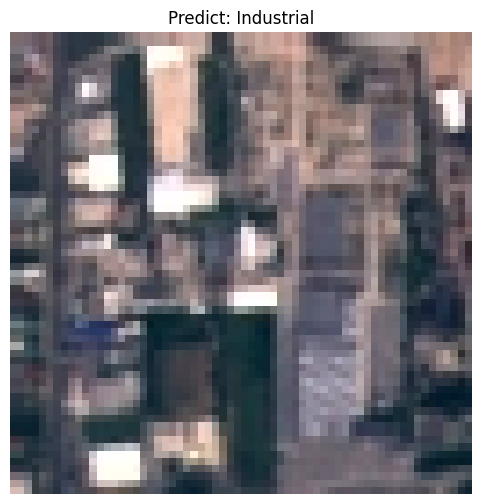

In [29]:
# Disable gradient calculation
with torch.no_grad():
  # Create an iterator for the test data loader
  data_iter = iter(dl_test)

  # Get the first batch of test data
  data = next(data_iter)

  inputs, _ = data

  # Select the first image and add a batch dimension
  image = inputs[0].unsqueeze(0)
  image = image.to(device)

  outputs = model(image)

  # Get the predicted class label by taking the index of the max log-probability
  _, predicted = torch.max(outputs, 1)

  # Move the image back to the CPU and convert it to a NumPy arra
  image_numpy = image.cpu().numpy()[0]

  image_numpy = np.transpose(image_numpy, (1, 2, 0))

  # Check the number of channels in the image and adjust for display
  # If the image has 1 channel (grayscale)
  if image_numpy.shape[2] == 1:
    # Remove the channel dimension
    image_numpy = np.squeeze(image_numpy, axis=2)

  # If the image has 3 channels (RGB)
  elif image_numpy.shape[2] == 3:
    # Normalize the image for display
    image_numpy = (image_numpy - image_numpy.min()) / (image_numpy.max() - image_numpy.min())

  plt.figure(figsize=(6, 6))
  plt.imshow(image_numpy)
  plt.title(f'Predict: {mapping[predicted.item()]}')
  plt.axis('off')
  plt.show()